# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [ ]:
noise = .2

#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

In [ ]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

This lets us look at which classes do better:

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

In [ ]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

In [ ]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [ ]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

In [138]:
#Bayes
clf_nb = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf_linsvc = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf_polysvc = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf_neigh = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf_logreg = sklearn.linear_model.LogisticRegression()

#Symbolists
clf_dtree = sklearn.tree.DecisionTreeClassifier()
clf_rf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf_mlp = sklearn.neural_network.MLPClassifier()

#Ensemble
clf_gbc = sklearn.ensemble.GradientBoostingClassifier()

#Stochastic gradient descent
clf_sgd=sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", max_iter=5)




In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

In [ ]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

In [ ]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

.........................................
Dataset 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.475  0.572917   0.448276           0.439224  0.812500
1              0.475  0.572917   0.727273           0.642424  0.333333


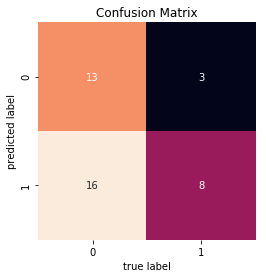

None


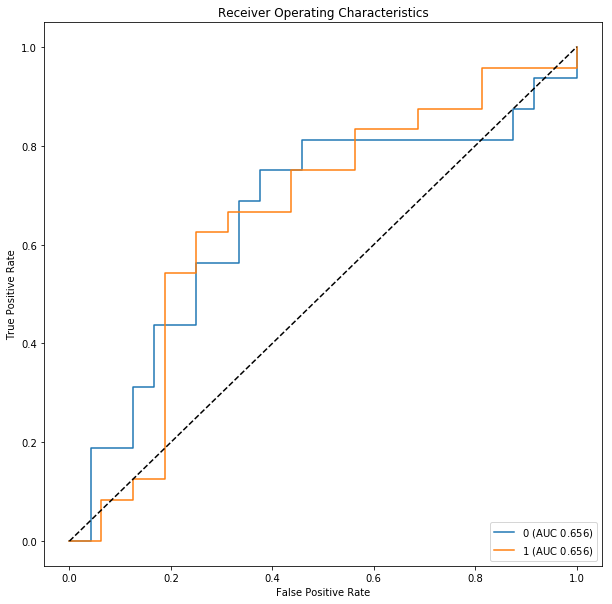

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


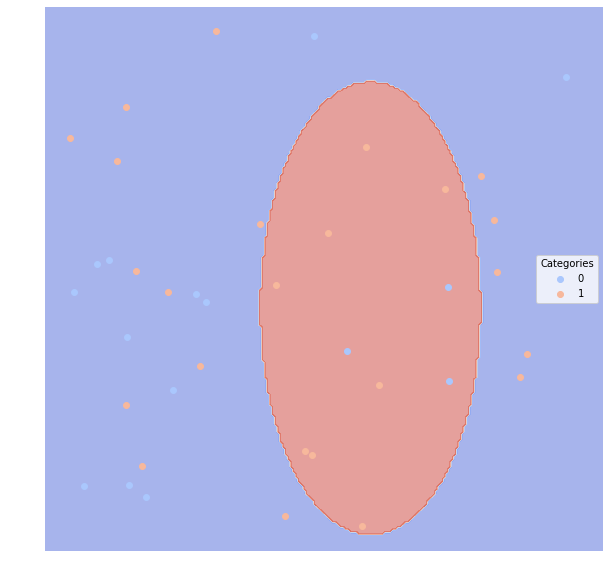

None
.........................................
.........................................
Dataset 1
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0                0.6  0.5        0.4                0.4     1.0
1                0.6  0.5        0.0                0.6     0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


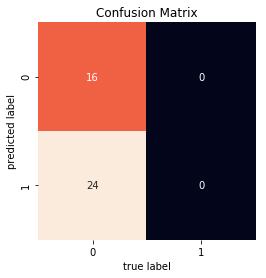

None


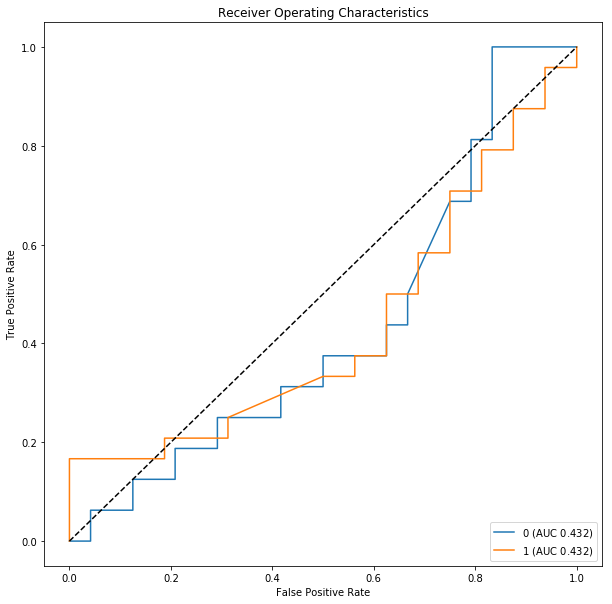

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


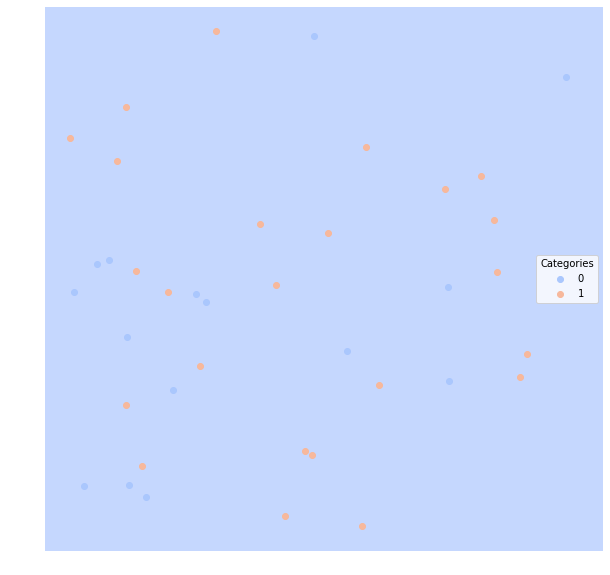

None
.........................................
.........................................
Dataset 1
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0                0.6  0.5        0.4                0.4     1.0
1                0.6  0.5        0.0                0.6     0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


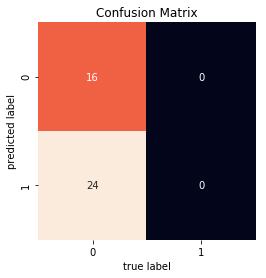

None


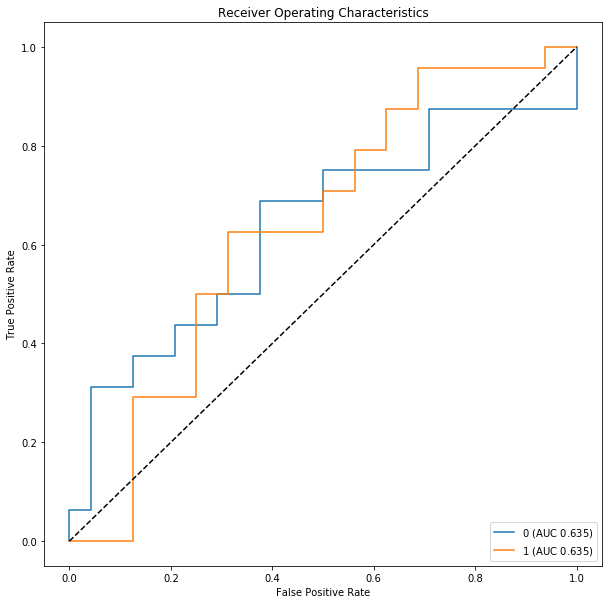

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


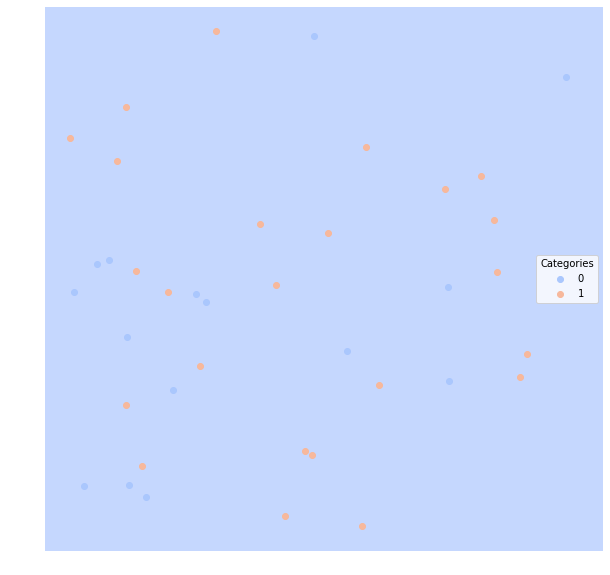

None
.........................................
.........................................
Dataset 1
          Error_Rate      AUC  Precision  Average_Precision  Recall
Category                                                           
0              0.425  0.59375   0.478261           0.453804  0.6875
1              0.425  0.59375   0.705882           0.652941  0.5000


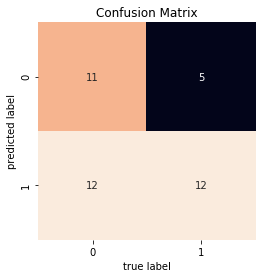

None


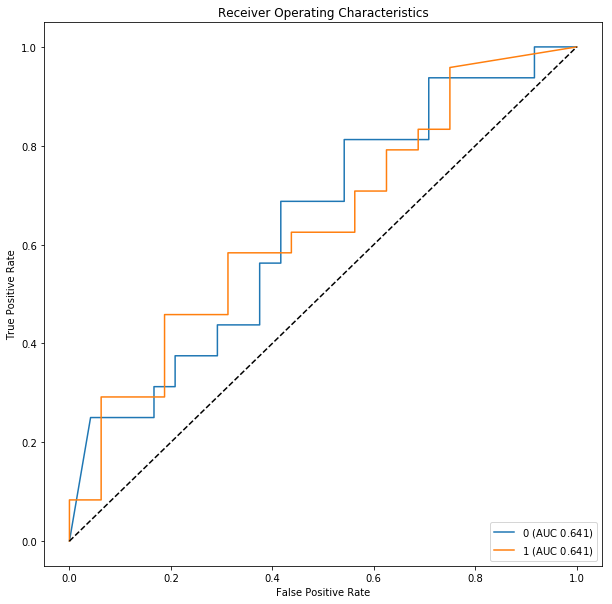

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


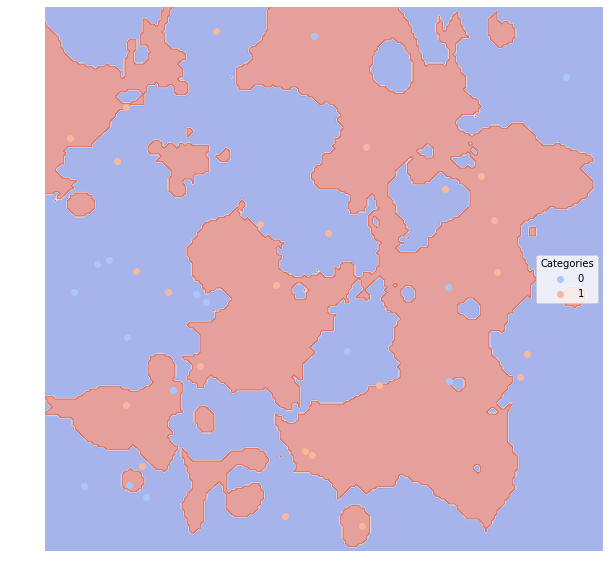

None
.........................................
.........................................
Dataset 1
          Error_Rate      AUC  Precision  Average_Precision  Recall
Category                                                           
0              0.625  0.46875   0.384615           0.385577  0.9375
1              0.625  0.46875   0.000000           0.600000  0.0000


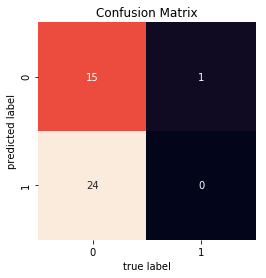

None


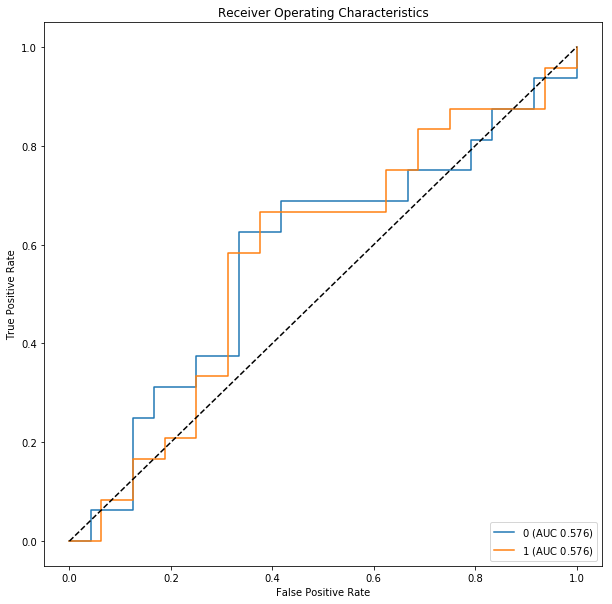

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


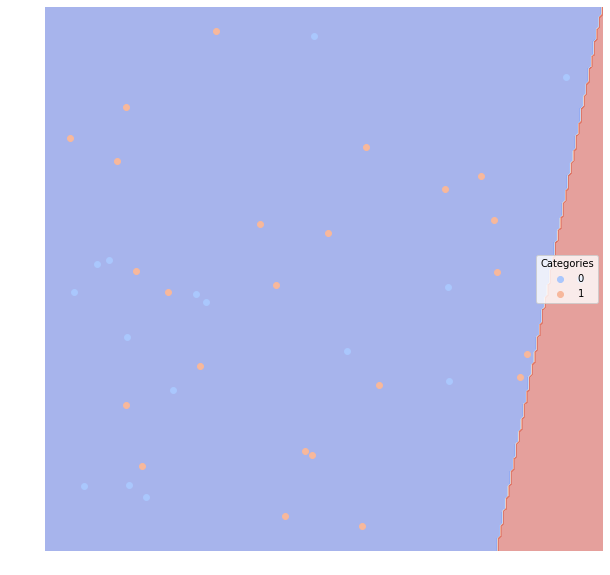

None
.........................................
.........................................
Dataset 1
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.525  0.5        0.4                0.4   0.625
1              0.525  0.5        0.6                0.6   0.375


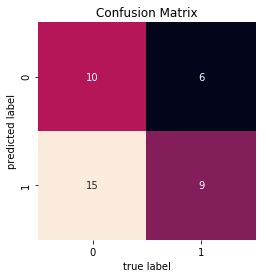

None


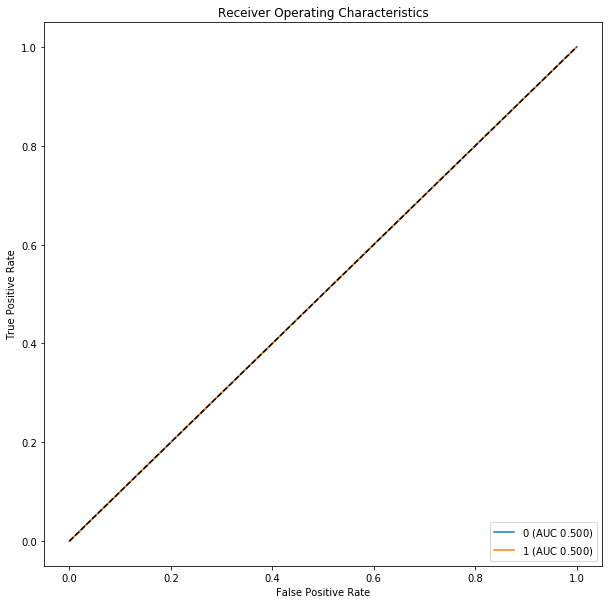

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


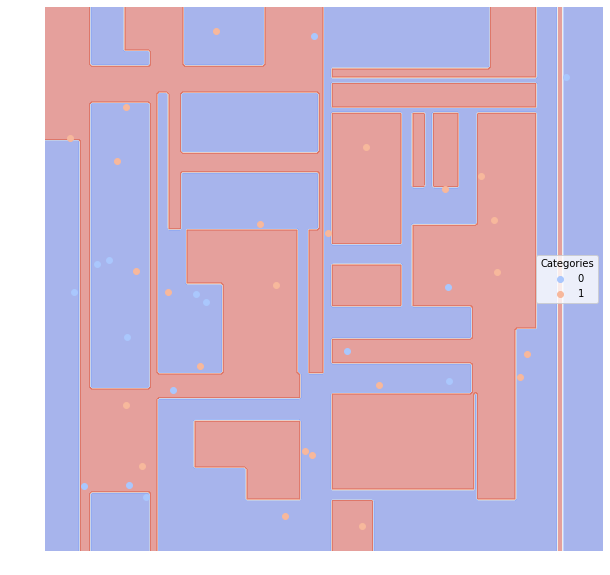

None
.........................................
.........................................
Dataset 1
          Error_Rate      AUC  Precision  Average_Precision  Recall
Category                                                           
0              0.375  0.65625       0.52             0.4975  0.8125
1              0.375  0.65625       0.80             0.7000  0.5000


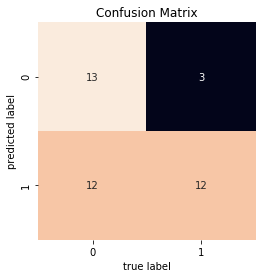

None


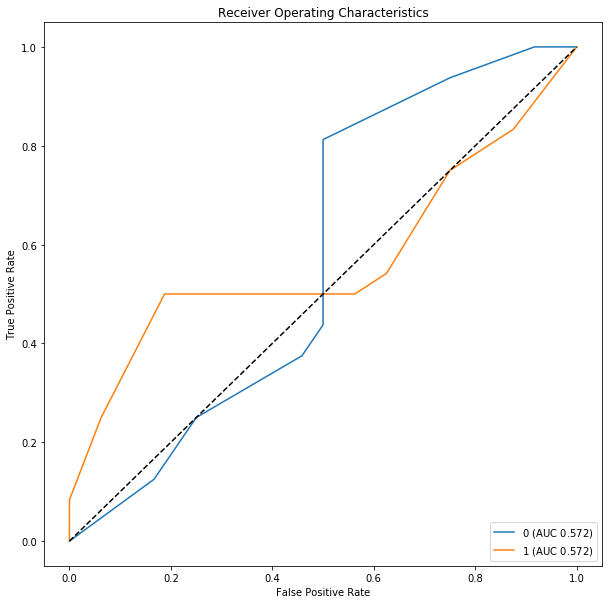

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


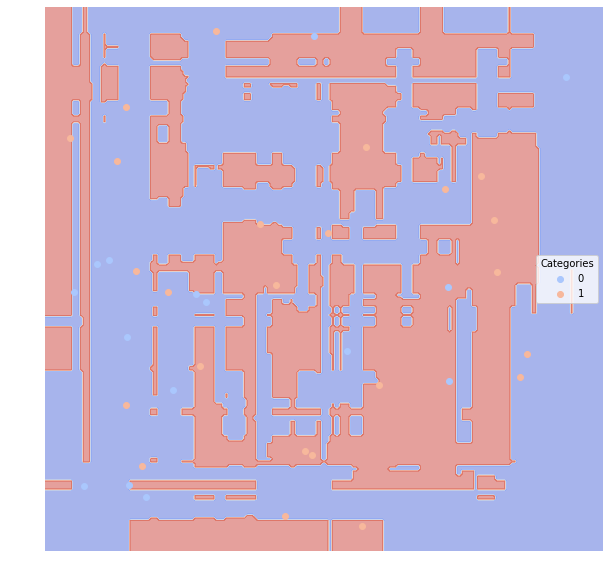

None
.........................................
.........................................
Dataset 1
          Error_Rate      AUC  Precision  Average_Precision  Recall
Category                                                           
0               0.45  0.59375   0.464286           0.452232  0.8125
1               0.45  0.59375   0.750000           0.656250  0.3750


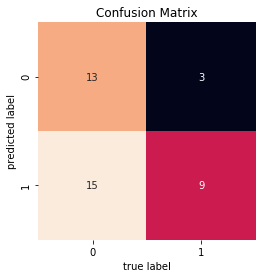

None


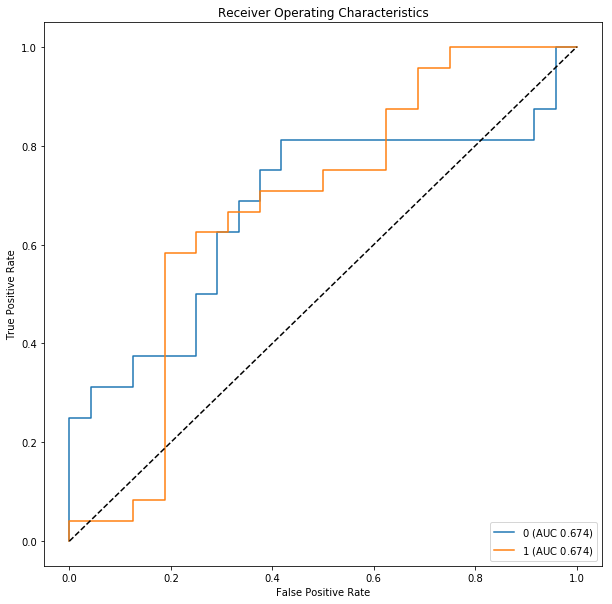

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


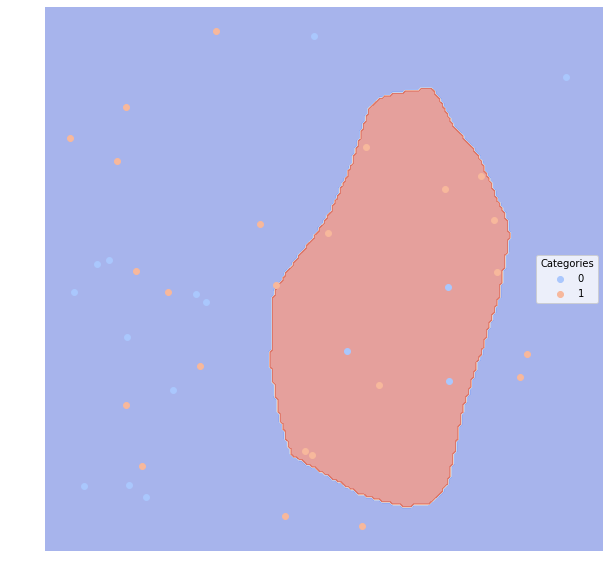

None
.........................................
.........................................
Dataset 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.575  0.427083   0.333333           0.370833  0.437500
1              0.575  0.427083   0.526316           0.569298  0.416667


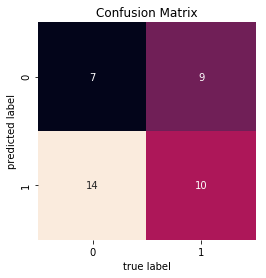

None


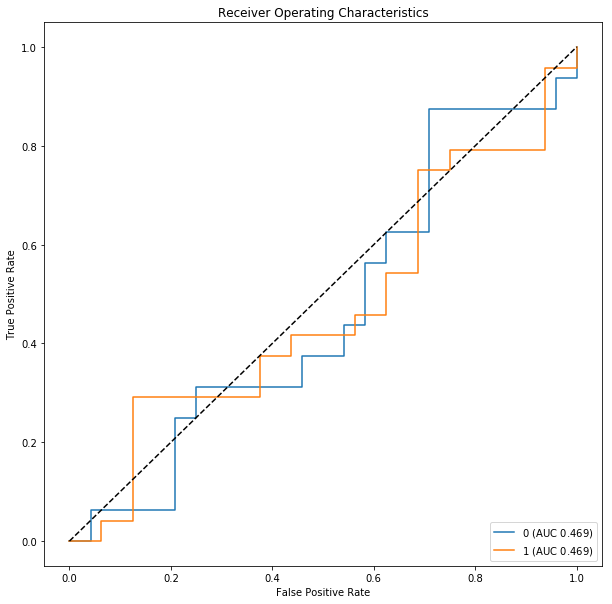

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


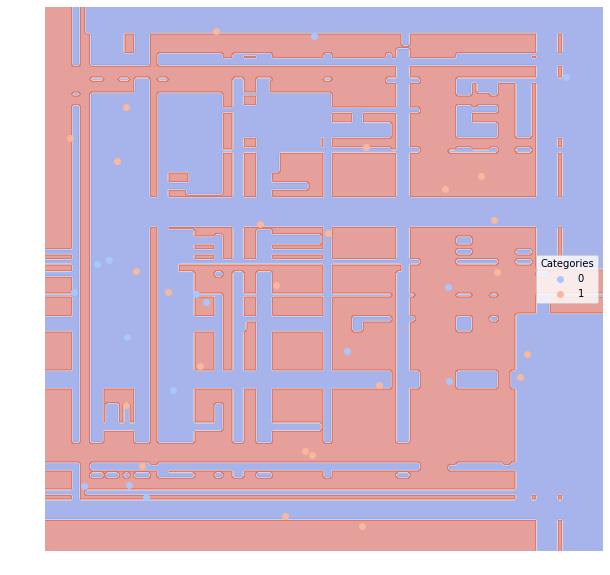

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.51  0.490035   0.482587           0.487619  0.492386
1               0.51  0.490035   0.497487           0.502617  0.487685


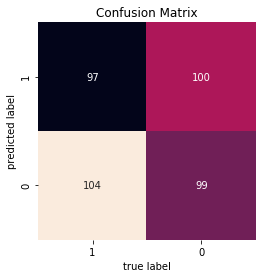

None


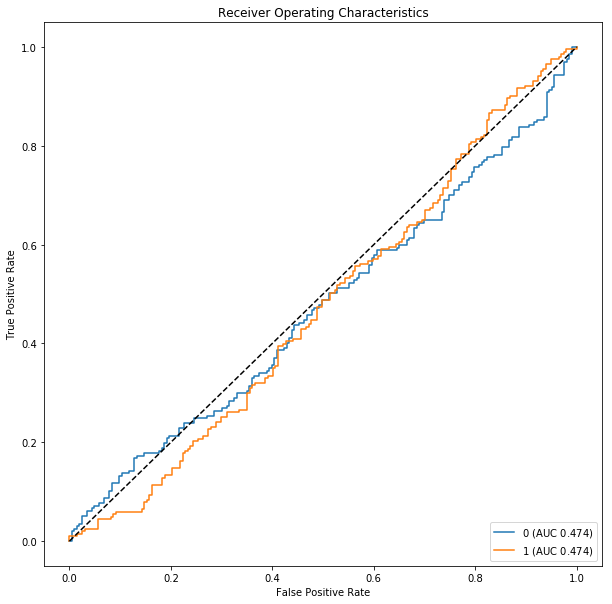

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


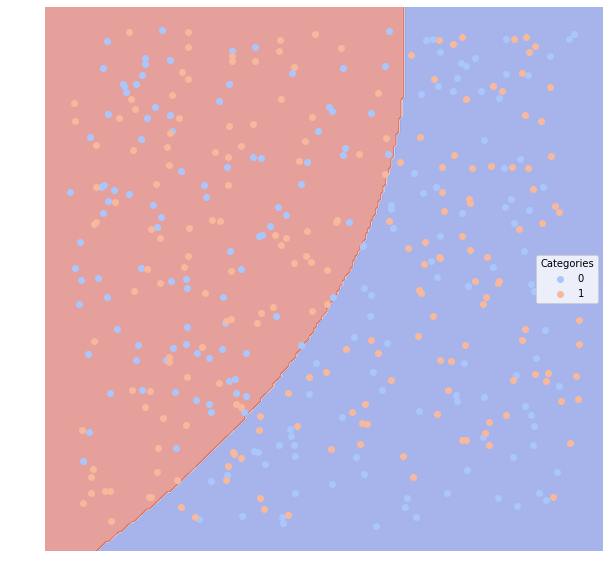

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.51  0.489585   0.481481           0.487410  0.461929
1               0.51  0.489585   0.497630           0.502395  0.517241


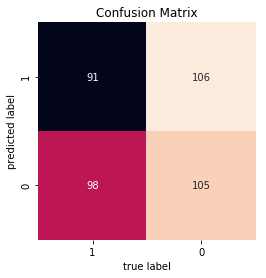

None


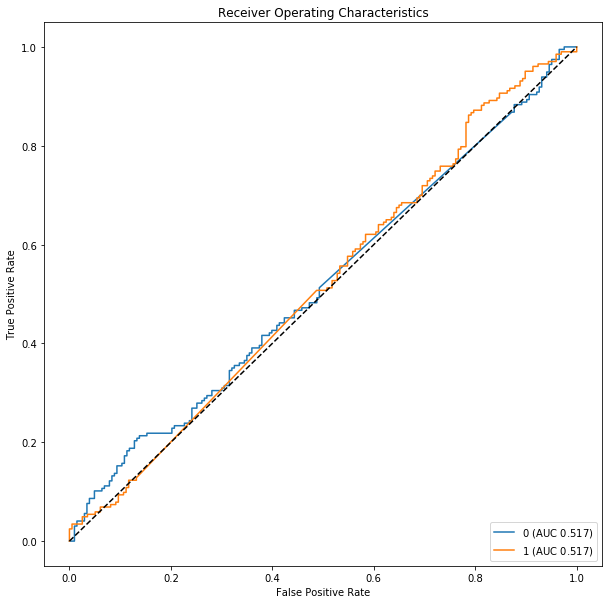

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


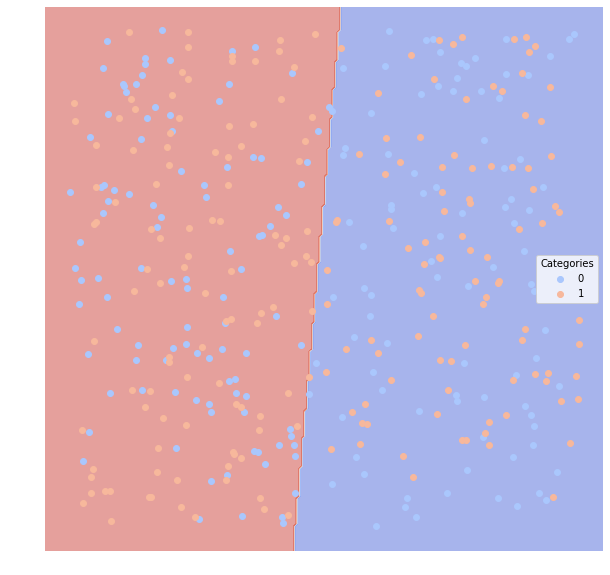

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.515  0.486084   0.480349           0.485715  0.558376
1              0.515  0.486084   0.491228           0.500767  0.413793


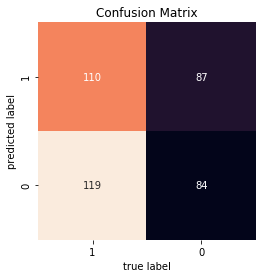

None


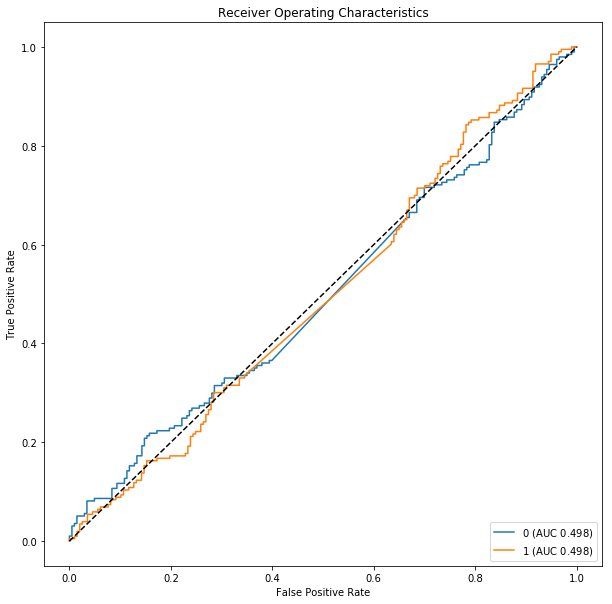

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


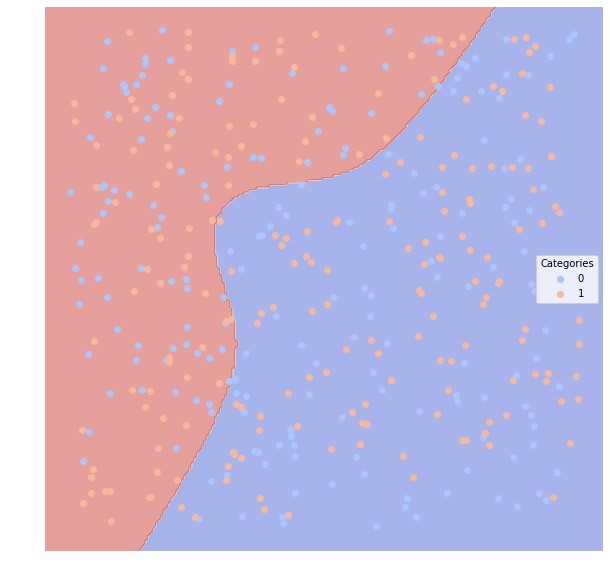

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.4875  0.512503      0.505           0.498909  0.512690
1             0.4875  0.512503      0.520           0.513904  0.512315


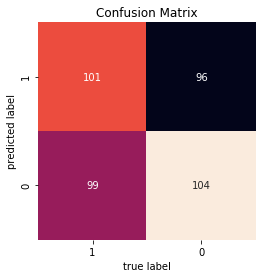

None


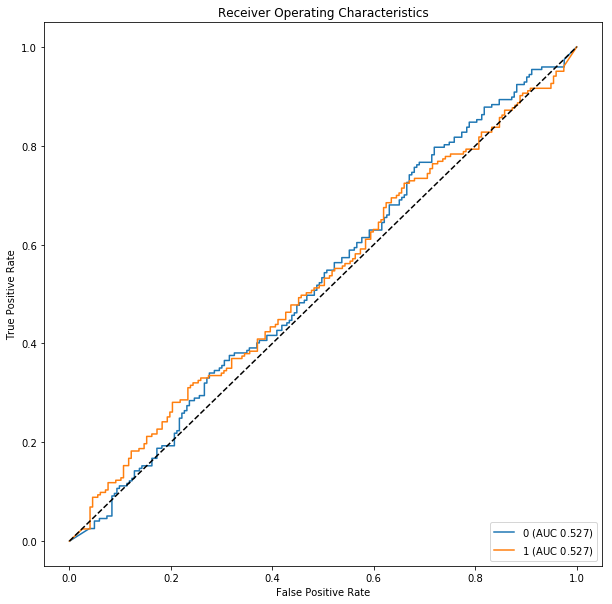

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


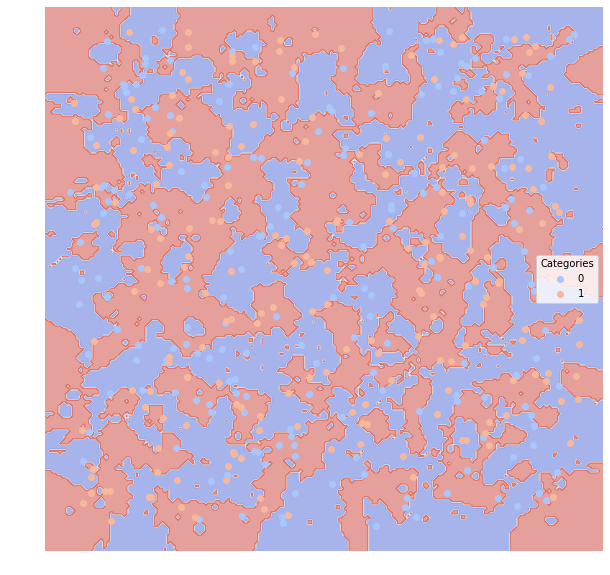

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.505  0.495186   0.487805           0.490117  0.507614
1              0.505  0.495186   0.502564           0.505117  0.482759


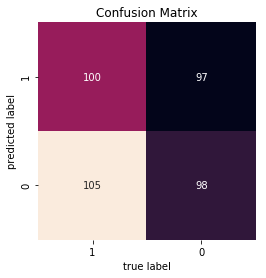

None


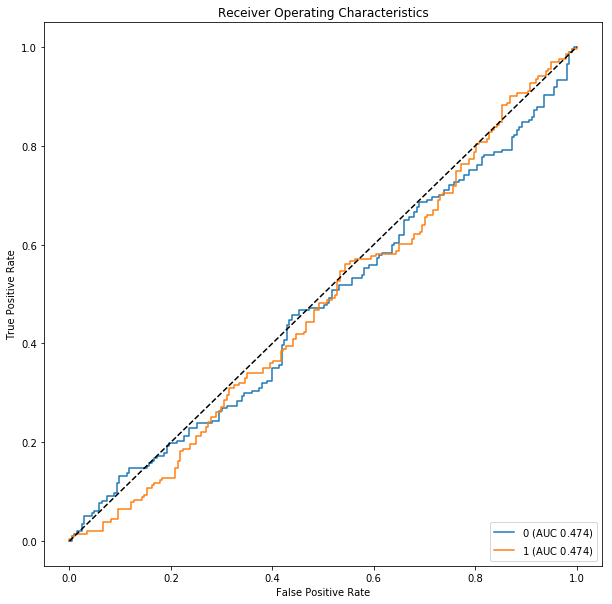

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


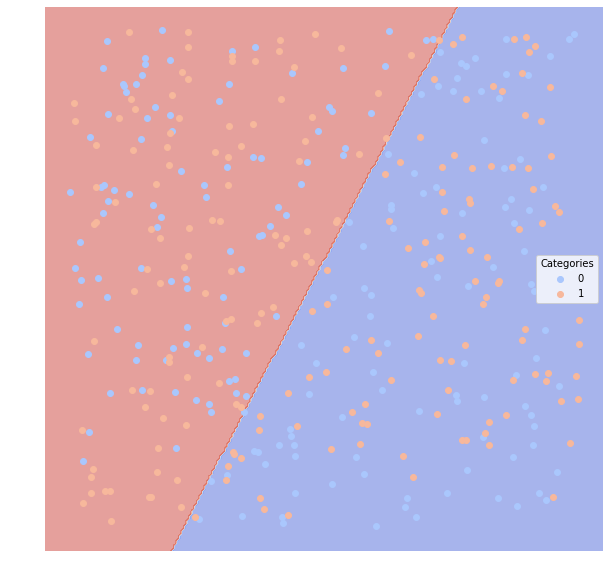

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.515  0.485559   0.479070           0.485478  0.522843
1              0.515  0.485559   0.491892           0.500503  0.448276


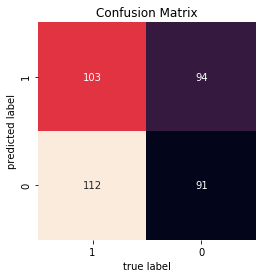

None


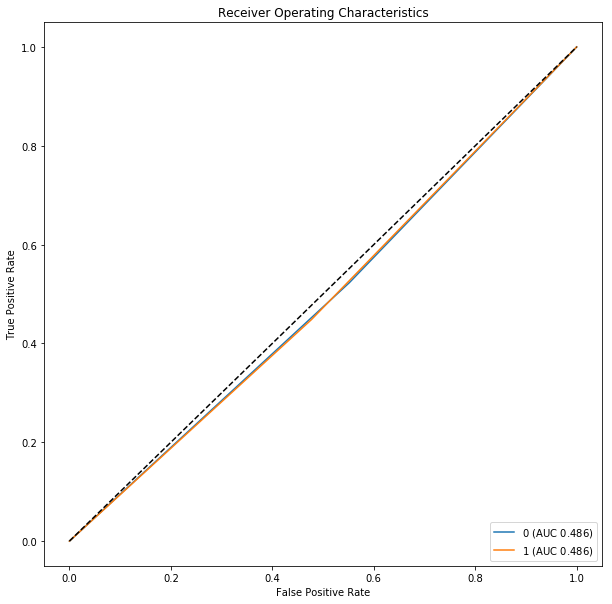

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


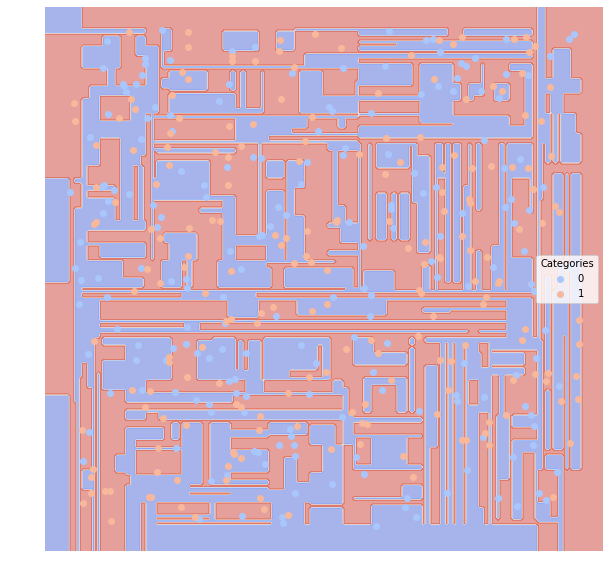

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.4825  0.517879   0.509524           0.501746  0.543147
1             0.4825  0.517879   0.526316           0.516769  0.492611


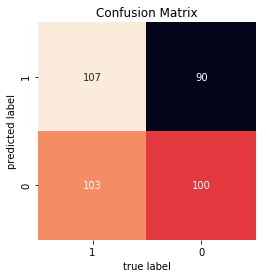

None


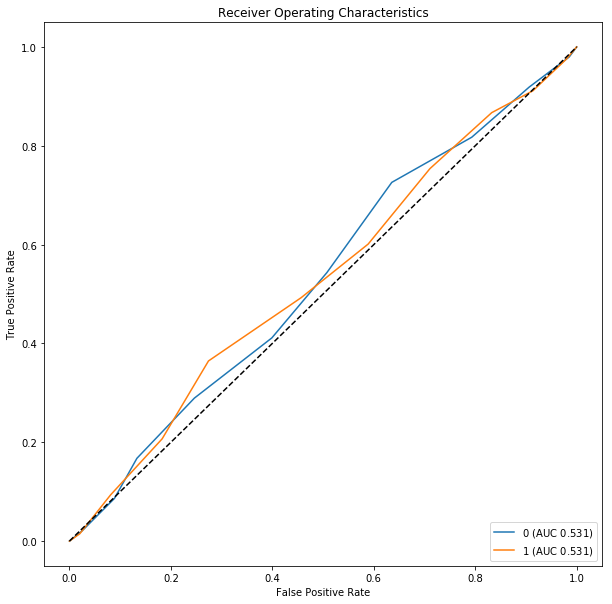

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


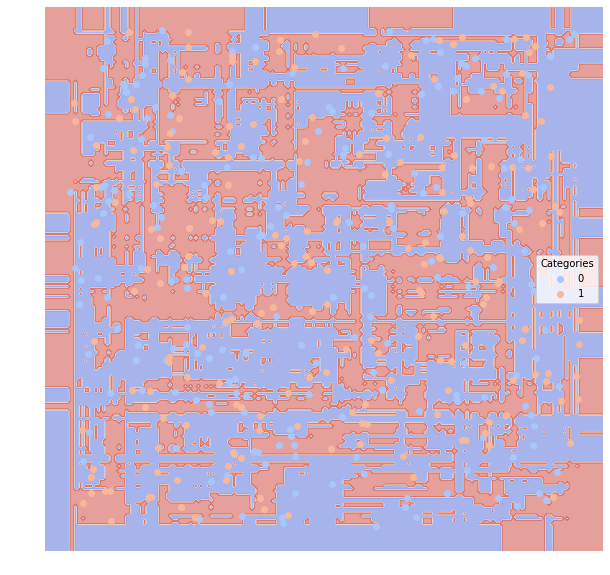

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.515  0.485934   0.480000           0.485647  0.548223
1              0.515  0.485934   0.491429           0.500691  0.423645


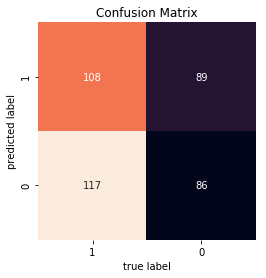

None


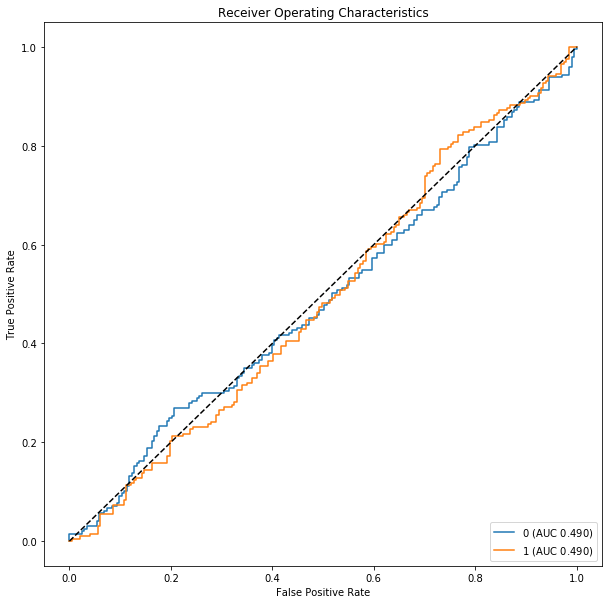

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


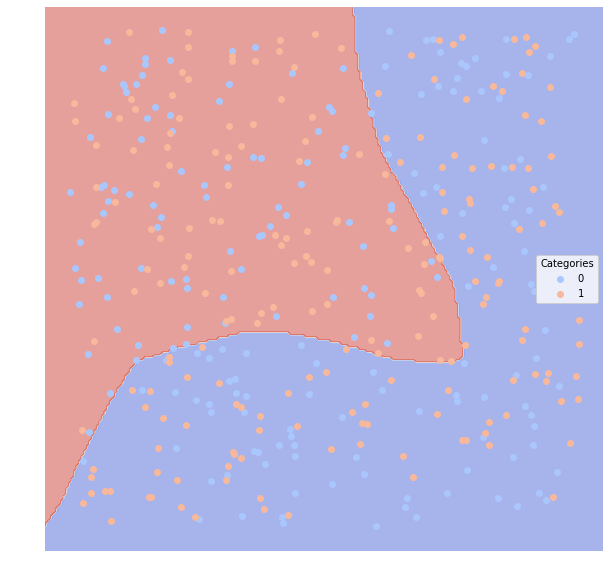

None
.........................................
.........................................
Dataset 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.4875  0.511828   0.505495           0.498569  0.467005
1             0.4875  0.511828   0.518349           0.513539  0.556650


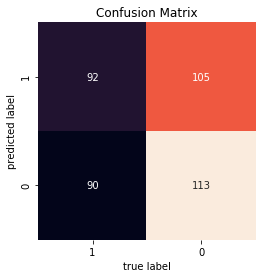

None


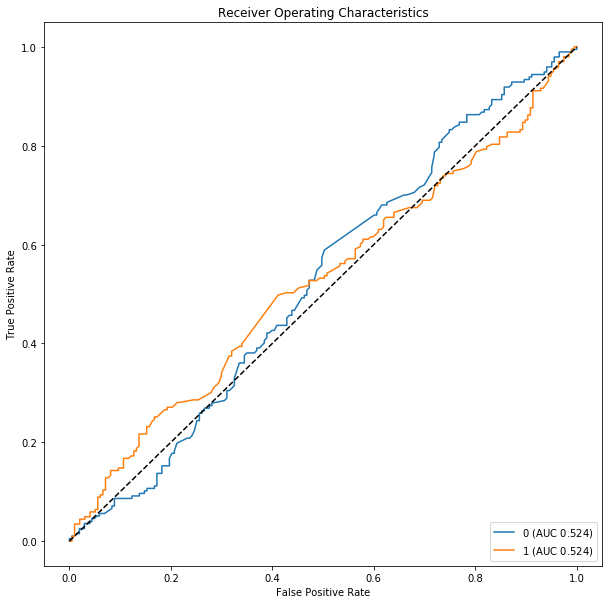

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


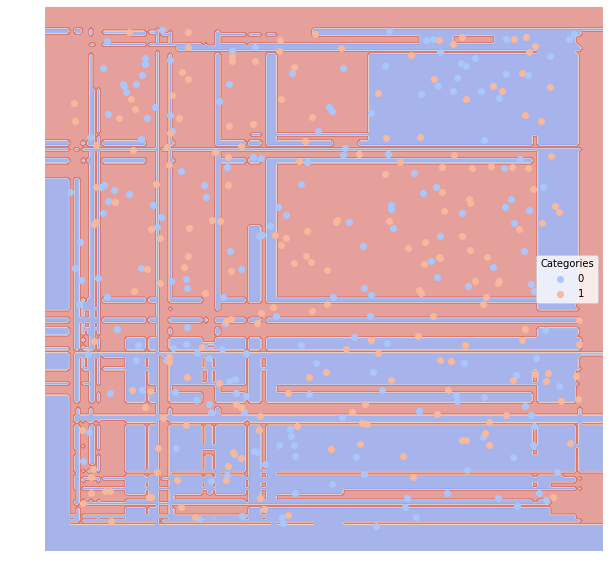

None
.........................................
.........................................
Dataset 3
          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.025  0.975   0.961165           0.956553    0.99
1              0.025  0.975   0.989691           0.970103    0.96


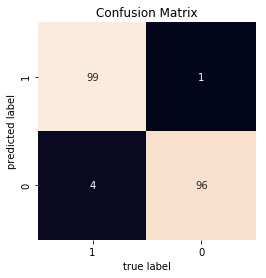

None


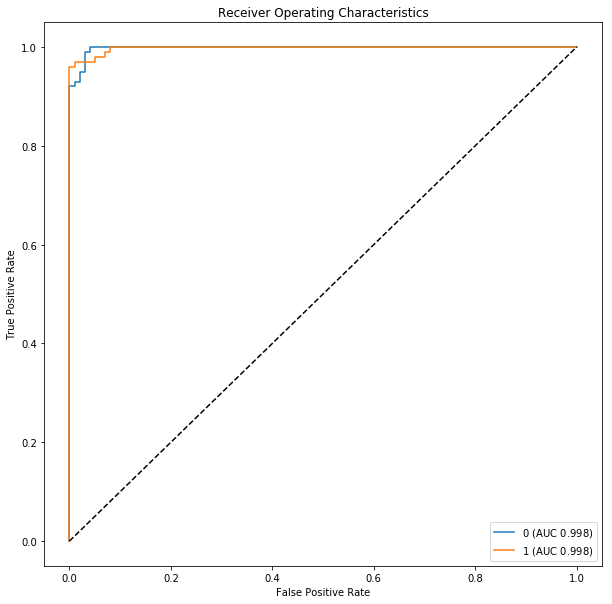

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


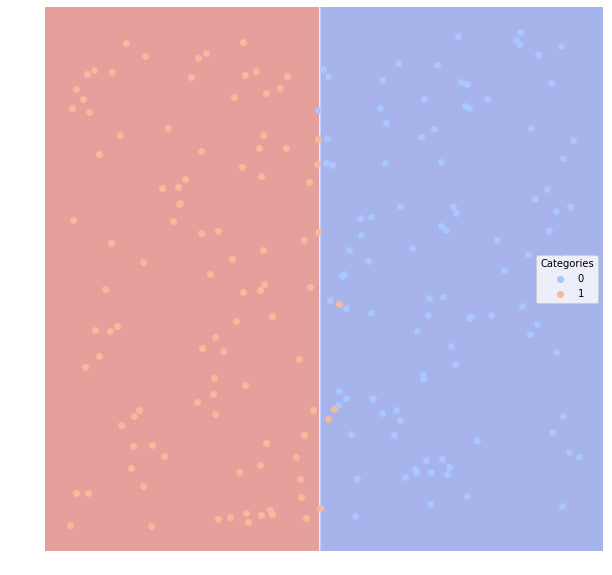

None
.........................................
.........................................
Dataset 3
          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.025  0.975   0.961165           0.956553    0.99
1              0.025  0.975   0.989691           0.970103    0.96


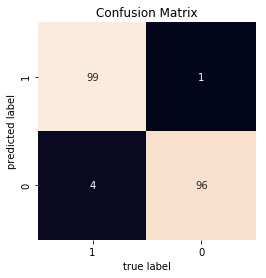

None


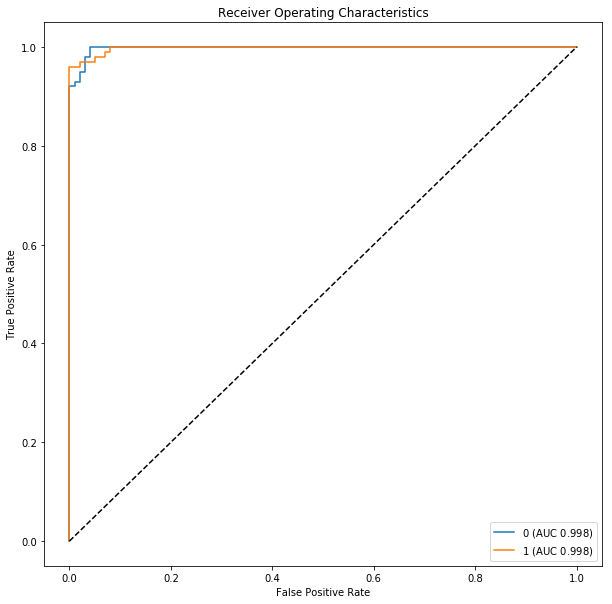

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


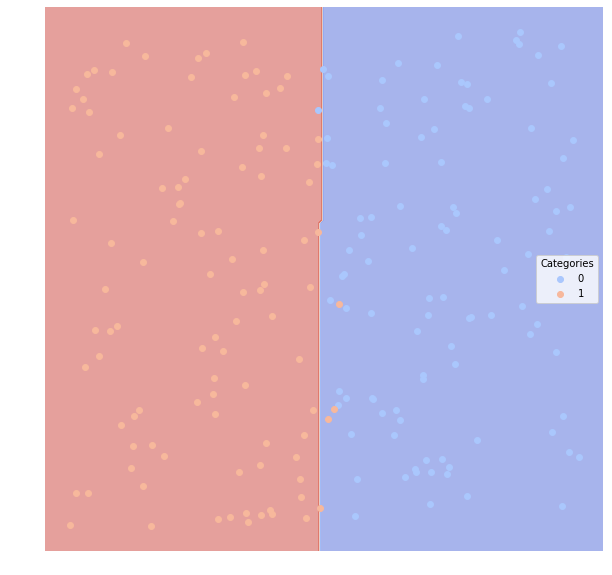

None
.........................................
.........................................
Dataset 3
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
0               0.07  0.93   0.967391           0.915978    0.89
1               0.07  0.93   0.898148           0.886204    0.97


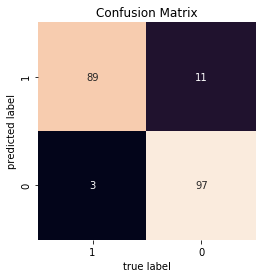

None


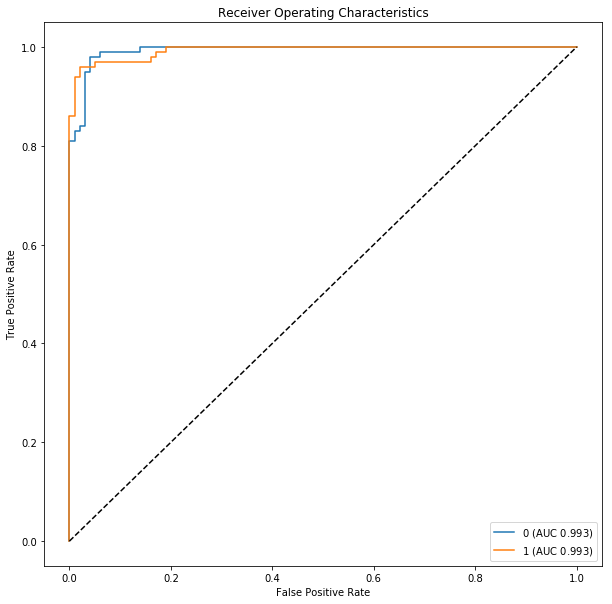

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


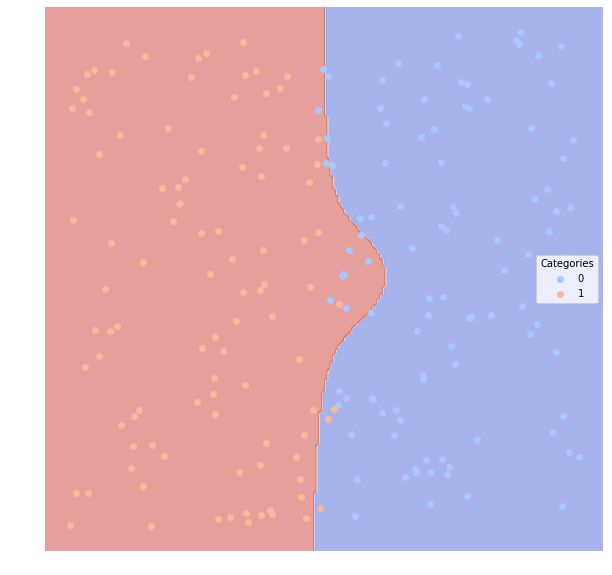

None
.........................................
.........................................
Dataset 3
          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.045  0.955   0.933333           0.924667    0.98
1              0.045  0.955   0.978947           0.945421    0.93


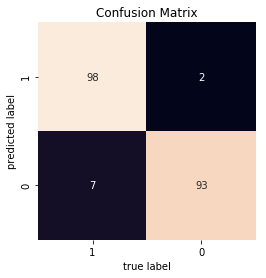

None


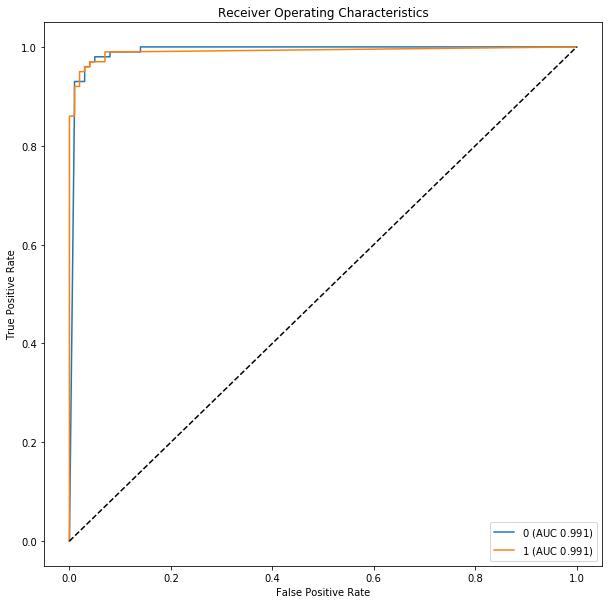

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


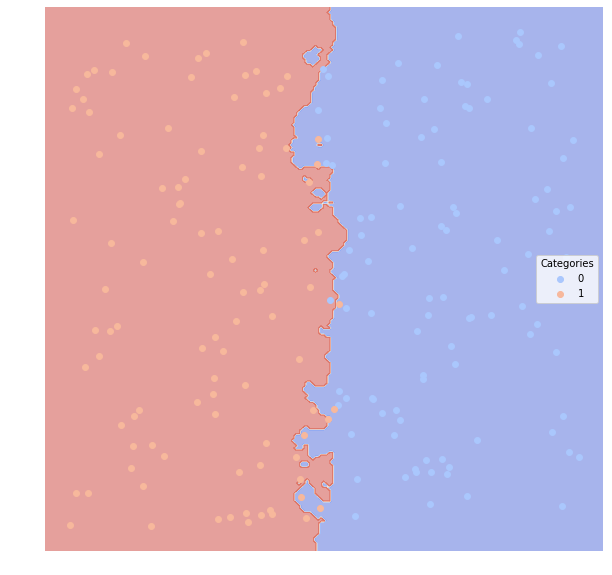

None
.........................................
.........................................
Dataset 3
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
0               0.02  0.98   0.970588           0.965882    0.99
1               0.02  0.98   0.989796           0.975102    0.97


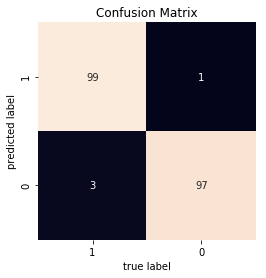

None


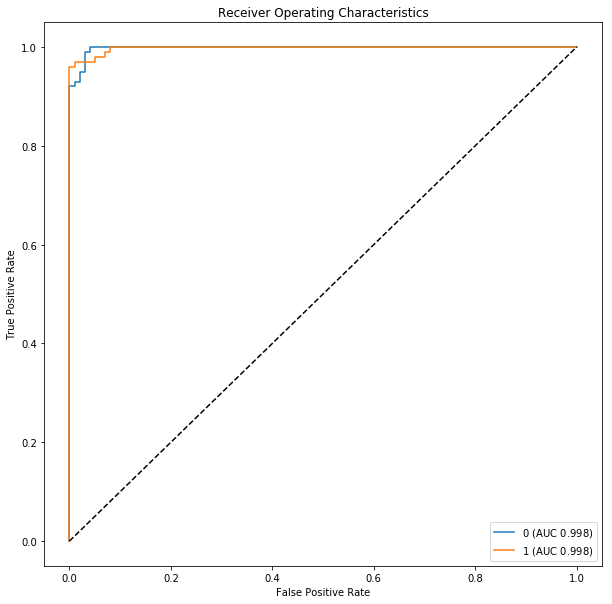

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


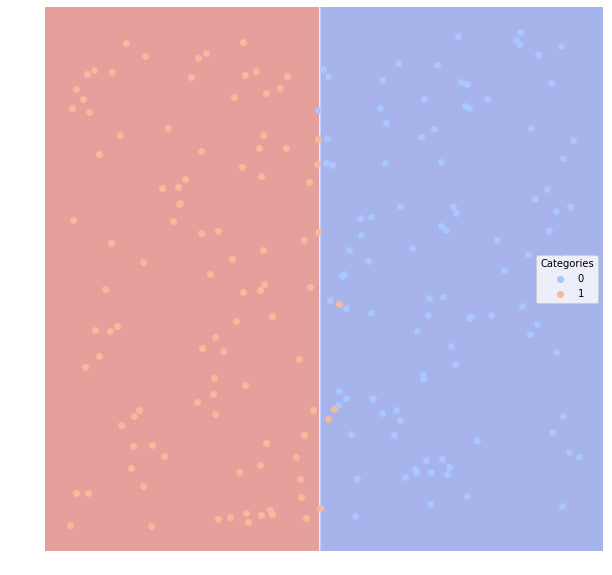

None
.........................................
.........................................
Dataset 3
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
0               0.06  0.94   0.923077           0.906154    0.96
1               0.06  0.94   0.958333           0.921667    0.92


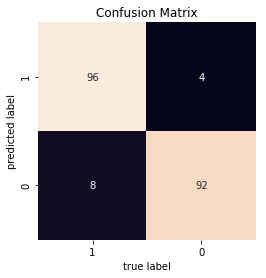

None


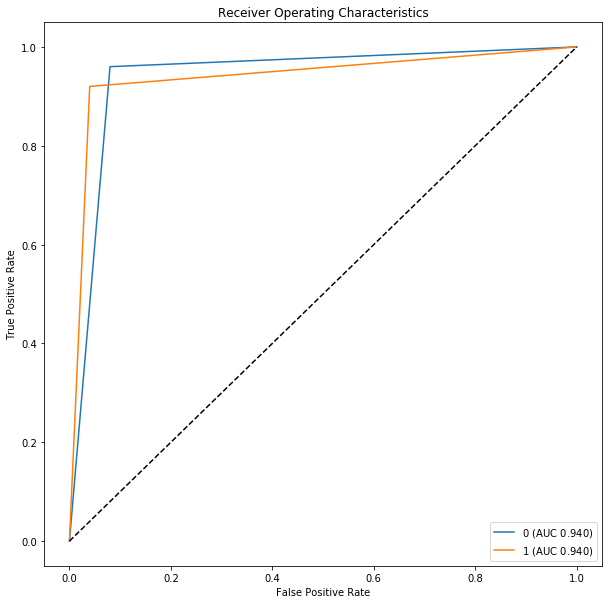

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


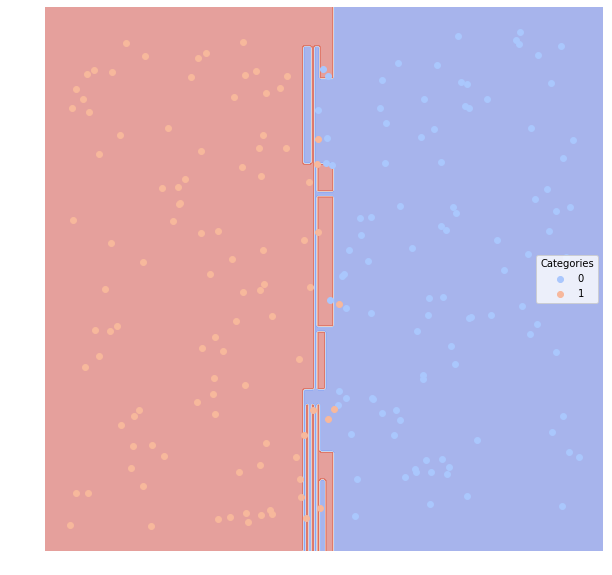

None
.........................................
.........................................
Dataset 3
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
0               0.05  0.95   0.932692           0.919712    0.97
1               0.05  0.95   0.968750           0.935938    0.93


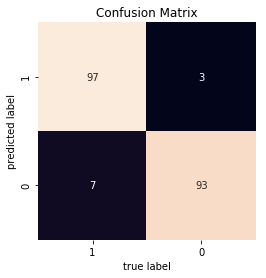

None


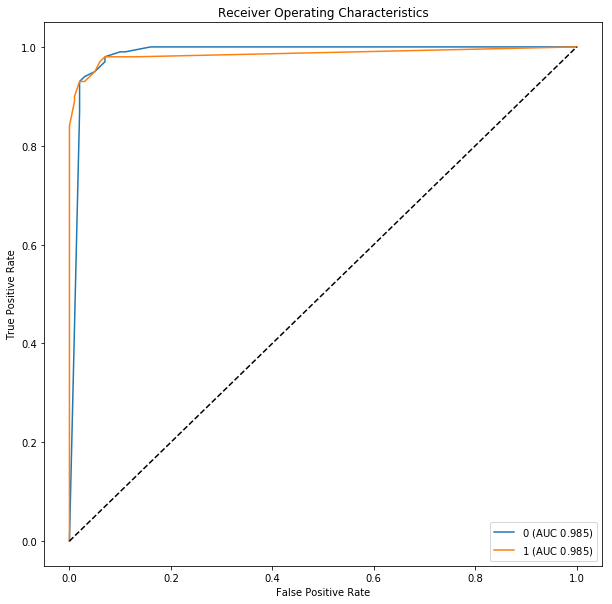

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


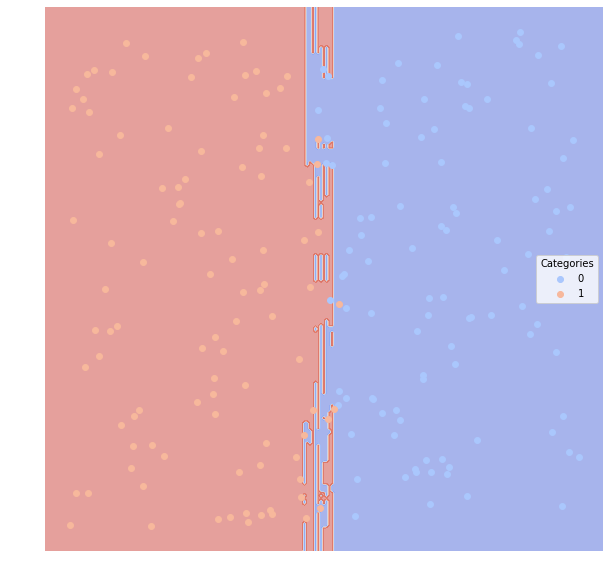

None
.........................................
.........................................
Dataset 3
          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.025  0.975   0.961165           0.956553    0.99
1              0.025  0.975   0.989691           0.970103    0.96


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


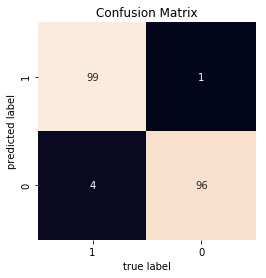

None


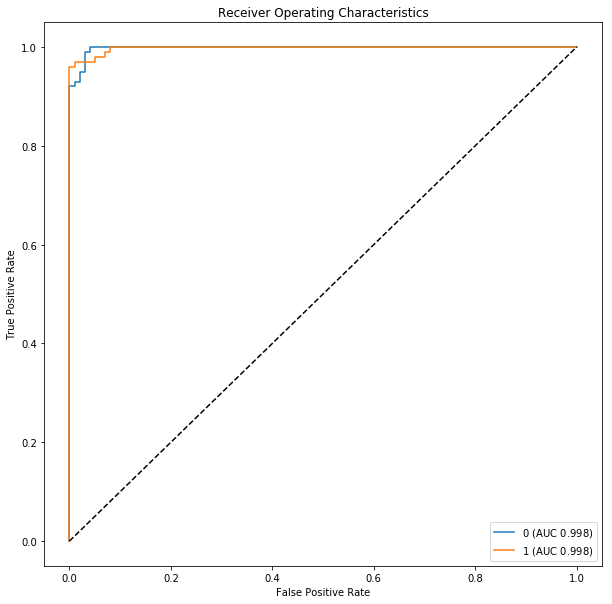

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


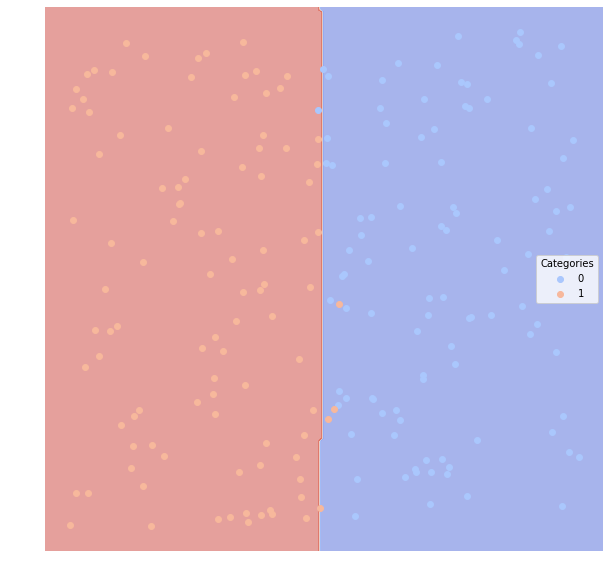

None
.........................................
.........................................
Dataset 3
          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.055  0.945   0.940594           0.918564    0.95
1              0.055  0.945   0.949495           0.922525    0.94


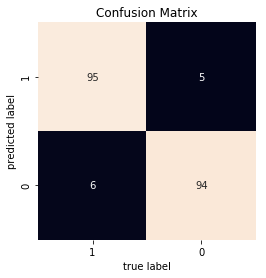

None


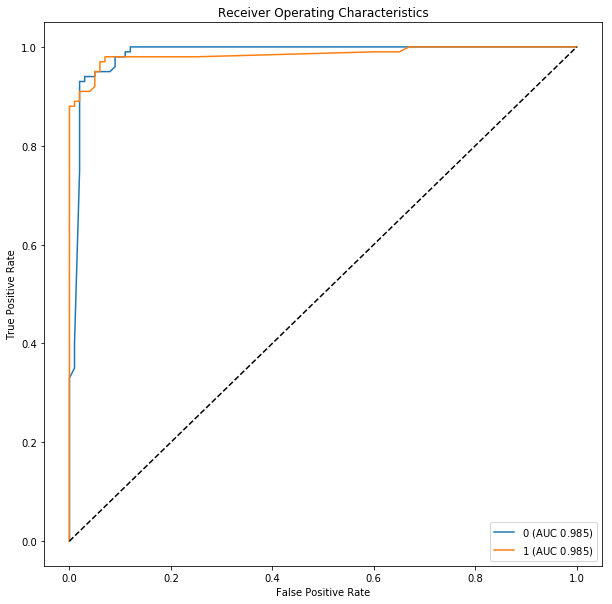

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


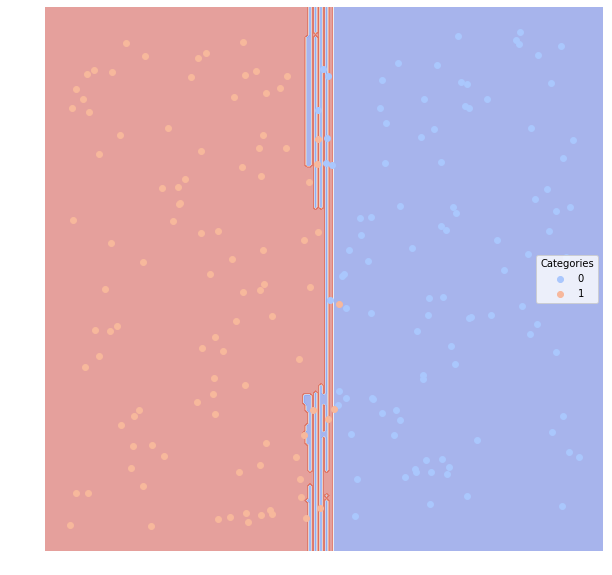

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.505  0.509596   0.563380           0.554866  0.363636
1              0.505  0.509596   0.457364           0.454828  0.655556


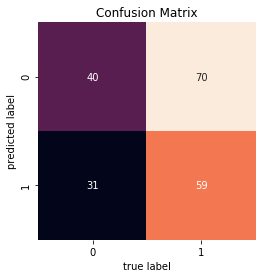

None


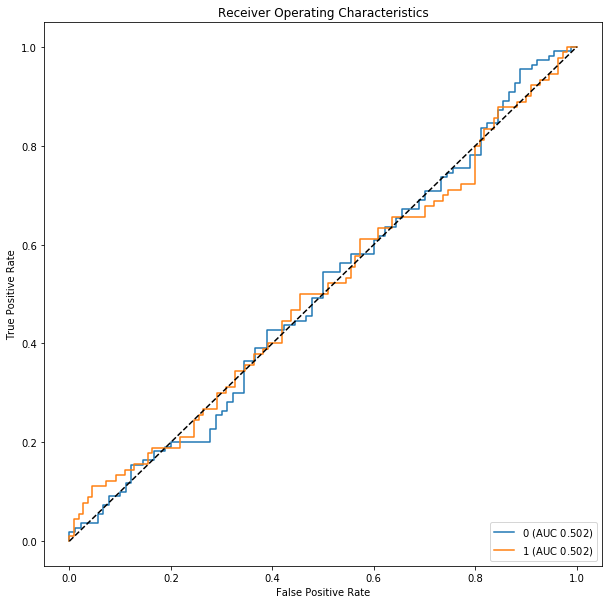

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


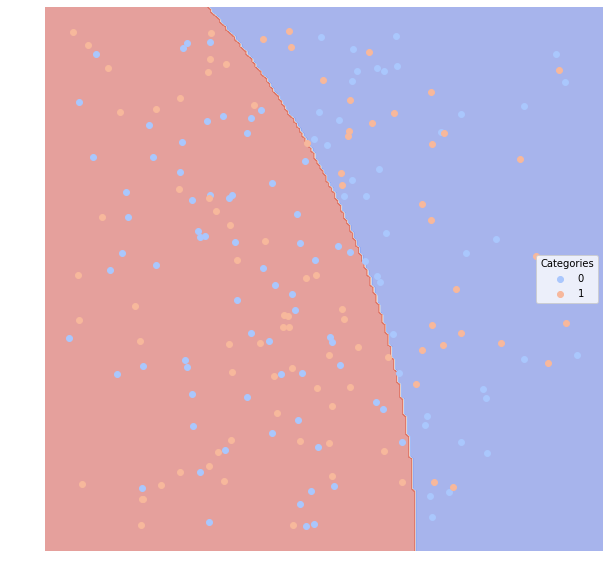

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.515  0.499495   0.549296            0.54975  0.354545
1              0.515  0.499495   0.449612            0.44975  0.644444


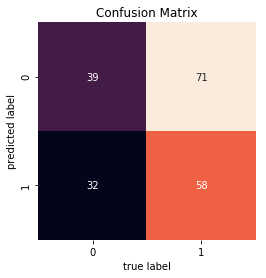

None


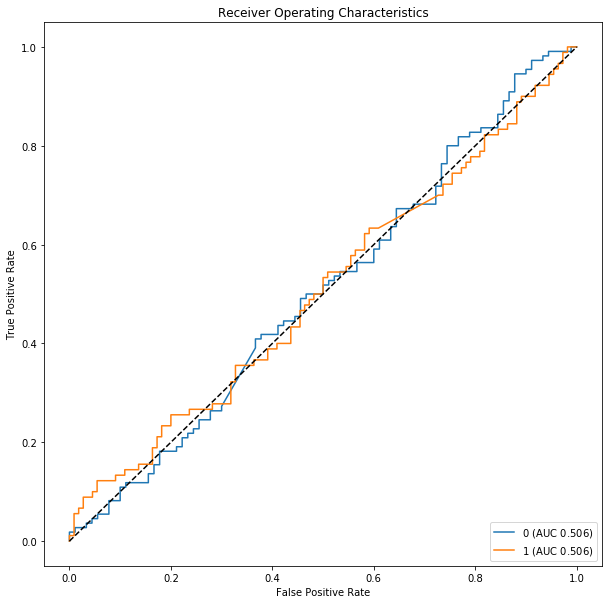

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


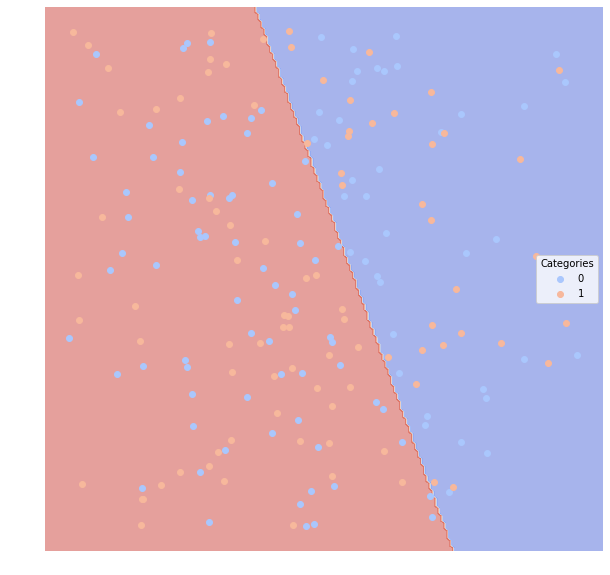

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.53  0.517172   0.833333           0.562879  0.045455
1               0.53  0.517172   0.458763           0.458666  0.988889


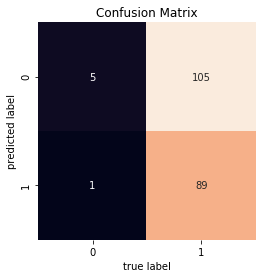

None


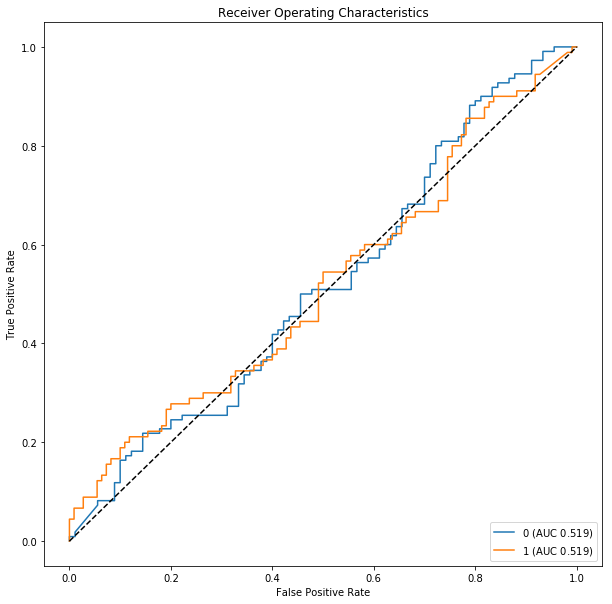

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


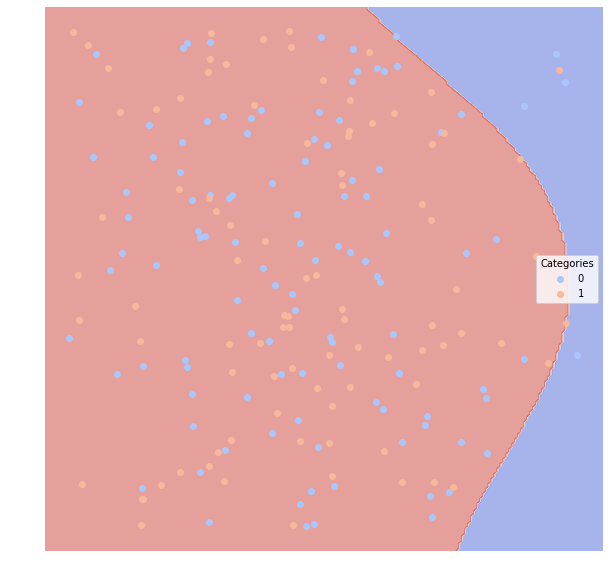

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.515  0.488384   0.537634           0.544379  0.454545
1              0.515  0.488384   0.439252           0.444387  0.522222


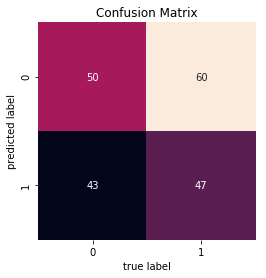

None


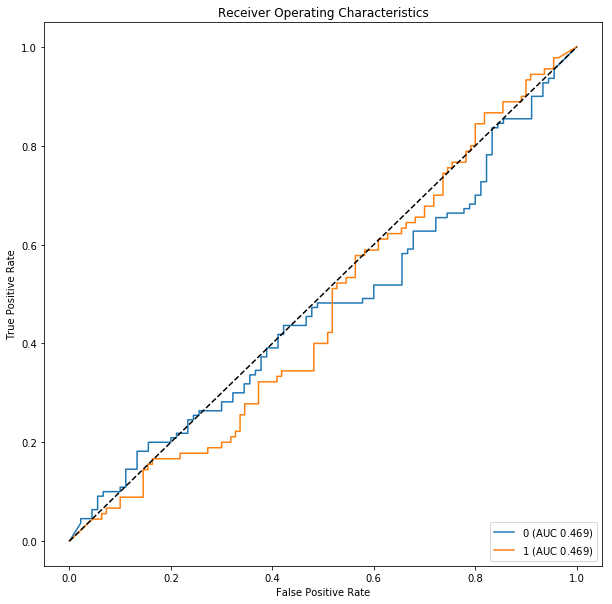

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


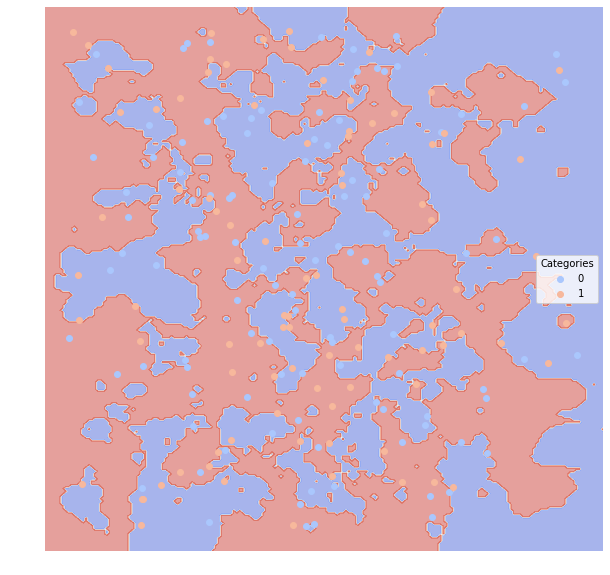

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.505  0.508586   0.561644           0.554340  0.372727
1              0.505  0.508586   0.456693           0.454313  0.644444


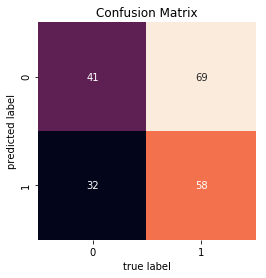

None


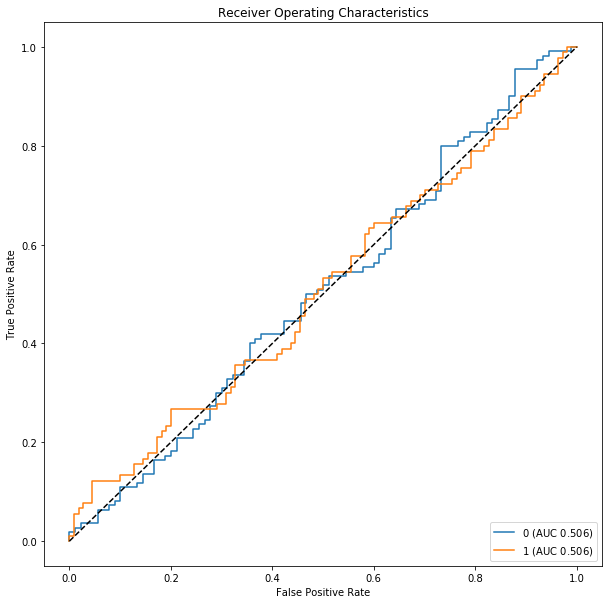

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


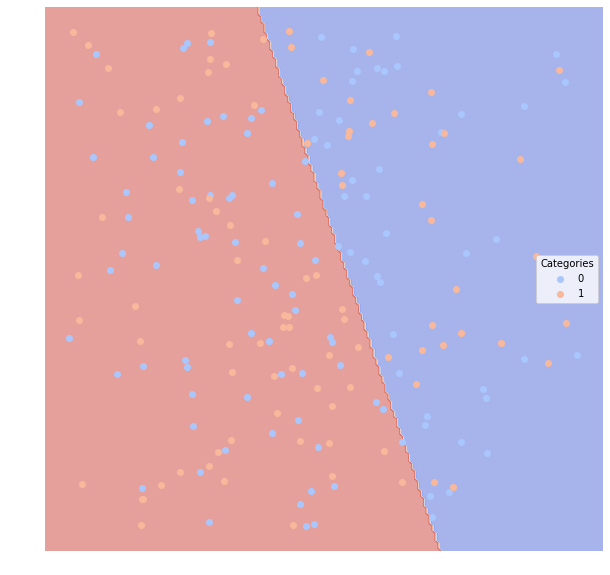

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.55  0.447475   0.500000           0.526364  0.472727
1               0.55  0.447475   0.395833           0.427130  0.422222


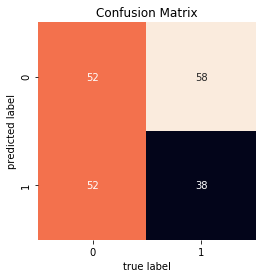

None


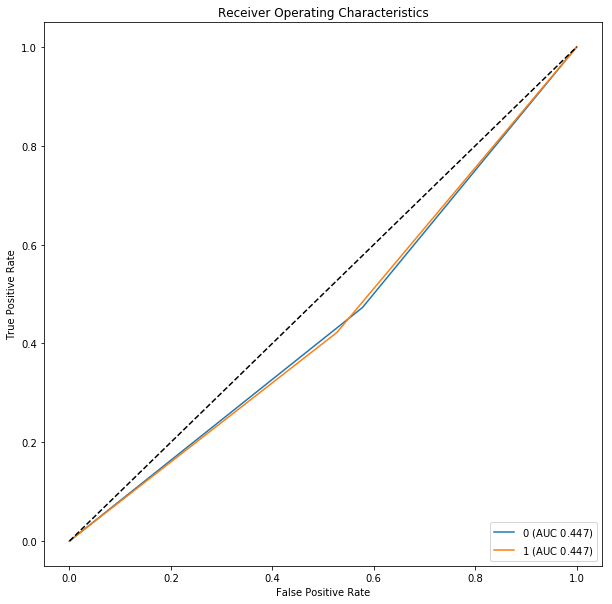

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


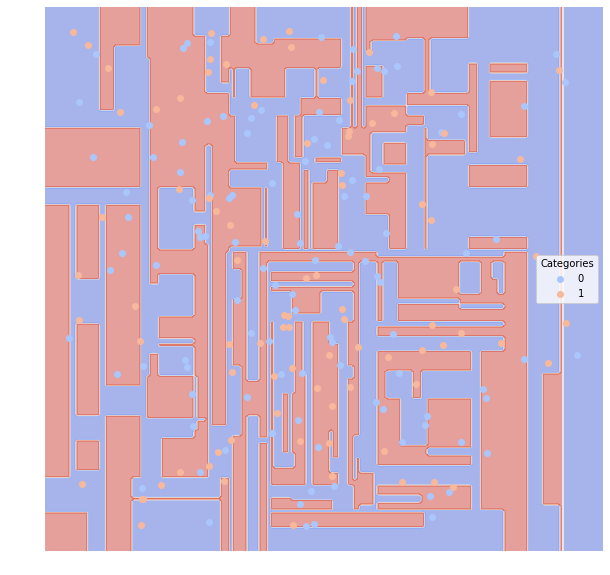

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.505556   0.554622           0.552773  0.600000
1              0.485  0.505556   0.456790           0.452791  0.411111


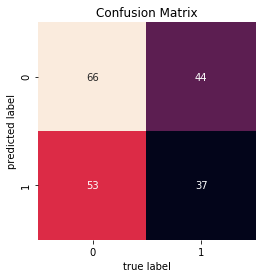

None


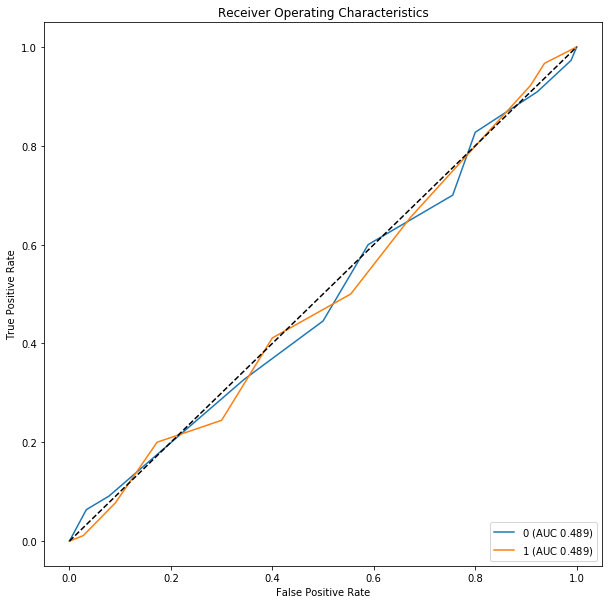

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


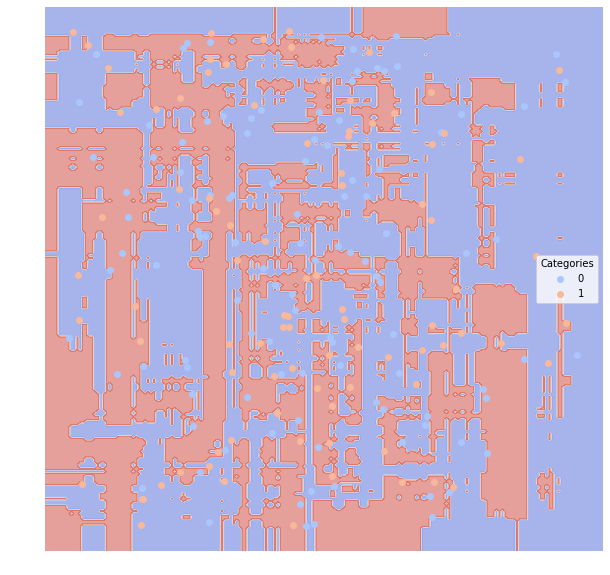

None
.........................................
.........................................
Dataset 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.505  0.512626   0.569231           0.556469  0.336364
1              0.505  0.512626   0.459259           0.456379  0.688889


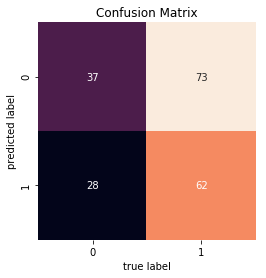

None


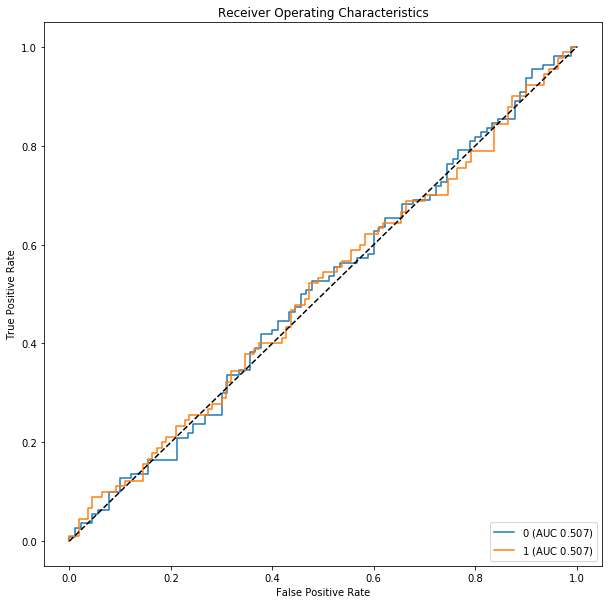

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


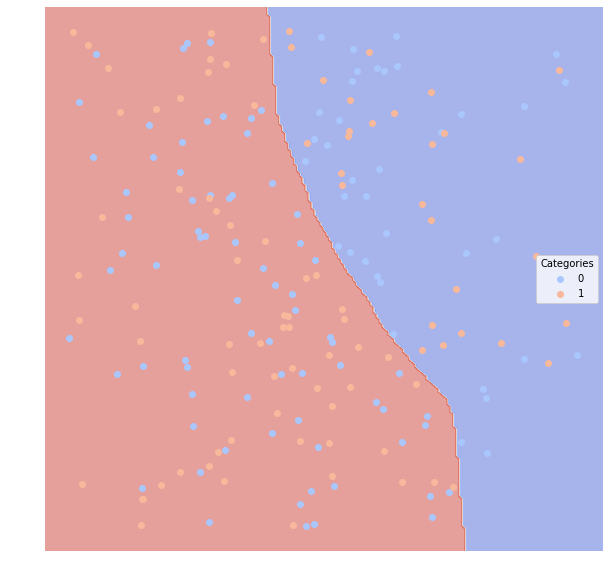

None
.........................................
.........................................
Dataset 4
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.555  0.44899   0.494505           0.527298  0.409091
1              0.555  0.44899   0.403670           0.427350  0.488889


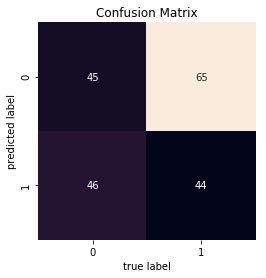

None


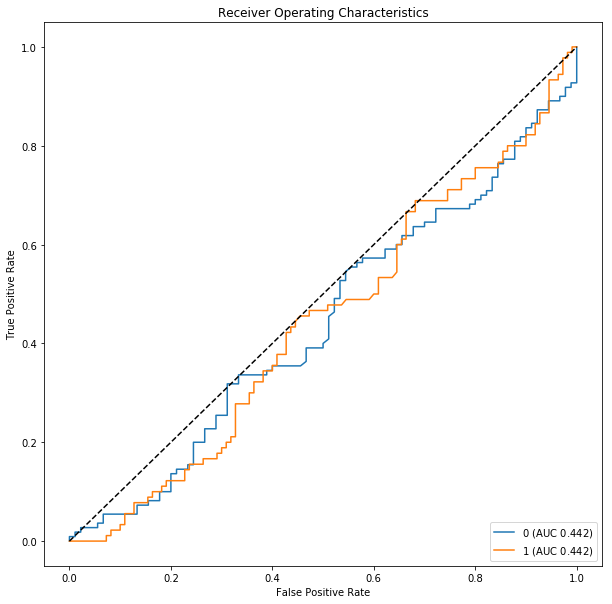

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


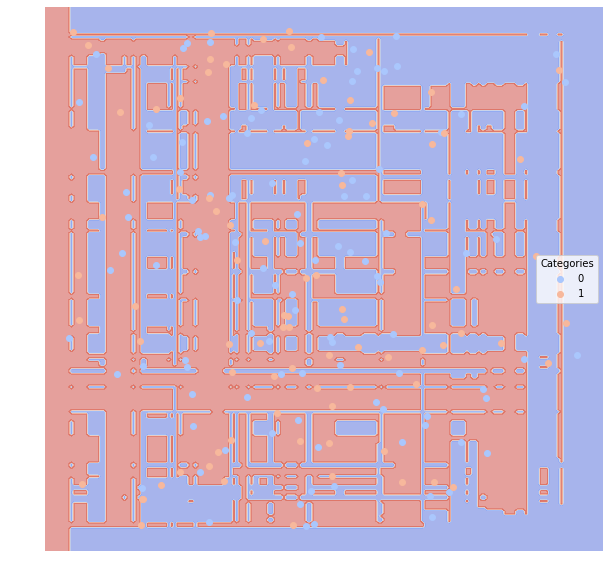

None
.........................................
.........................................
Dataset 5
          Error_Rate     AUC  Precision  Average_Precision    Recall
Category                                                            
0              0.495  0.5047   0.500000           0.497374  0.474747
1              0.495  0.5047   0.509434           0.507371  0.534653


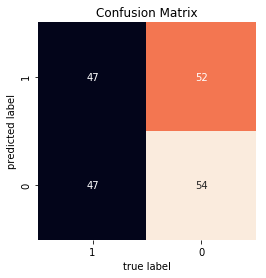

None


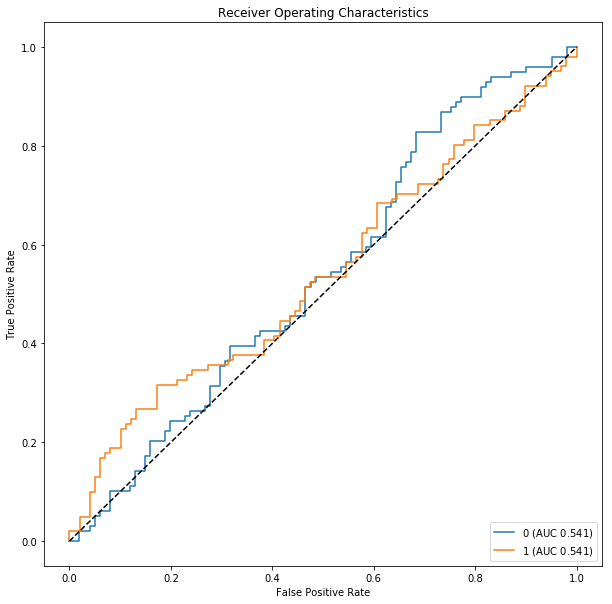

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


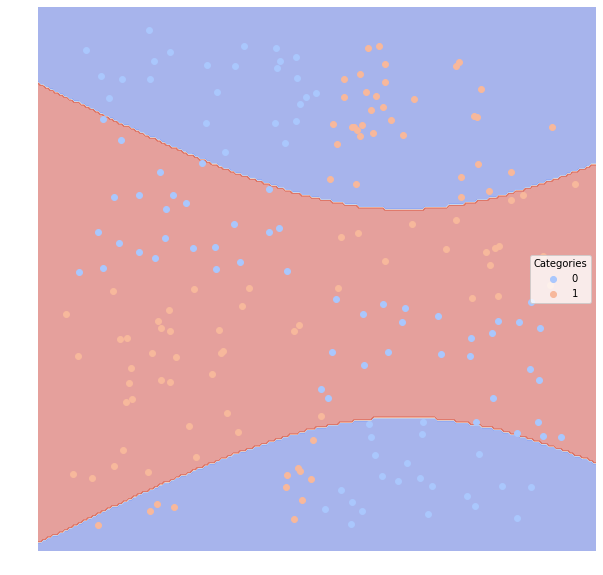

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.36  0.642064   0.595745           0.580480  0.848485
1               0.36  0.642064   0.745763           0.609887  0.435644


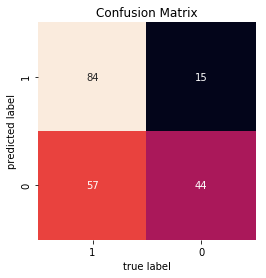

None


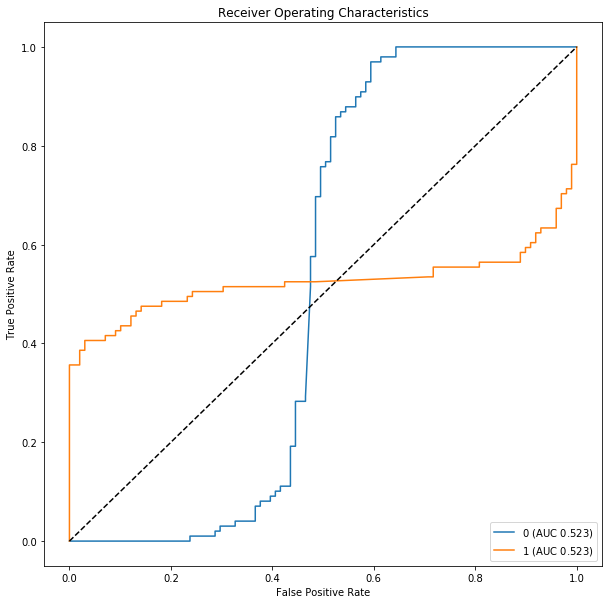

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


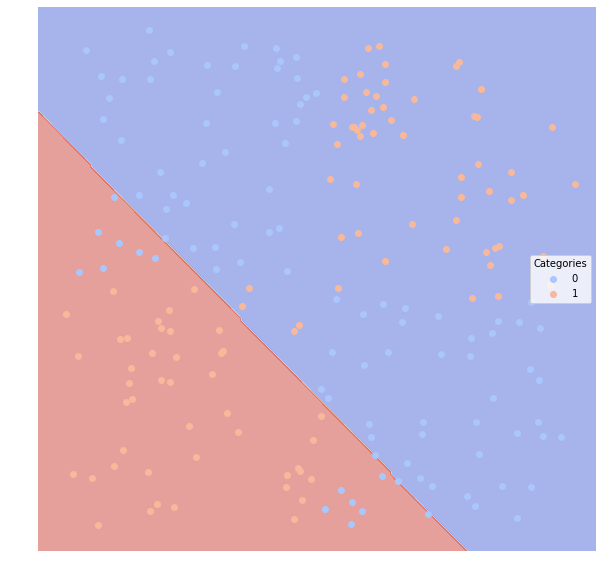

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.39  0.610661   0.592920           0.561269  0.676768
1               0.39  0.610661   0.632184           0.574259  0.544554


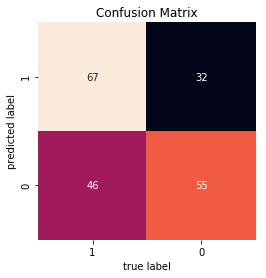

None


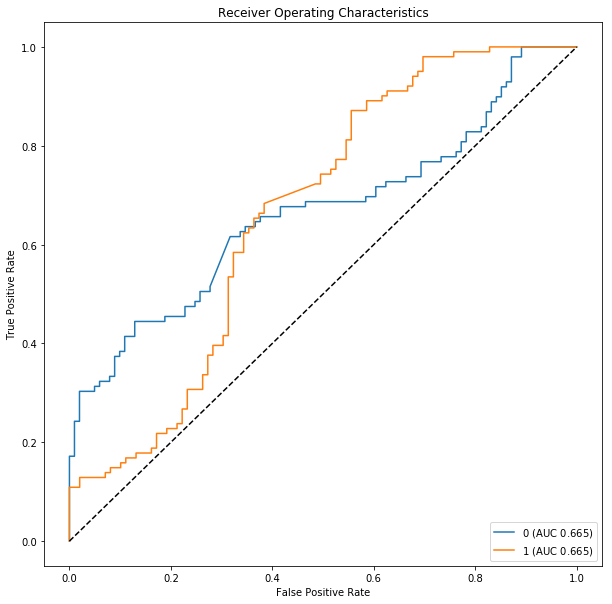

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


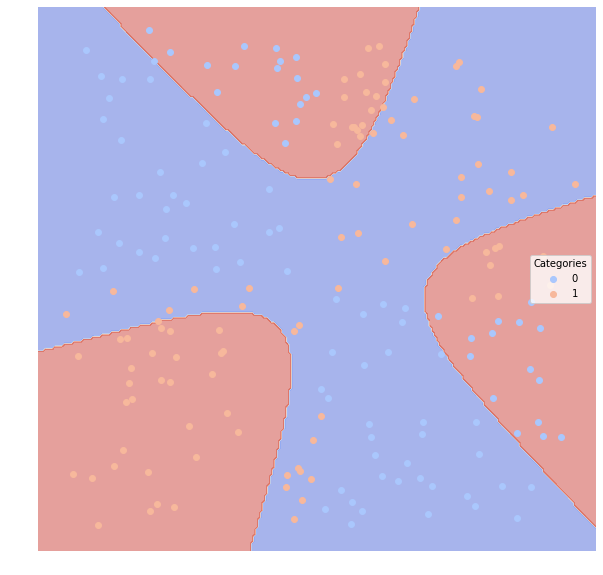

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.06  0.939994   0.939394           0.912461  0.939394
1               0.06  0.939994   0.940594           0.914717  0.940594


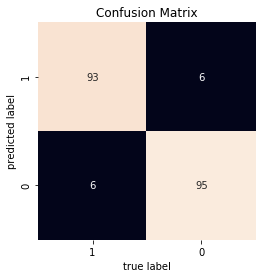

None


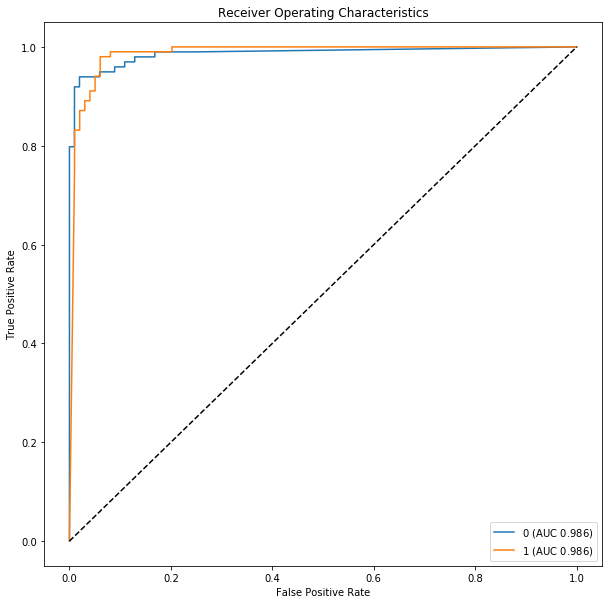

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


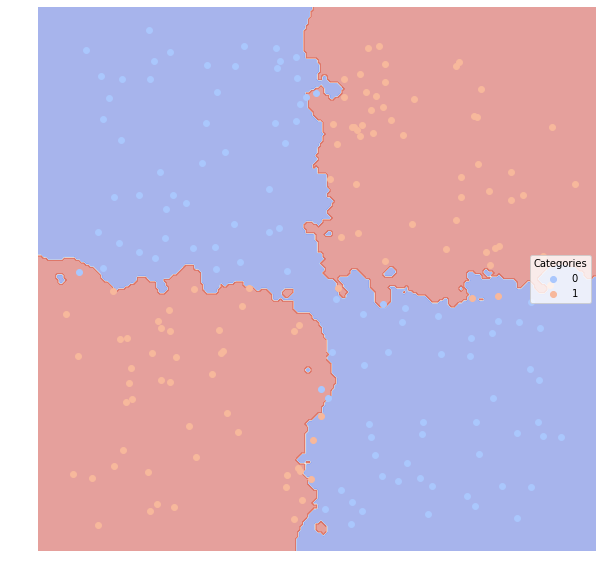

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.475  0.525503   0.518182           0.508347  0.575758
1              0.475  0.525503   0.533333           0.518465  0.475248


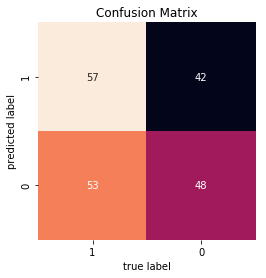

None


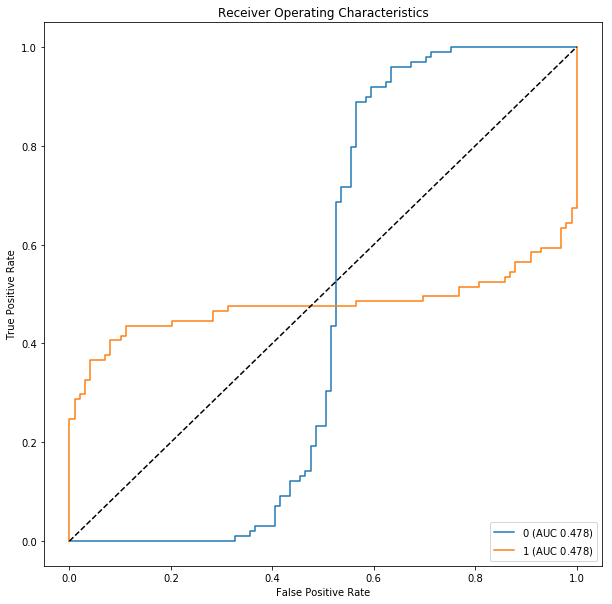

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


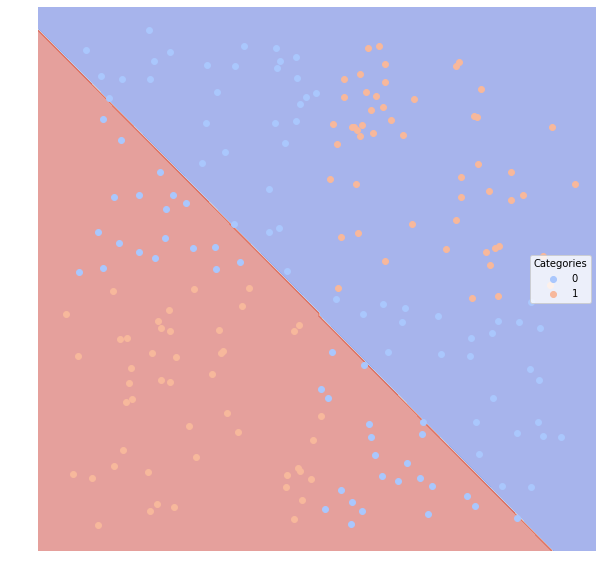

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.04  0.960296   0.933333           0.928906  0.989899
1               0.04  0.960296   0.989474           0.955896  0.930693


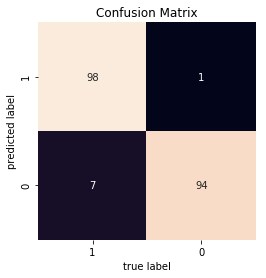

None


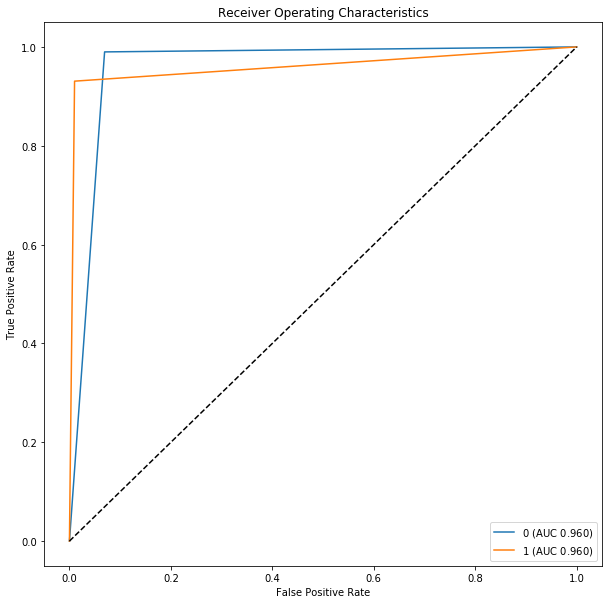

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


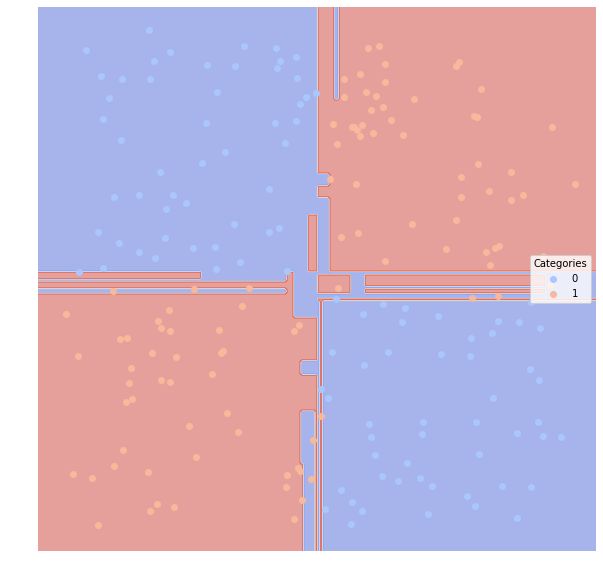

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision   Recall
Category                                                             
0               0.05  0.950495   0.908257           0.908257  1.00000
1               0.05  0.950495   1.000000           0.950990  0.90099


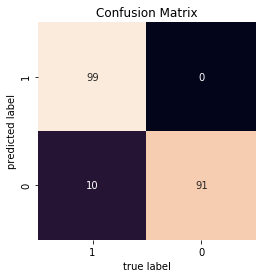

None


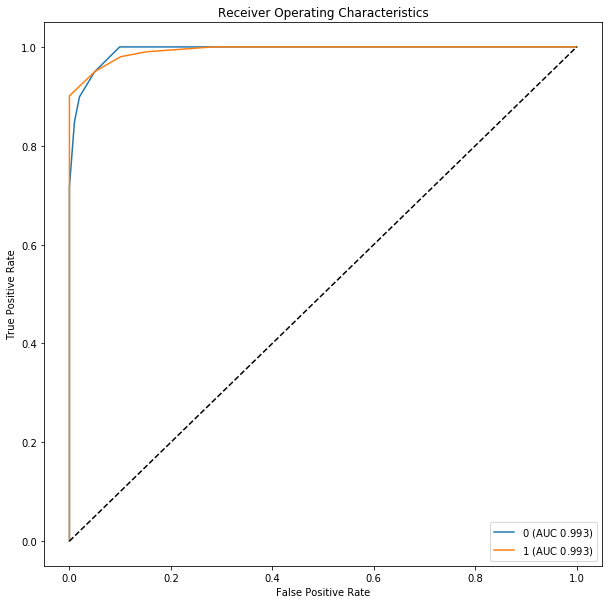

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


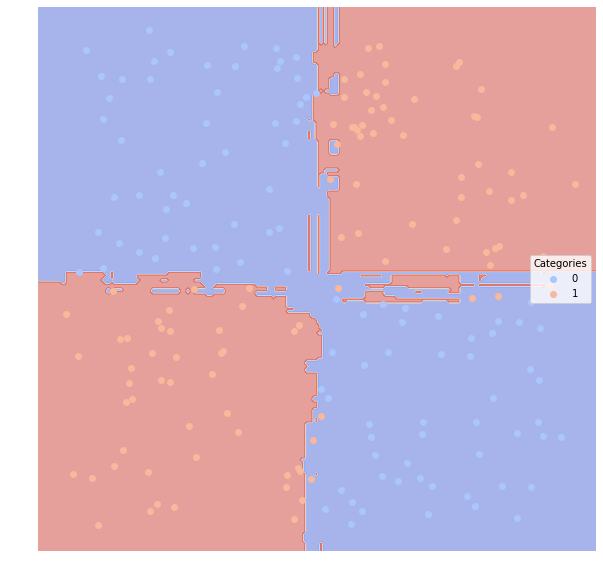

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.02  0.980198   0.961165           0.961165  1.000000
1               0.02  0.980198   1.000000           0.980396  0.960396


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


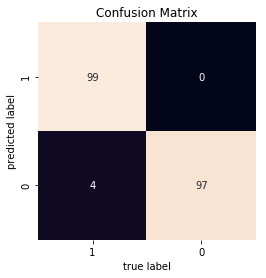

None


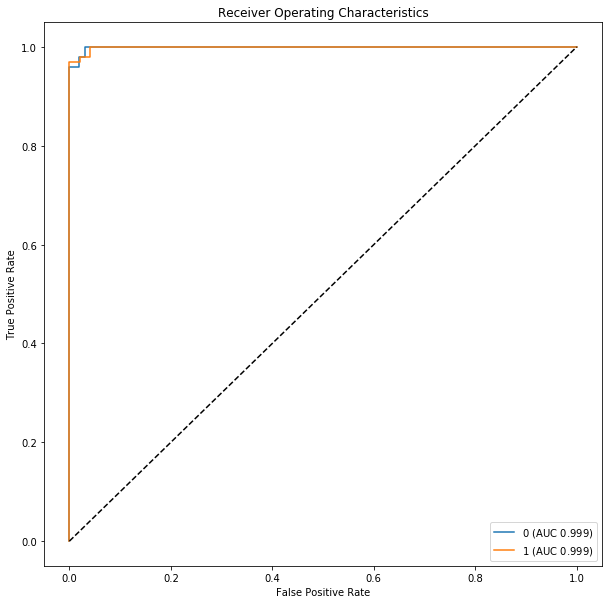

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


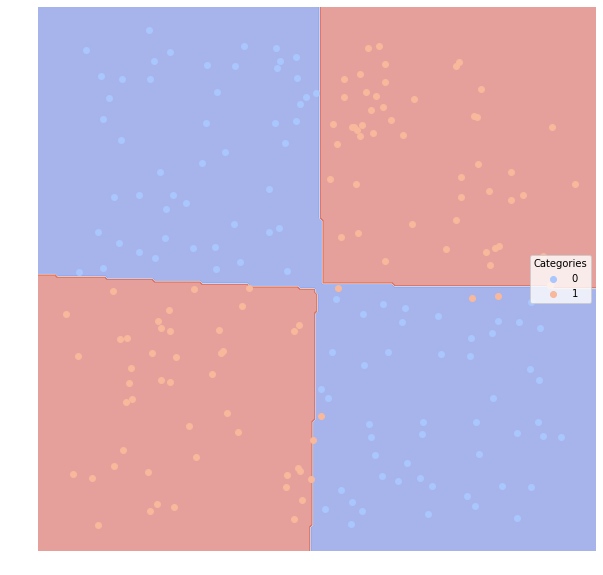

None
.........................................
.........................................
Dataset 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.035  0.965347   0.933962           0.933962  1.000000
1              0.035  0.965347   1.000000           0.965693  0.930693


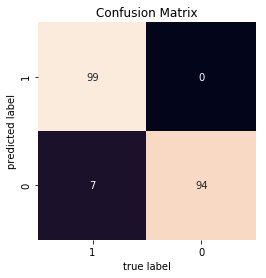

None


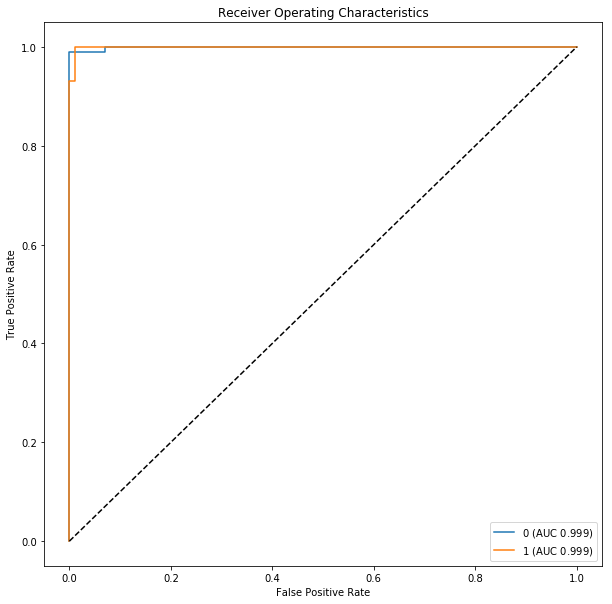

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


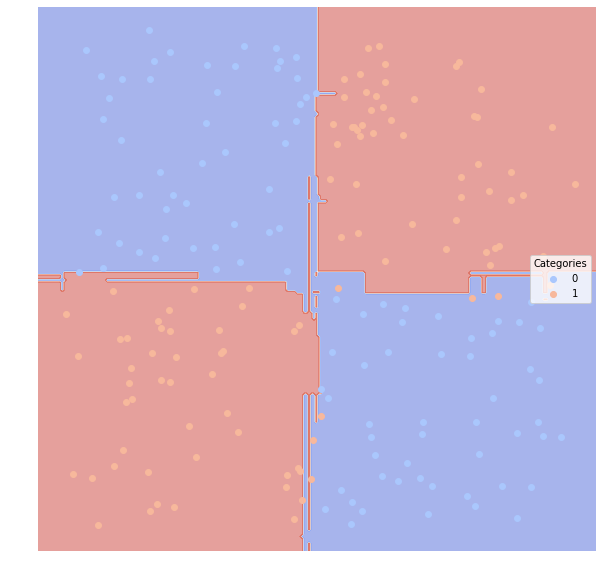

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.45  0.551683   0.527778           0.508368  0.593750
1               0.45  0.551683   0.576087           0.548583  0.509615


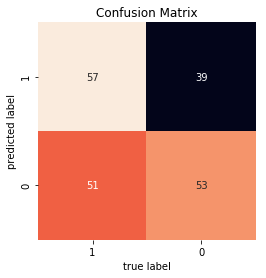

None


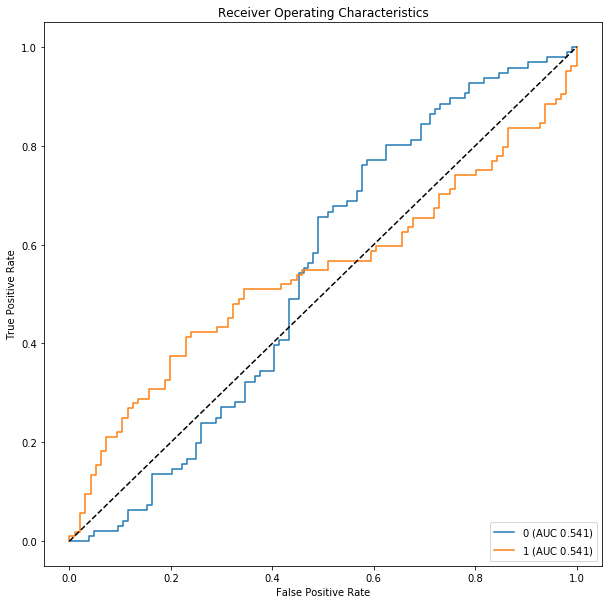

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


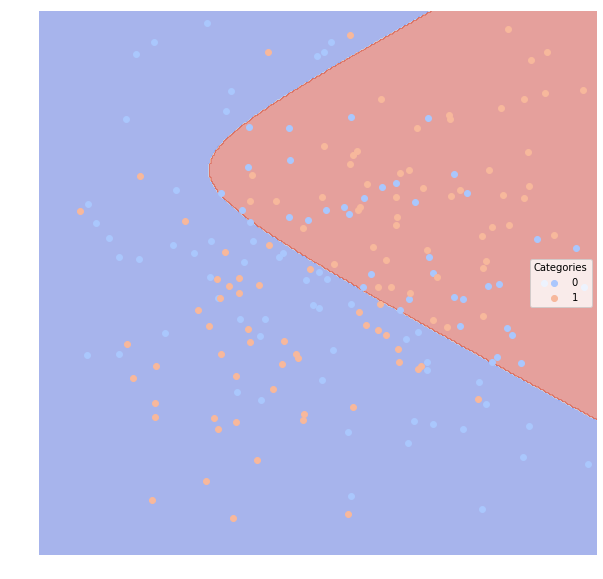

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.47  0.535256   0.507937           0.498624  0.666667
1               0.47  0.535256   0.567568           0.539210  0.403846


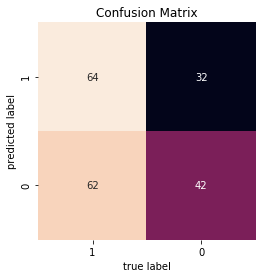

None


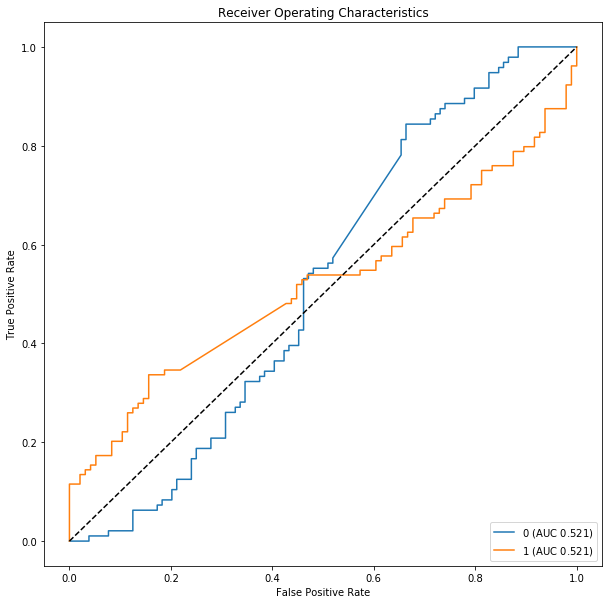

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


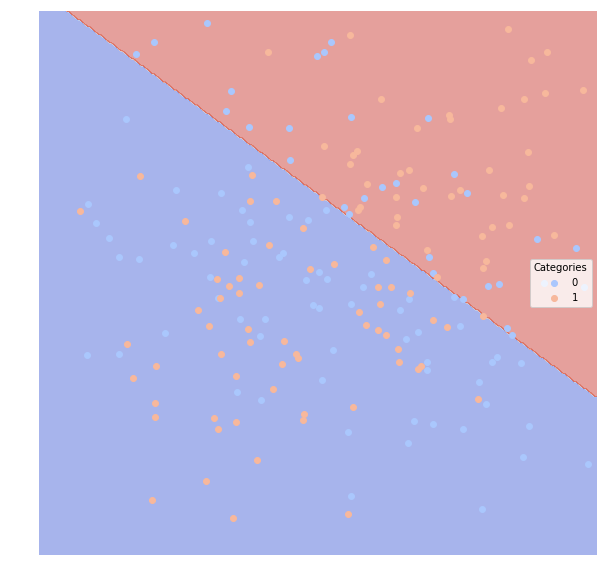

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.365  0.624199   0.755556           0.577593  0.354167
1              0.365  0.624199   0.600000           0.591538  0.894231


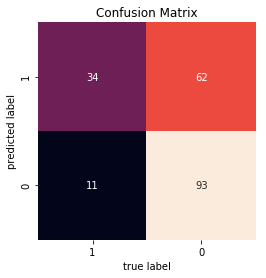

None


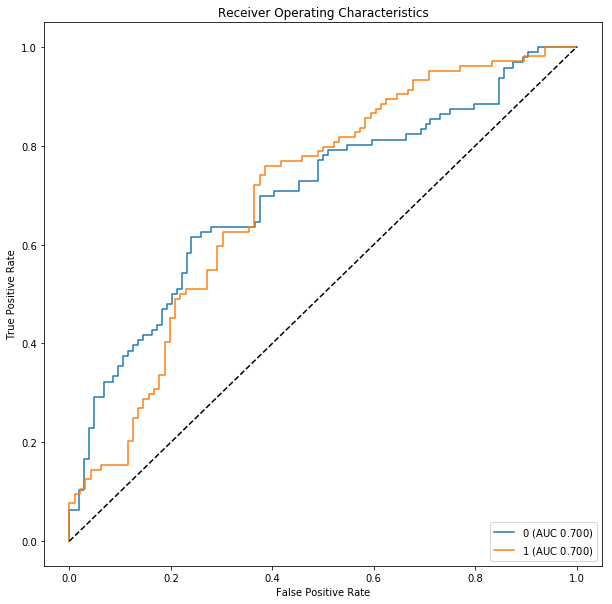

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


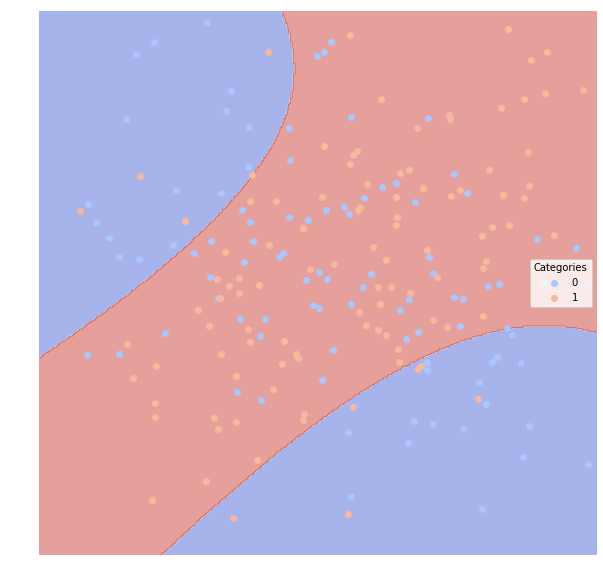

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.37  0.629407   0.614583           0.562713  0.614583
1               0.37  0.629407   0.644231           0.600033  0.644231


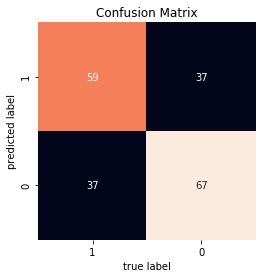

None


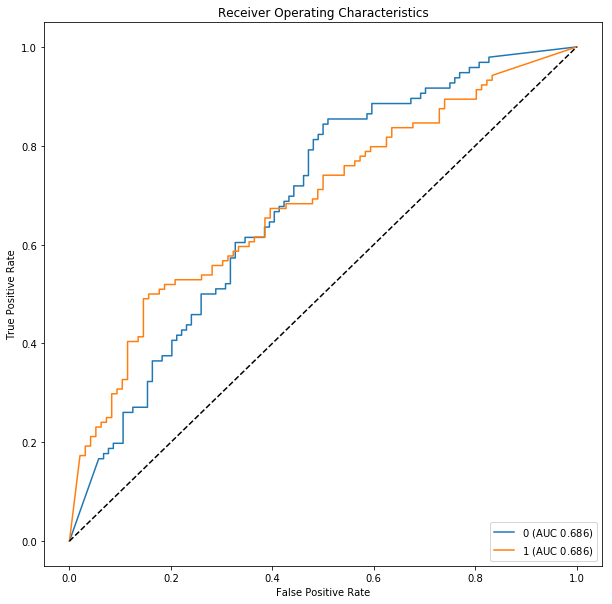

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


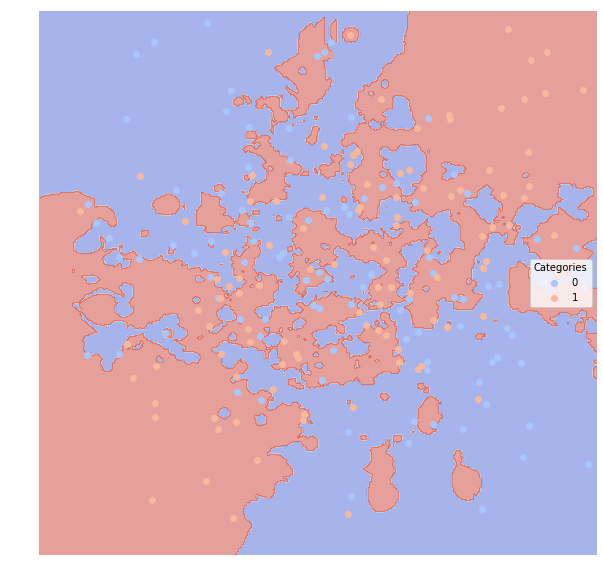

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.475  0.528446   0.504274           0.494918  0.614583
1              0.475  0.528446   0.554217           0.535134  0.442308


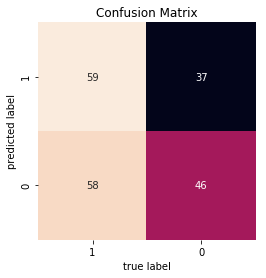

None


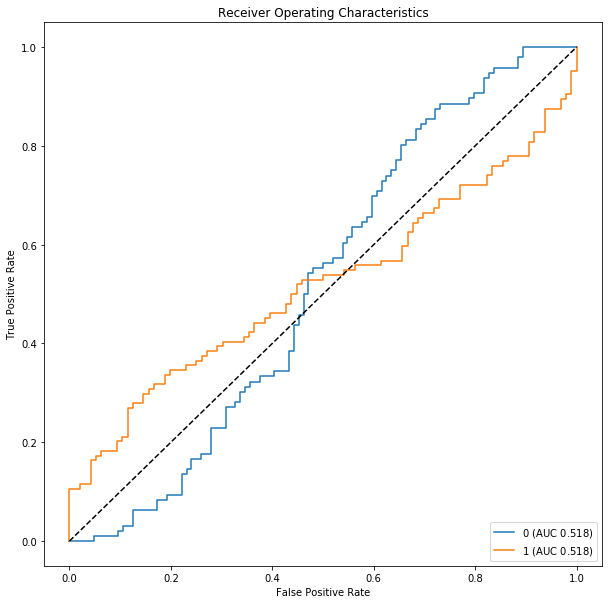

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


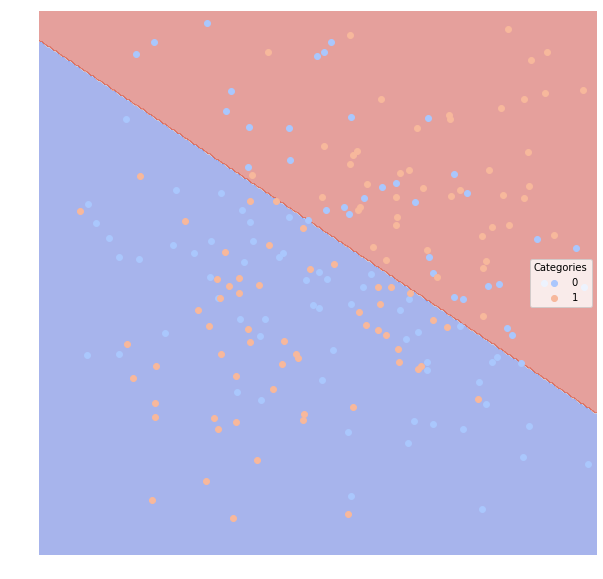

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.4  0.599359   0.583333           0.540278  0.583333
1                0.4  0.599359   0.615385           0.578698  0.615385


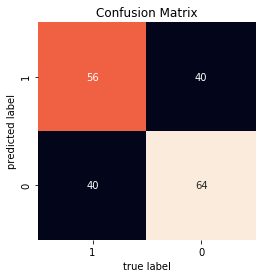

None


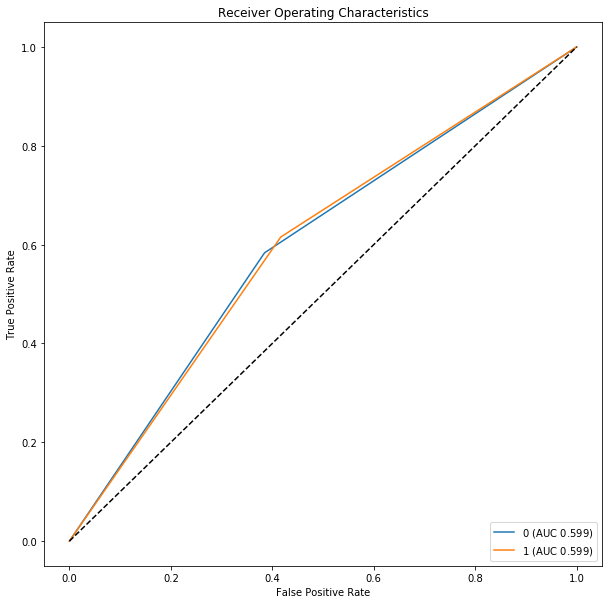

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


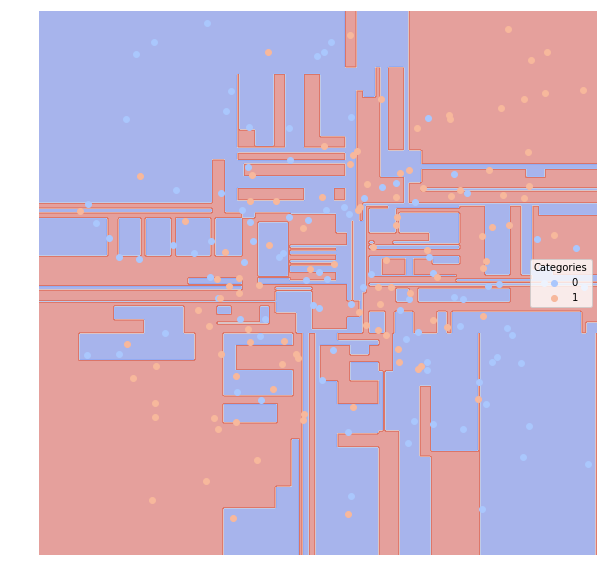

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.375  0.627003   0.596330           0.558765  0.677083
1              0.375  0.627003   0.659341           0.600389  0.576923


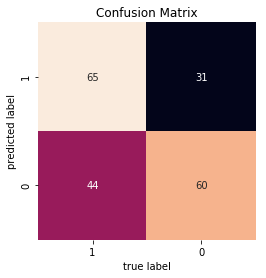

None


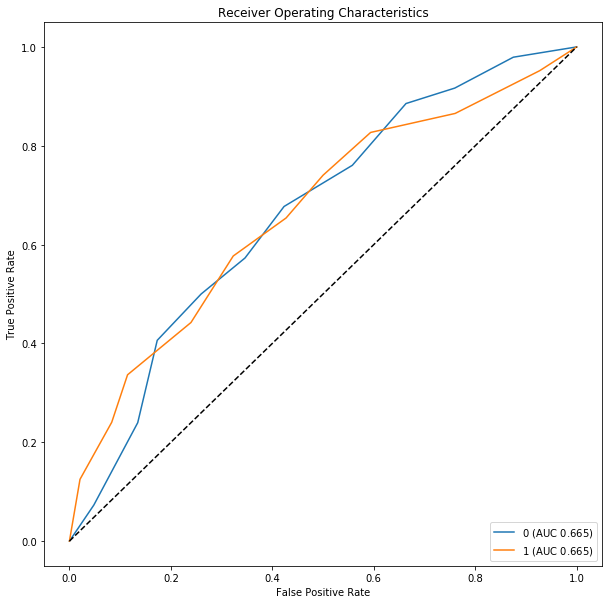

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


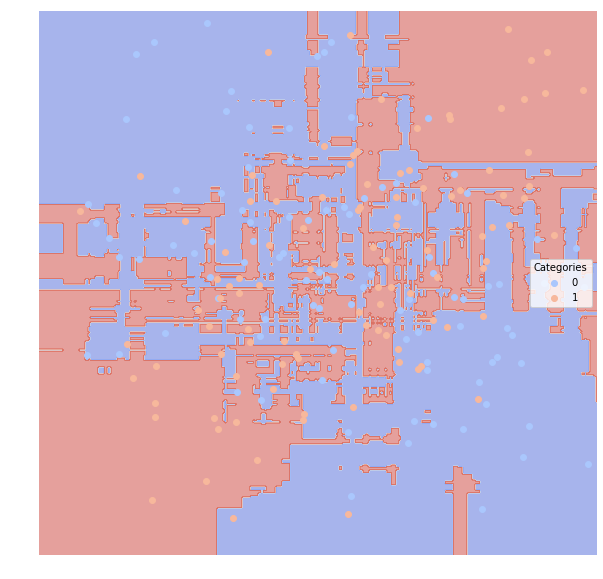

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.34  0.659054   0.648936           0.587345  0.635417
1               0.34  0.659054   0.669811           0.622275  0.682692


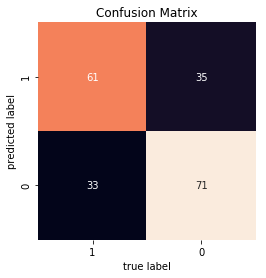

None


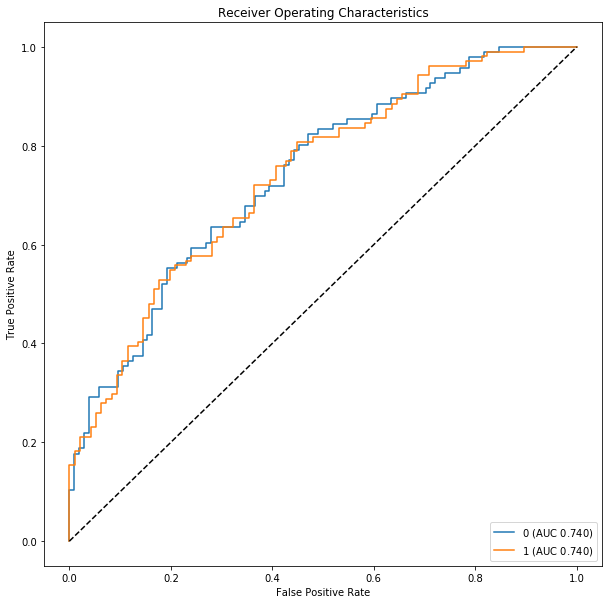

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


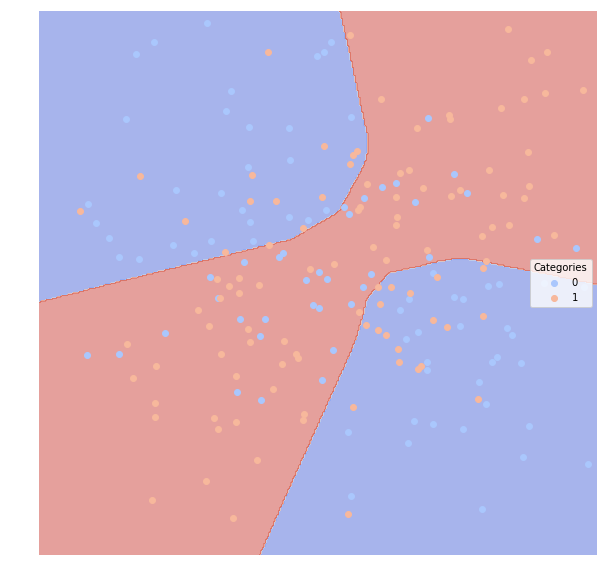

None
.........................................
.........................................
Dataset 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.365  0.635817   0.611650           0.566396  0.656250
1              0.365  0.635817   0.659794           0.606027  0.615385


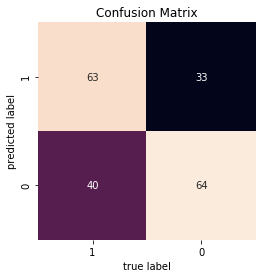

None


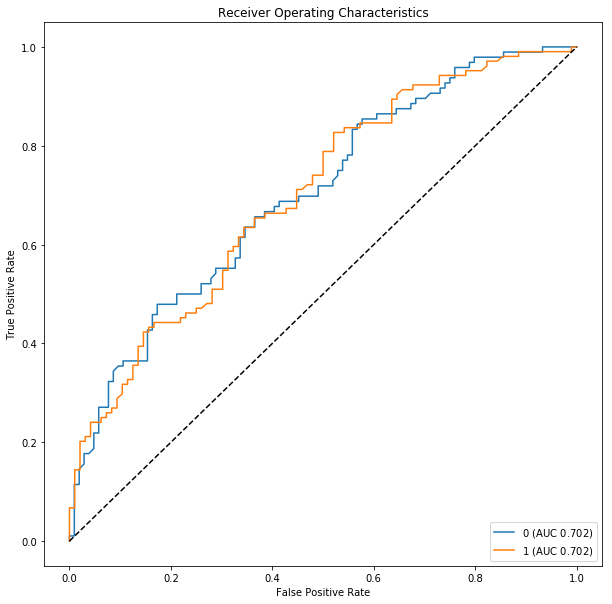

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


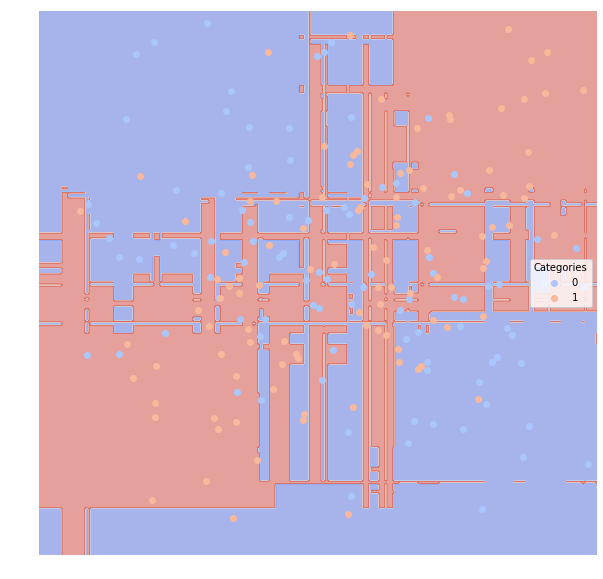

None
.........................................
.........................................
Dataset 7
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.03  0.969551   0.962264           0.953759  0.980769
1               0.03  0.969551   0.978723           0.957943  0.958333


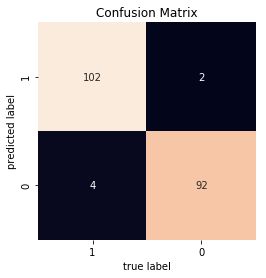

None


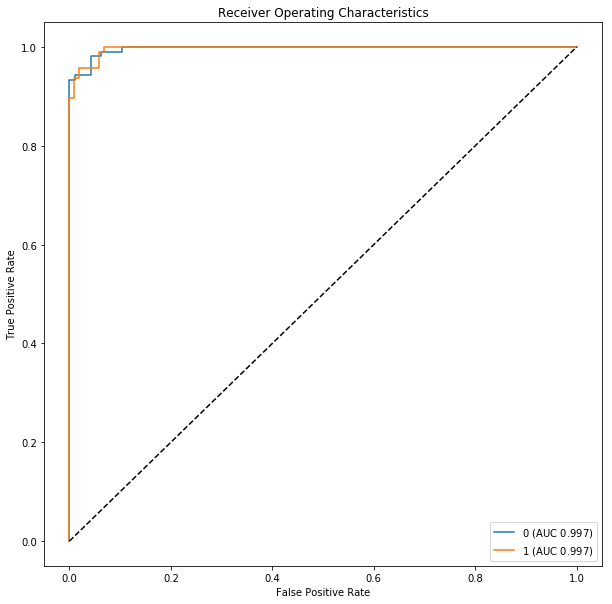

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


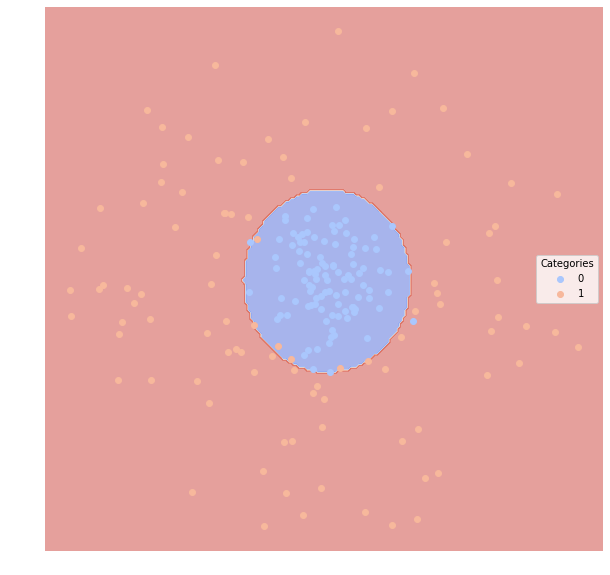

None
.........................................
.........................................
Dataset 7
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0               0.52  0.5       0.00               0.52     0.0
1               0.52  0.5       0.48               0.48     1.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


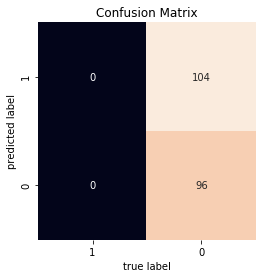

None


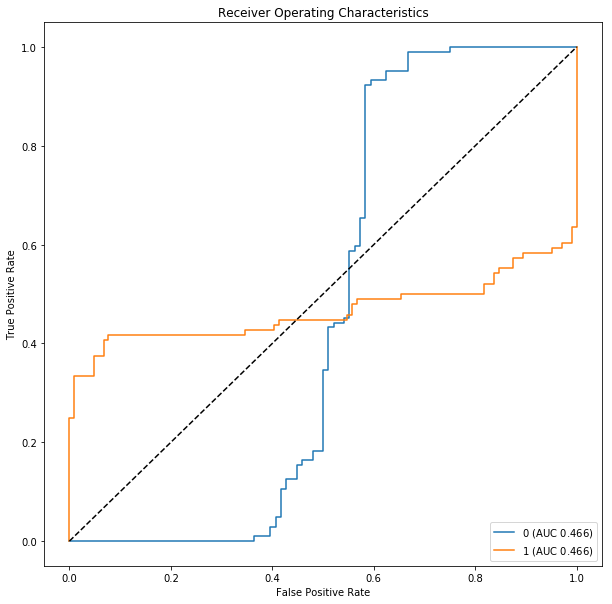

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


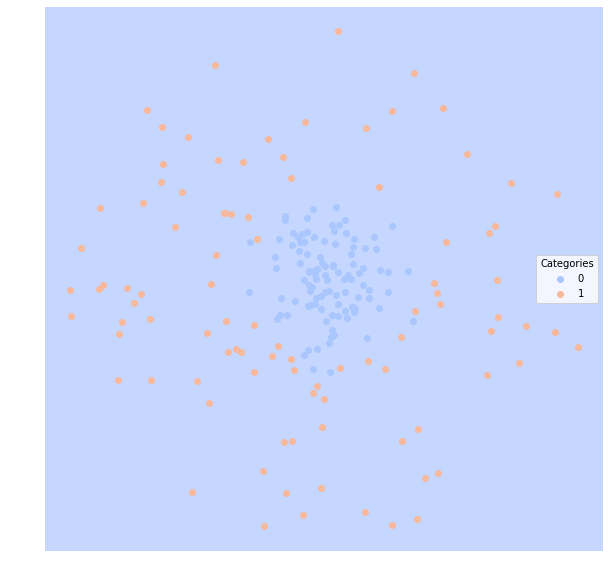

None
.........................................
.........................................
Dataset 7
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0               0.52  0.5       0.00               0.52     0.0
1               0.52  0.5       0.48               0.48     1.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


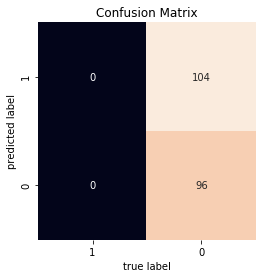

None


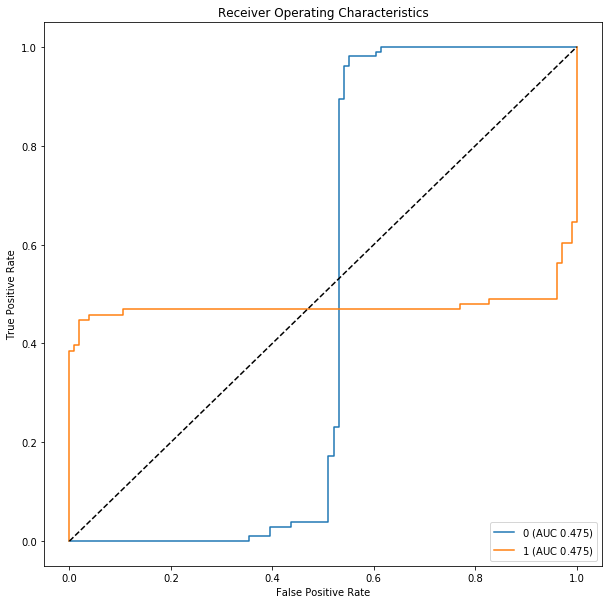

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


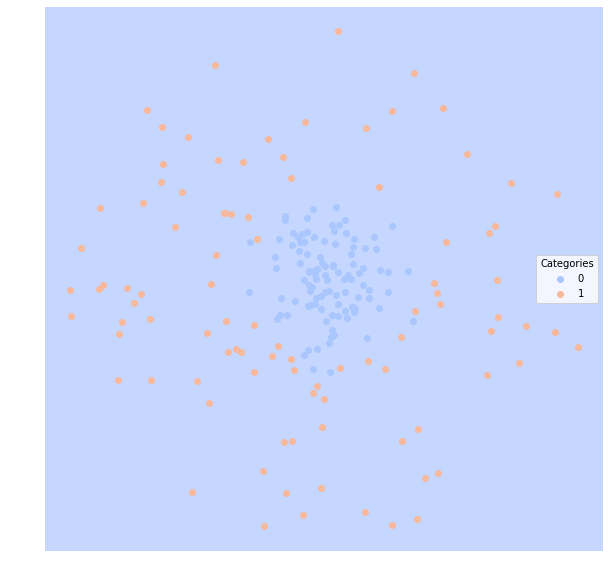

None
.........................................
.........................................
Dataset 7
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.04  0.959936   0.961538           0.944556  0.961538
1               0.04  0.959936   0.958333           0.938403  0.958333


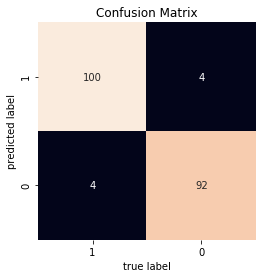

None


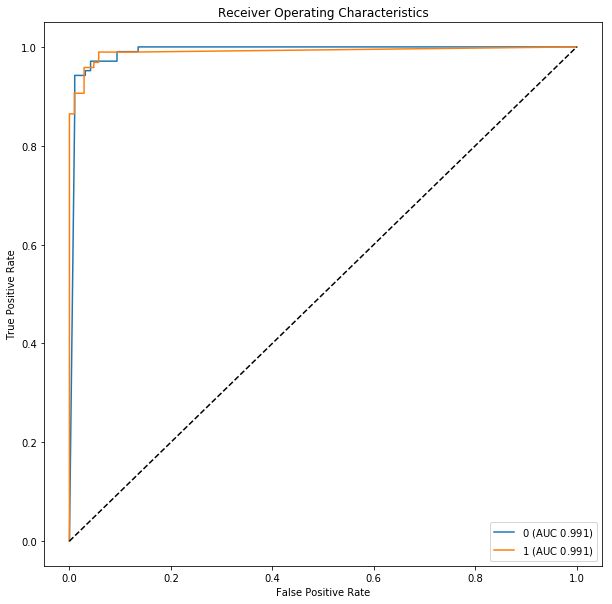

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


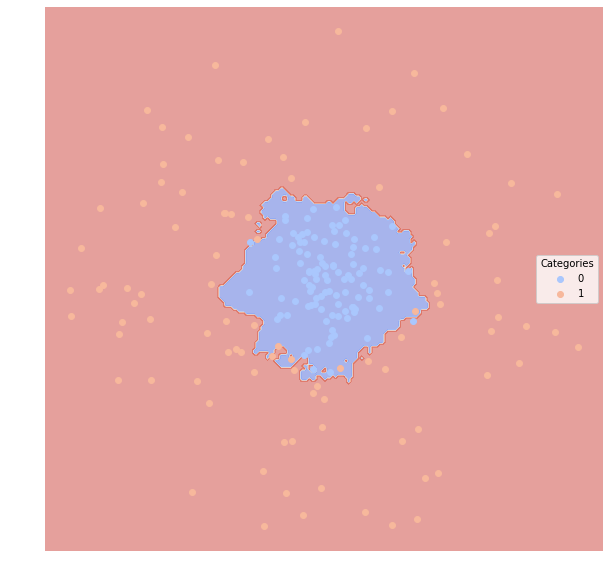

None
.........................................
.........................................
Dataset 7
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.66  0.34976       0.22           0.488269  0.105769
1               0.66  0.34976       0.38           0.420625  0.593750


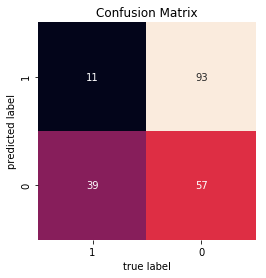

None


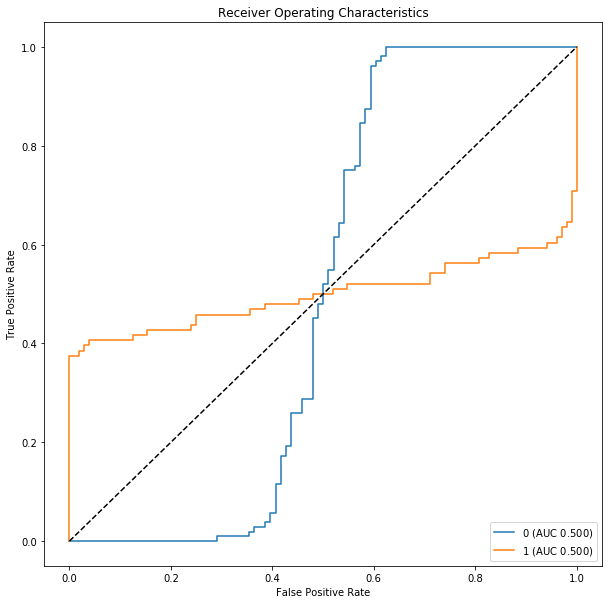

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


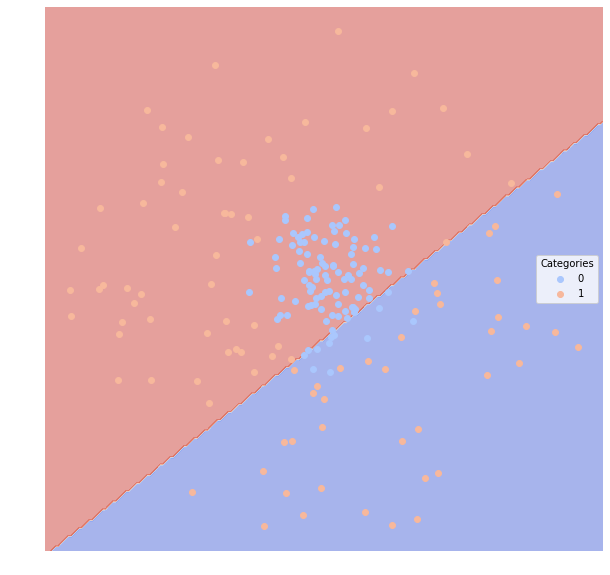

None
.........................................
.........................................
Dataset 7
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.05  0.949519   0.943396           0.927112  0.961538
1               0.05  0.949519   0.957447           0.927606  0.937500


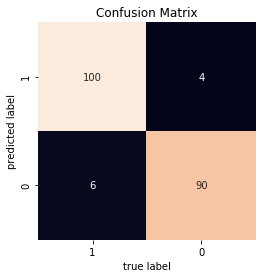

None


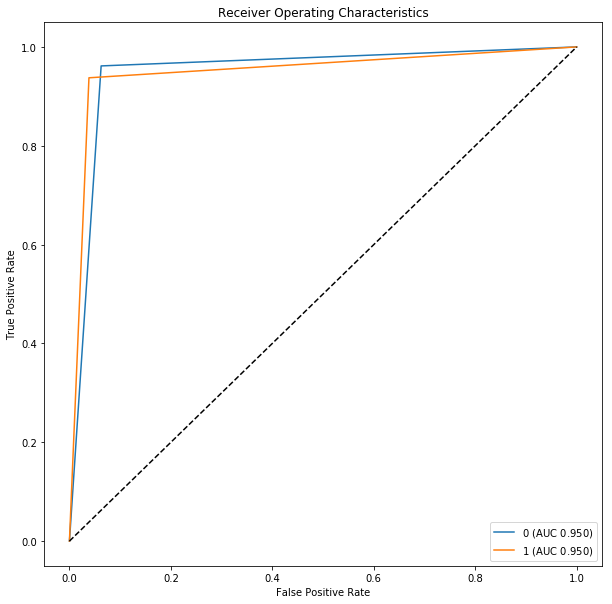

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


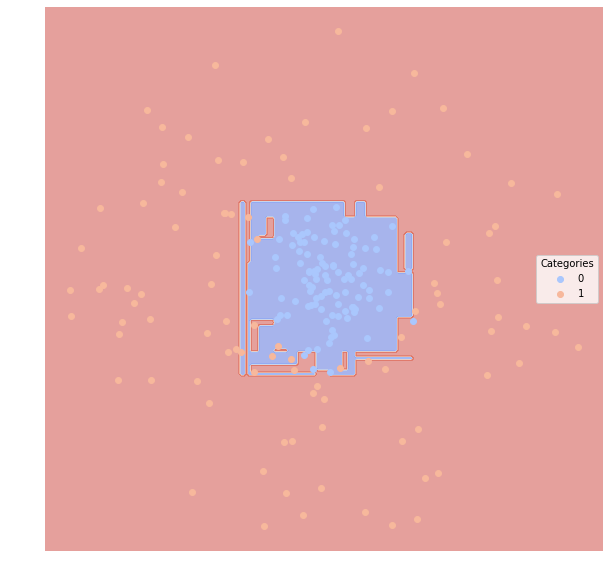

None
.........................................
.........................................
Dataset 7
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.03  0.969551   0.962264           0.953759  0.980769
1               0.03  0.969551   0.978723           0.957943  0.958333


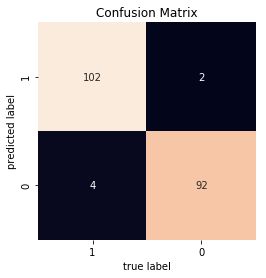

None


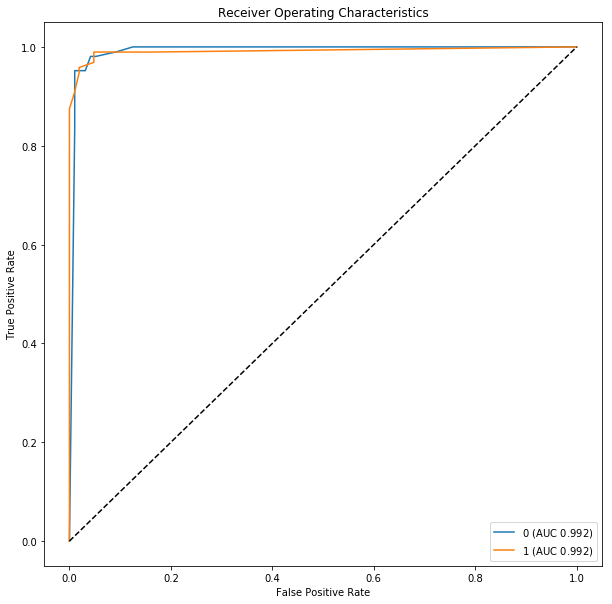

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


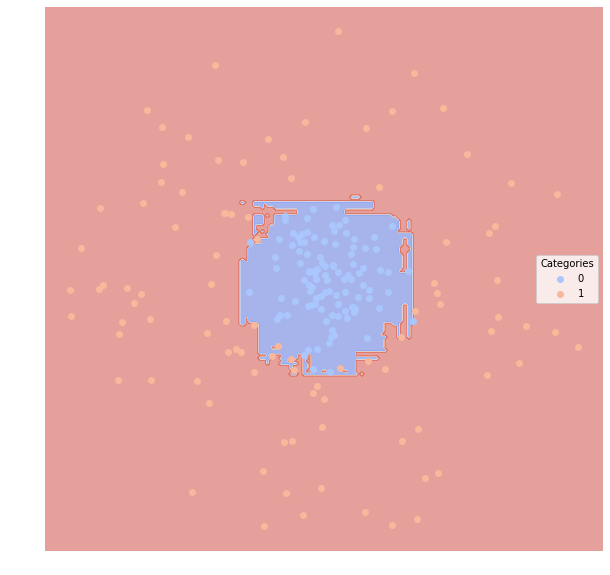

None
.........................................
.........................................
Dataset 7
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.055  0.943109   0.911504           0.907740  0.990385
1              0.055  0.943109   0.988506           0.935536  0.895833


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


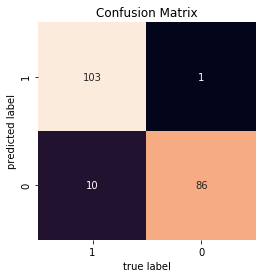

None


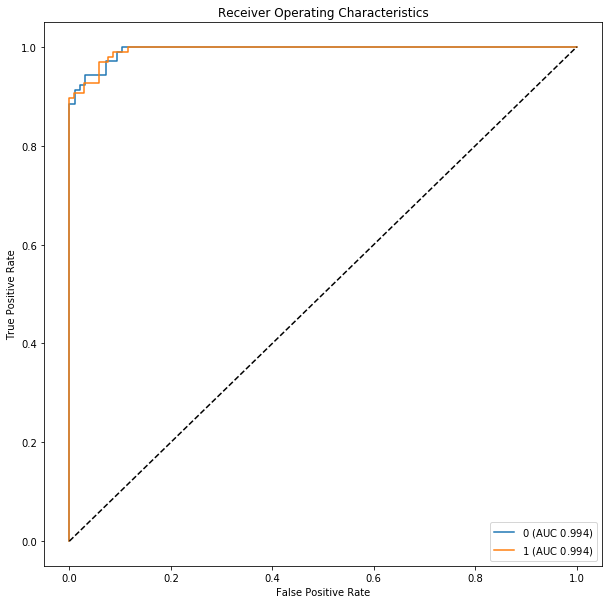

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


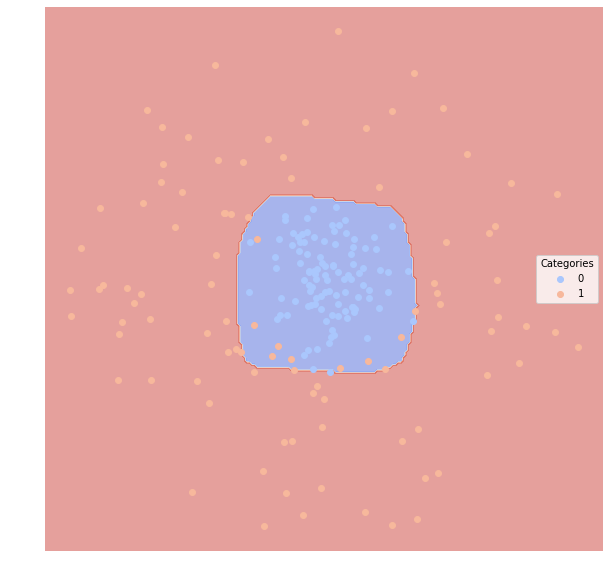

None
.........................................
.........................................
Dataset 7
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.025  0.974359   0.962617           0.958361  0.990385
1              0.025  0.974359   0.989247           0.968029  0.958333


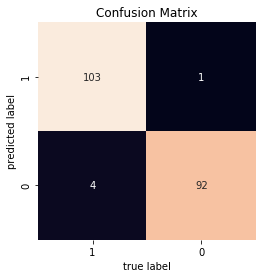

None


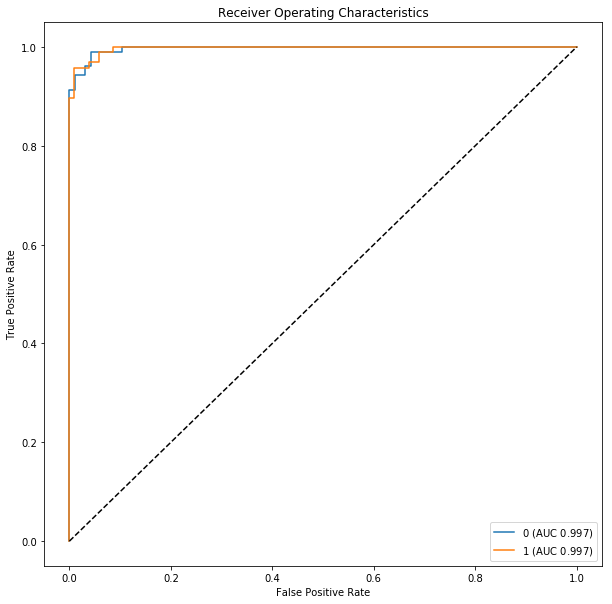

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


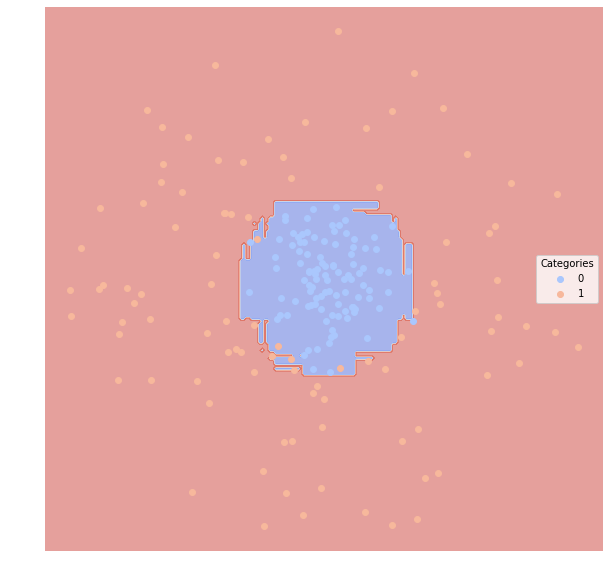

None
.........................................
.........................................
Dataset 8
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.49  0.51402   0.569892           0.562111  0.477477
1               0.49  0.51402   0.457944           0.452126  0.550562


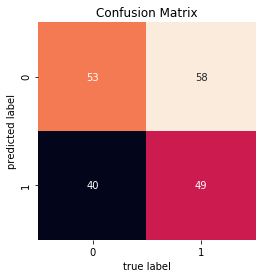

None


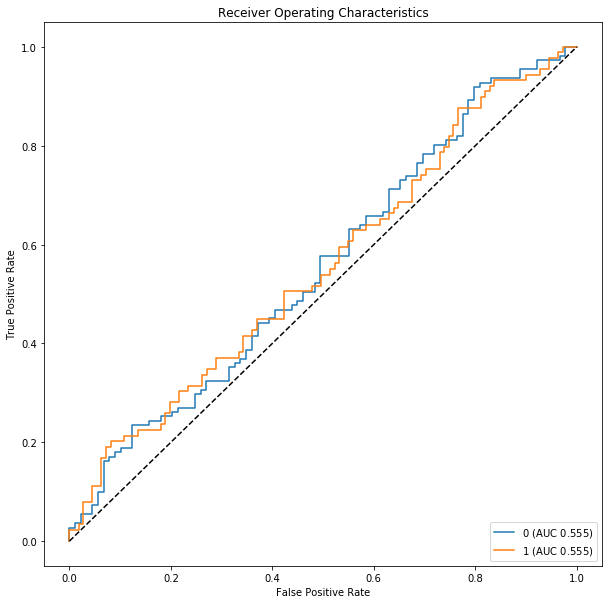

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


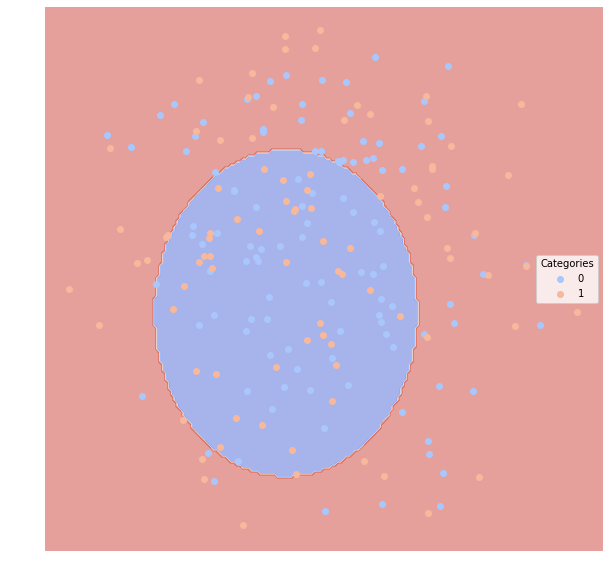

None
.........................................
.........................................
Dataset 8
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.555  0.5      0.000              0.555     0.0
1              0.555  0.5      0.445              0.445     1.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


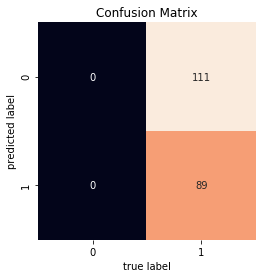

None


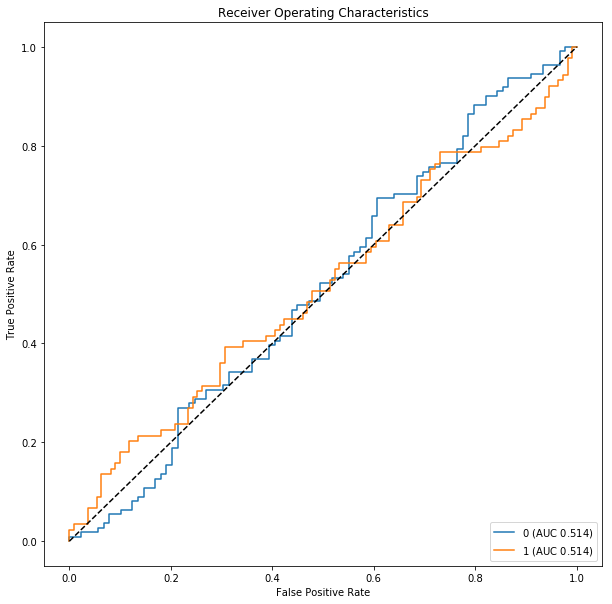

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


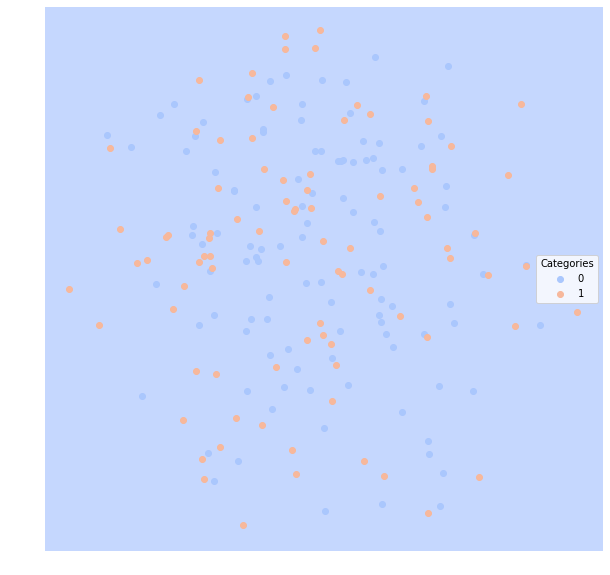

None
.........................................
.........................................
Dataset 8
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.555  0.5      0.000              0.555     0.0
1              0.555  0.5      0.445              0.445     1.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


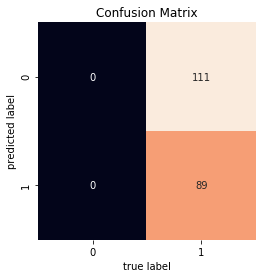

None


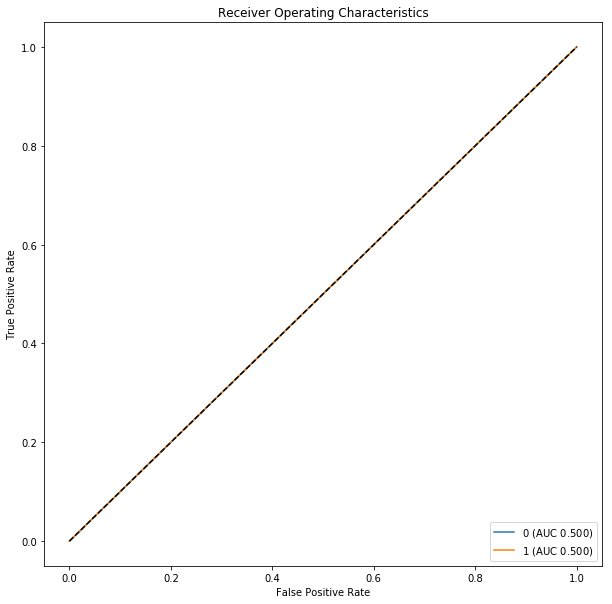

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


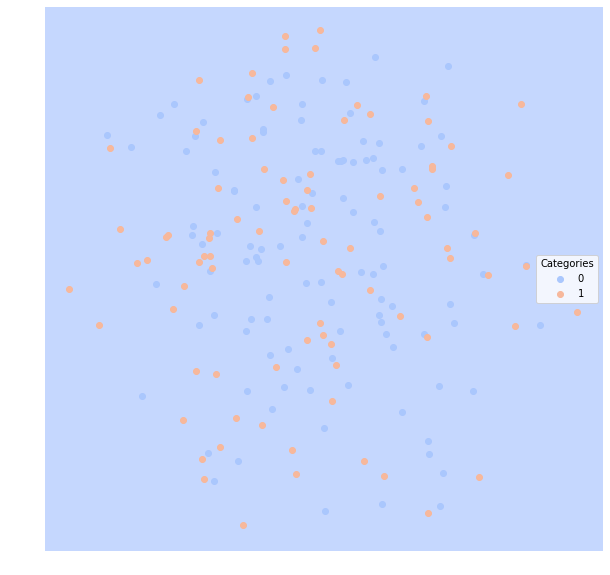

None
.........................................
.........................................
Dataset 8
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.435  0.576931   0.650000           0.599505  0.468468
1              0.435  0.576931   0.508333           0.488408  0.685393


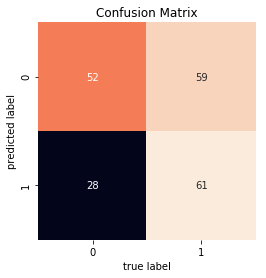

None


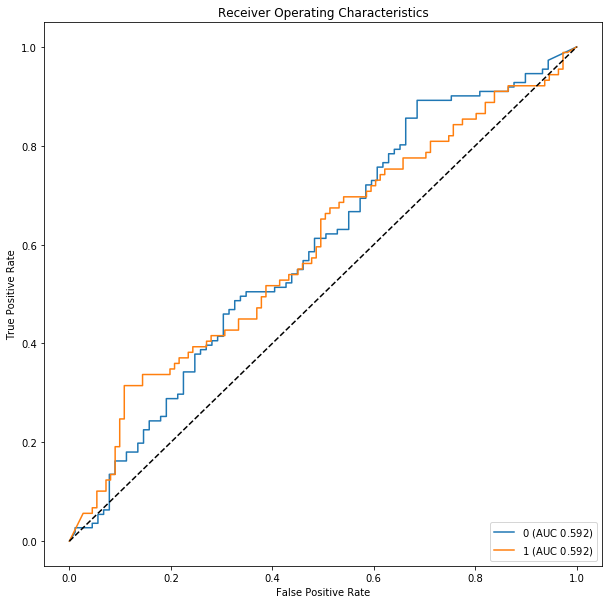

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


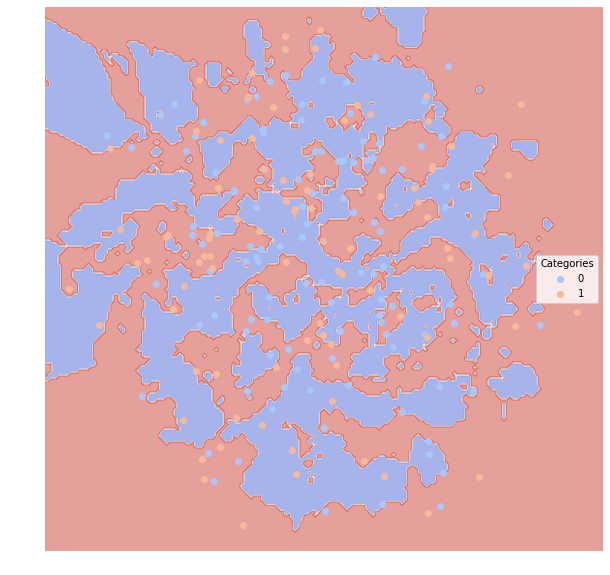

None
.........................................
.........................................
Dataset 8
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.57  0.449742   0.476190           0.533700  0.270270
1               0.57  0.449742   0.408759           0.422197  0.629213


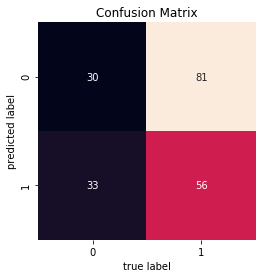

None


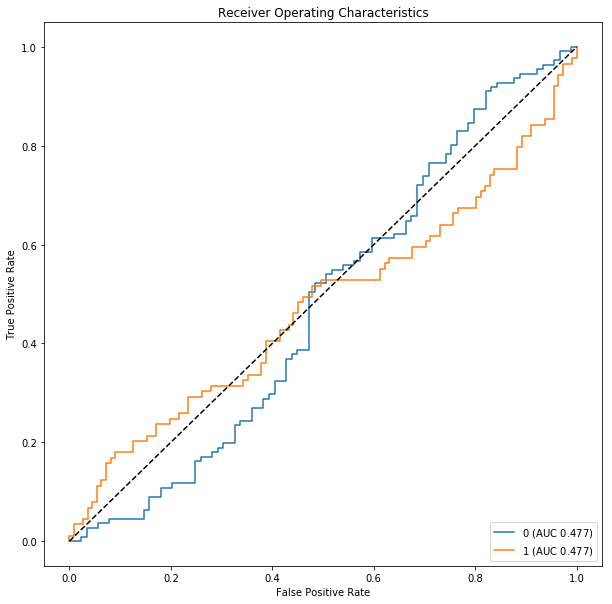

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


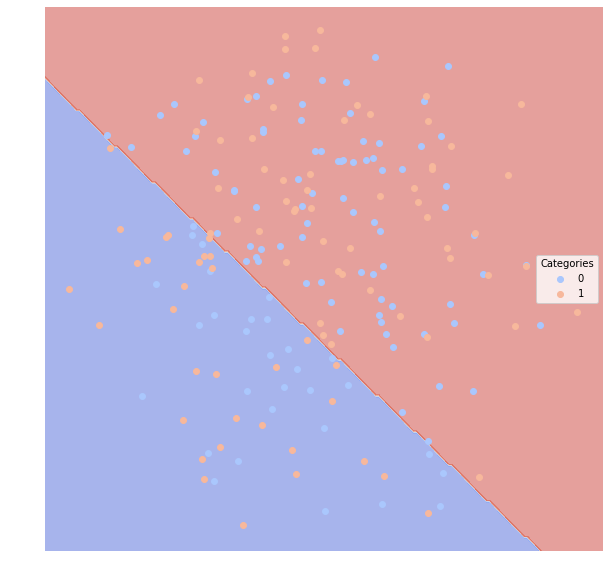

None
.........................................
.........................................
Dataset 8
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.49  0.51402   0.569892           0.562111  0.477477
1               0.49  0.51402   0.457944           0.452126  0.550562


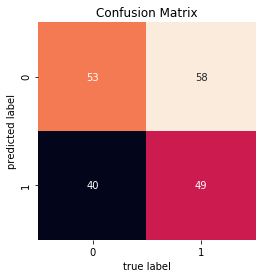

None


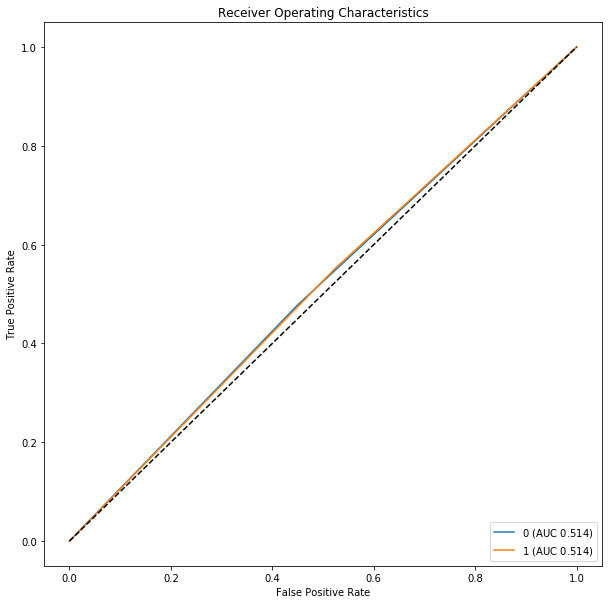

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


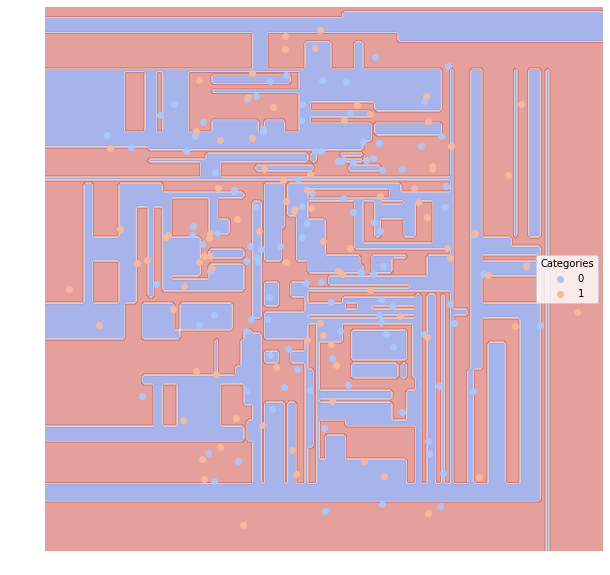

None
.........................................
.........................................
Dataset 8
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.49  0.508452   0.563107           0.559236  0.522523
1               0.49  0.508452   0.453608           0.449256  0.494382


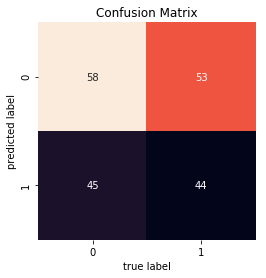

None


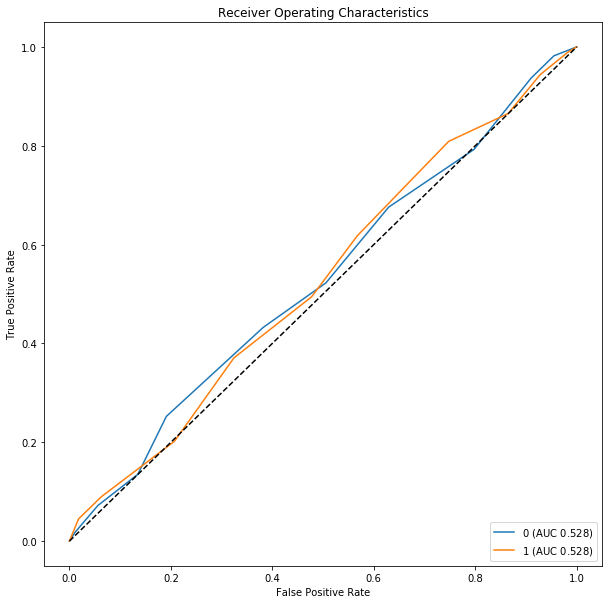

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


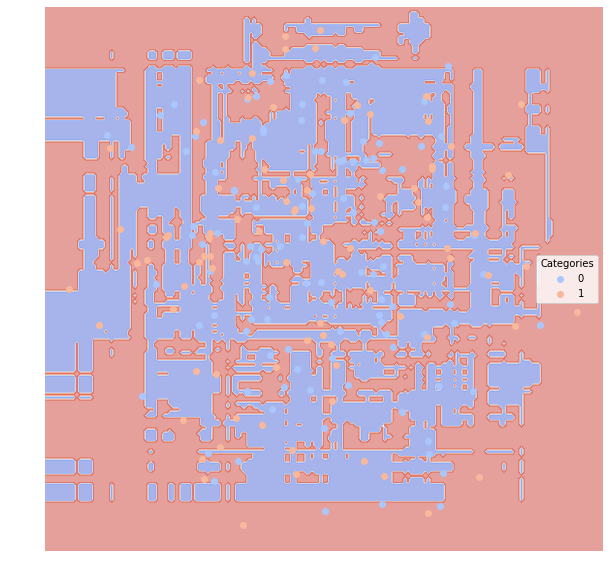

None
.........................................
.........................................
Dataset 8
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.517411   0.572917           0.563878  0.495495
1              0.485  0.517411   0.461538           0.453920  0.539326


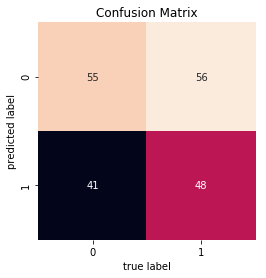

None


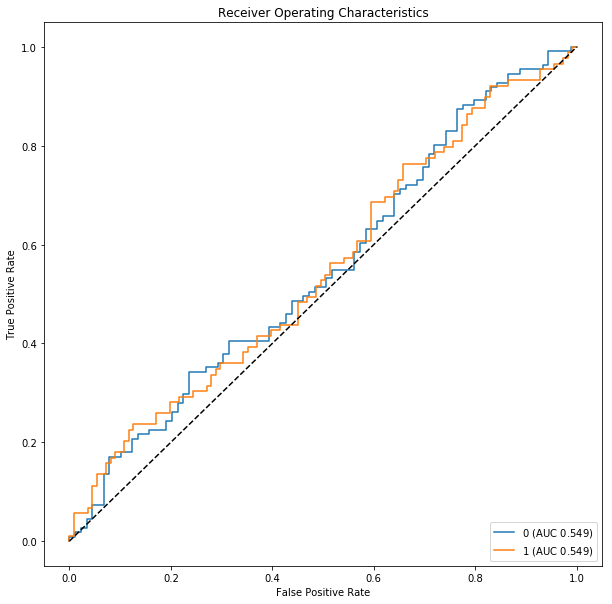

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


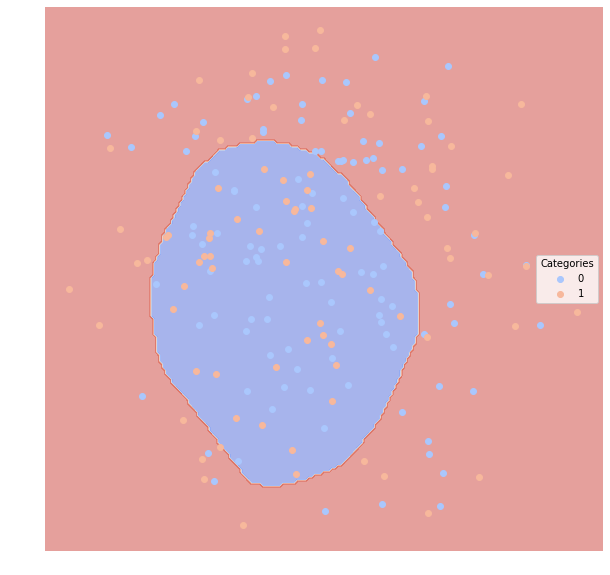

None
.........................................
.........................................
Dataset 8
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.509616   0.563636           0.559824  0.558559
1              0.485  0.509616   0.455556           0.449863  0.460674


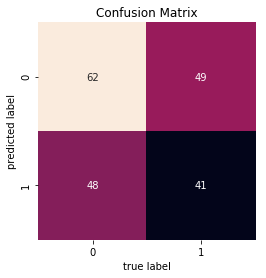

None


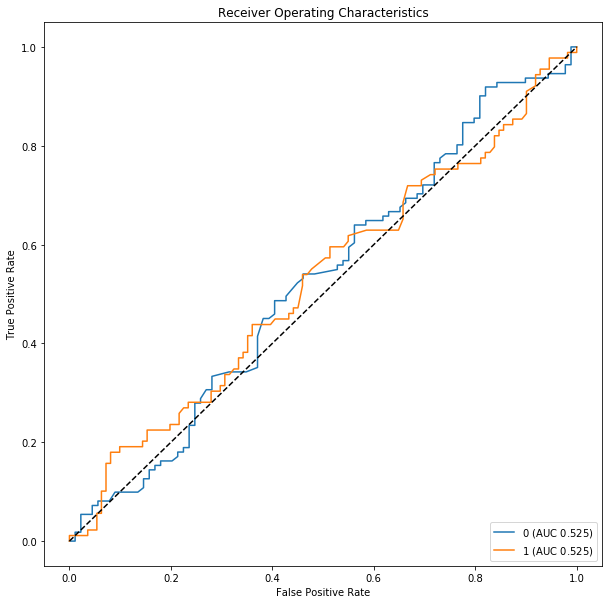

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


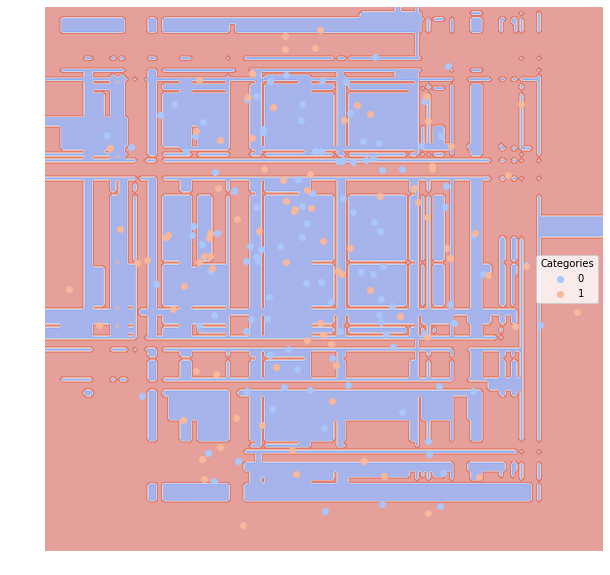

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.002  0.994444   1.000000           0.990889  0.988889
2              0.010  0.985454   0.967742           0.950704  0.978261
3              0.008  0.989035   0.983333           0.970944  0.983333
4              0.000  1.000000   1.000000           1.000000  1.000000


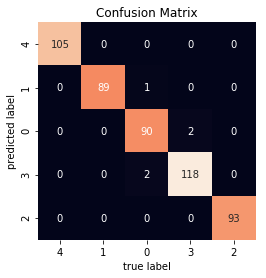

None


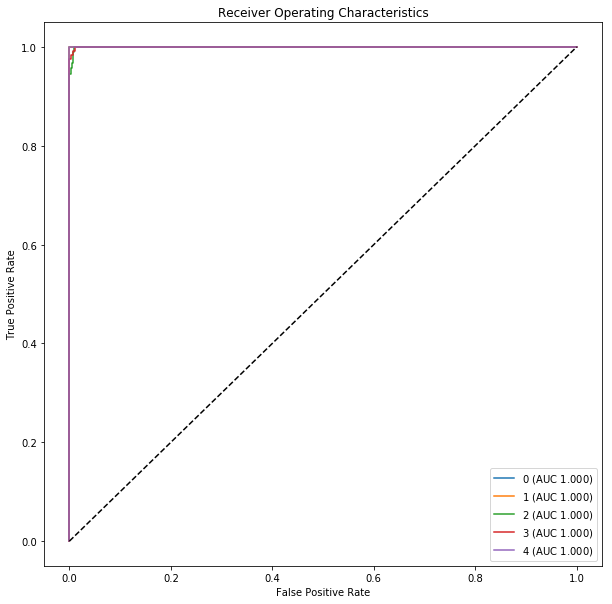

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

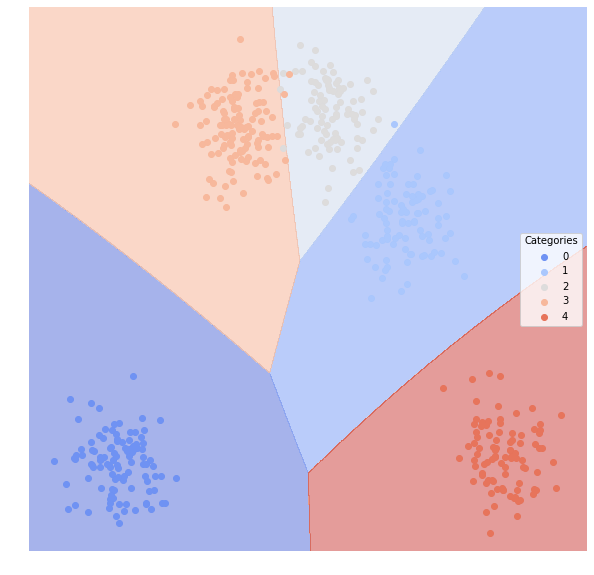

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.008  0.986679   0.978261           0.960994  0.978261
3              0.008  0.989035   0.983333           0.970944  0.983333
4              0.000  1.000000   1.000000           1.000000  1.000000


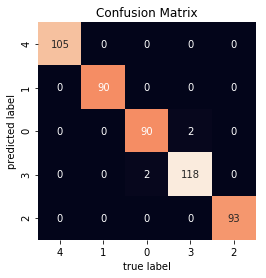

None


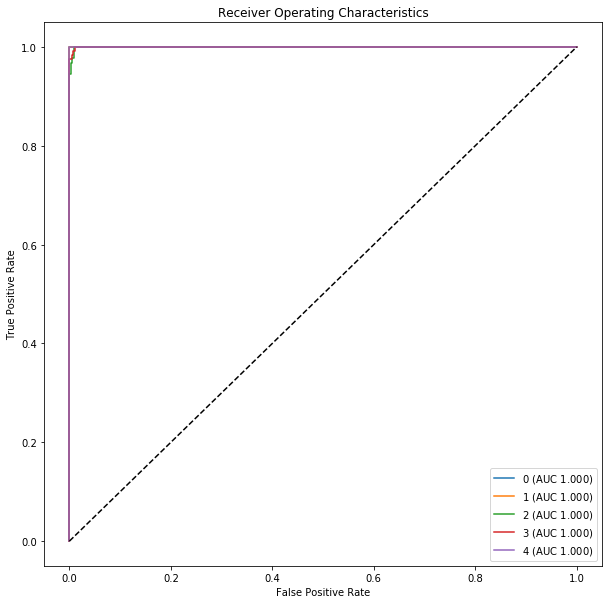

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

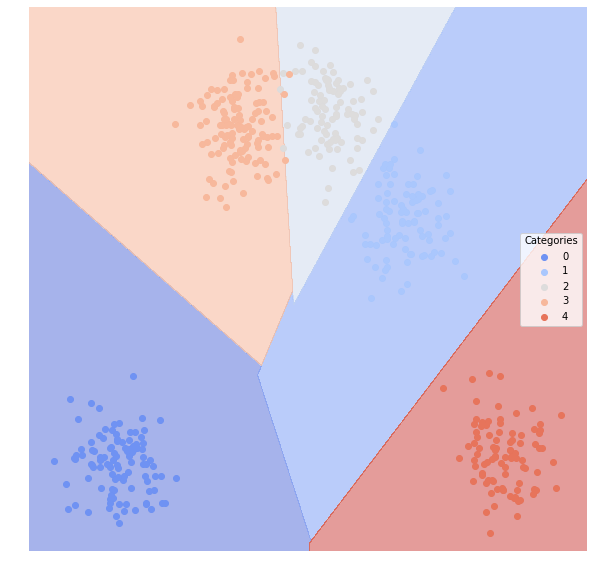

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision  Recall
Category                                                            
0              0.000  1.000000   1.000000           1.000000   1.000
1              0.000  1.000000   1.000000           1.000000   1.000
2              0.006  0.996324   0.968421           0.968421   1.000
3              0.006  0.987500   1.000000           0.981000   0.975
4              0.000  1.000000   1.000000           1.000000   1.000


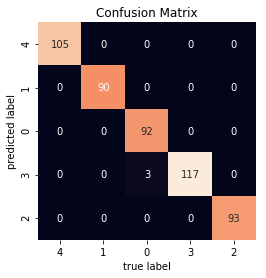

None


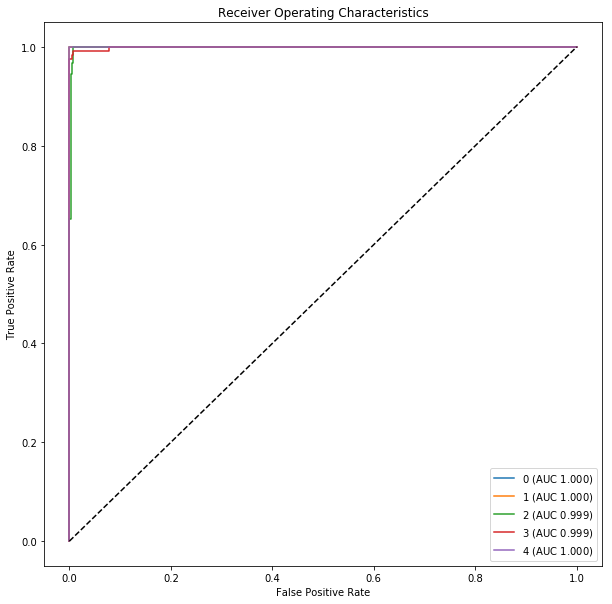

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

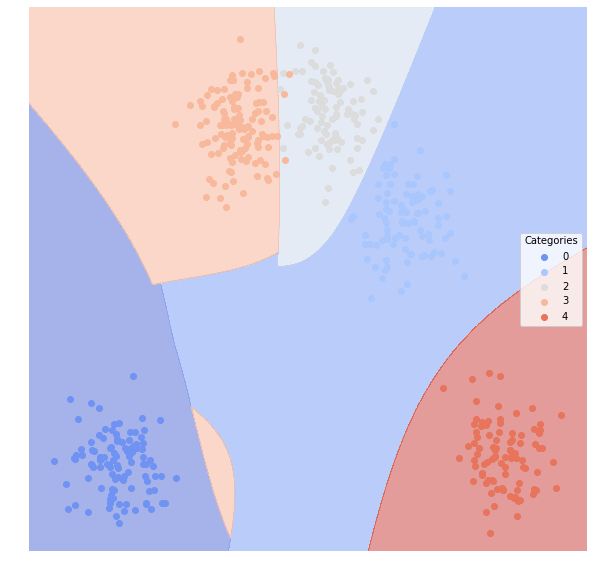

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.002  0.994444   1.000000           0.990889  0.988889
2              0.010  0.989663   0.957895           0.949483  0.989130
3              0.008  0.986184   0.991525           0.972737  0.975000
4              0.000  1.000000   1.000000           1.000000  1.000000


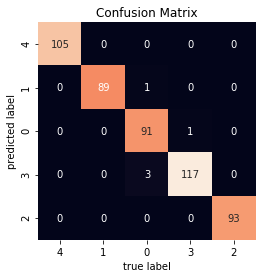

None


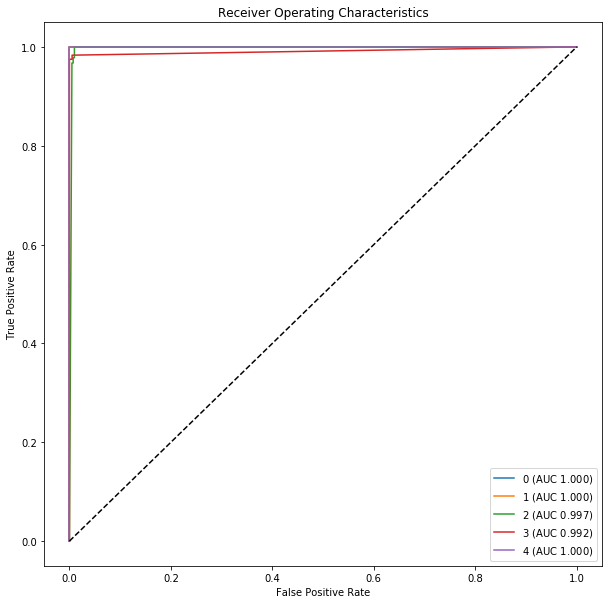

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

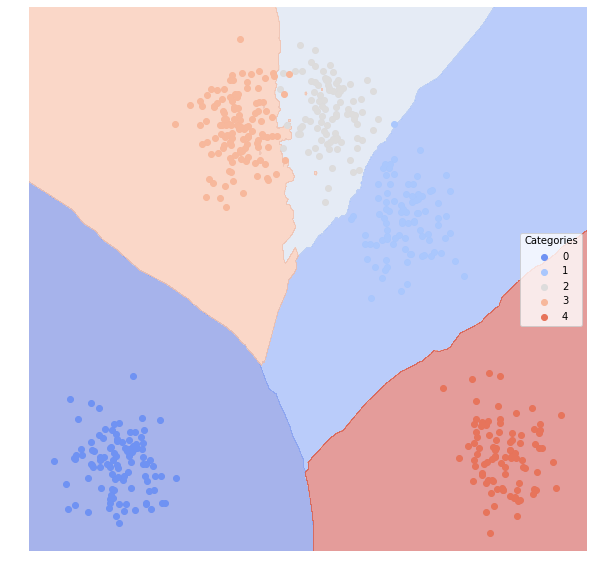

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.012  0.975339   0.977273           0.941838  0.955556
2              0.022  0.961264   0.945055           0.895421  0.934783
3              0.010  0.990570   0.967480           0.961417  0.991667
4              0.000  1.000000   1.000000           1.000000  1.000000


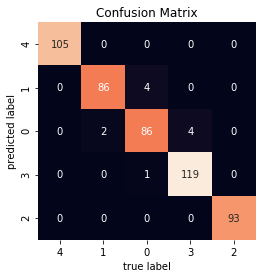

None


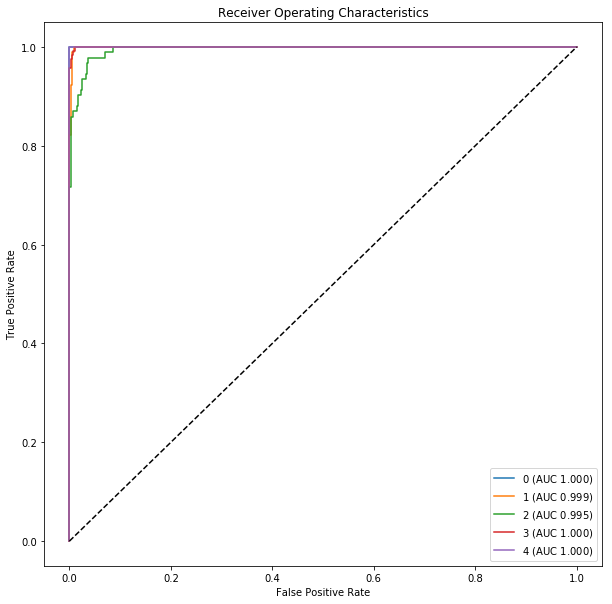

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

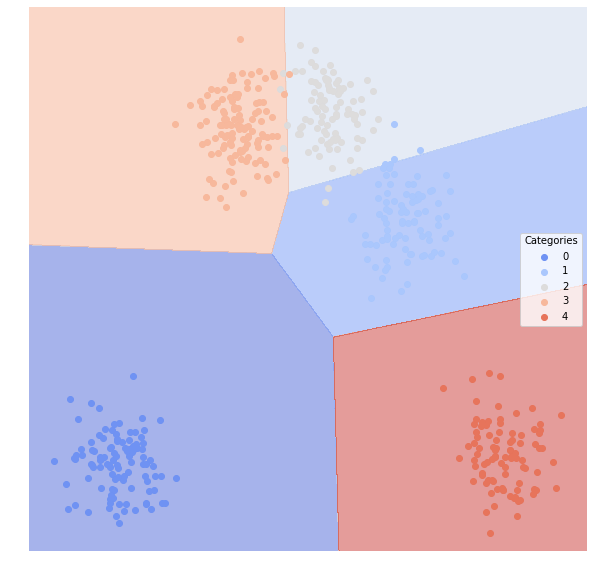

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.006  0.987669   0.988764           0.970792  0.977778
2              0.012  0.988438   0.947917           0.939613  0.989130
3              0.006  0.987500   1.000000           0.981000  0.975000
4              0.000  1.000000   1.000000           1.000000  1.000000


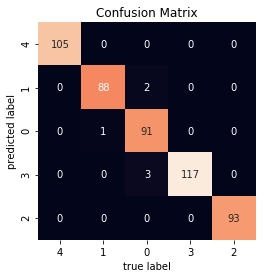

None


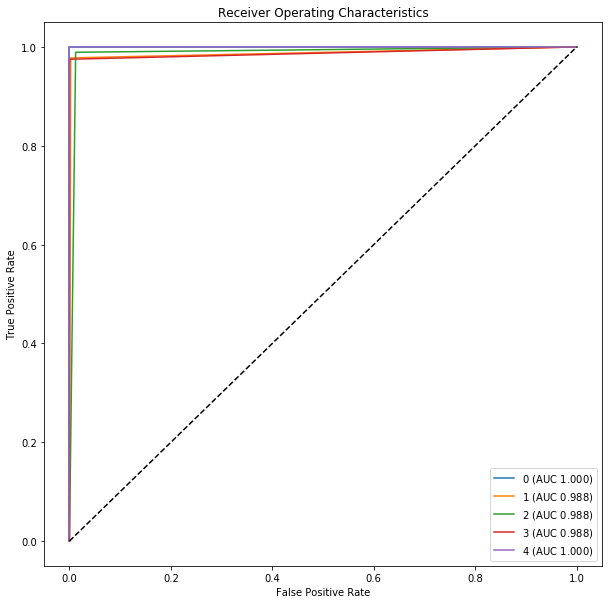

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

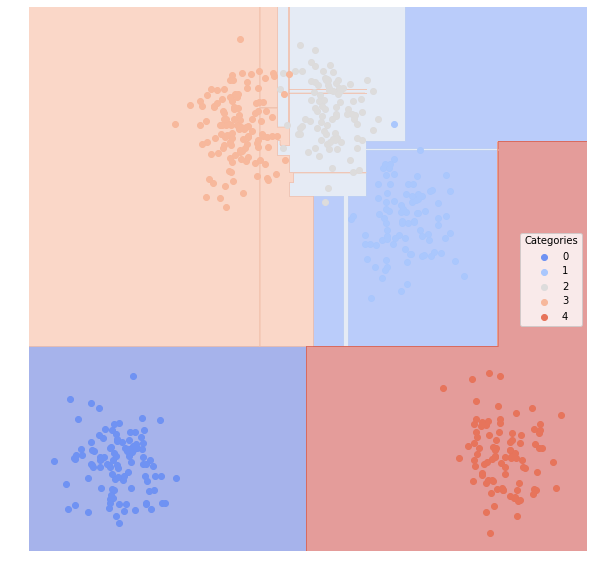

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.004  0.993225   0.988889           0.979901  0.988889
2              0.010  0.985454   0.967742           0.950704  0.978261
3              0.006  0.990351   0.991597           0.979070  0.983333
4              0.000  1.000000   1.000000           1.000000  1.000000


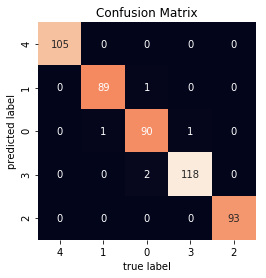

None


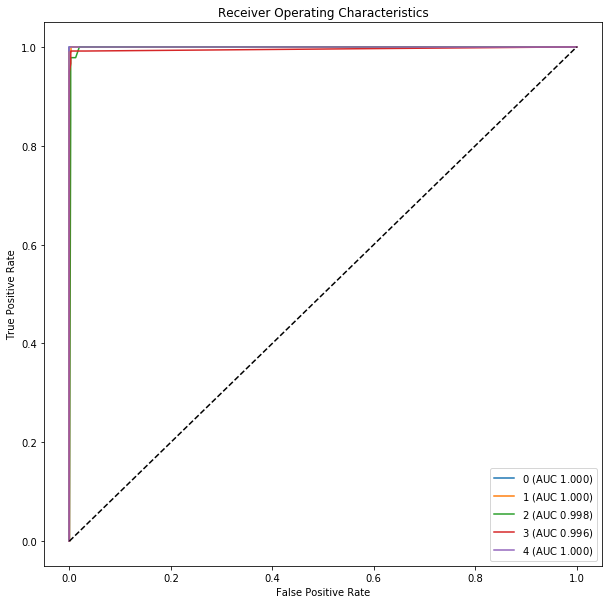

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

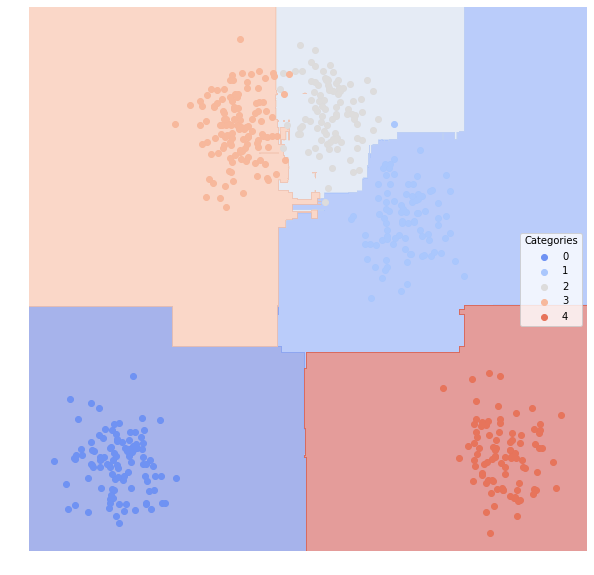

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.008  0.986679   0.978261           0.960994  0.978261
3              0.008  0.989035   0.983333           0.970944  0.983333
4              0.000  1.000000   1.000000           1.000000  1.000000


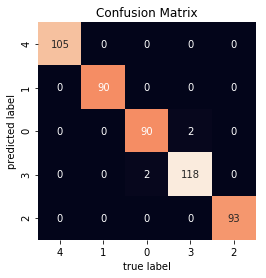

None


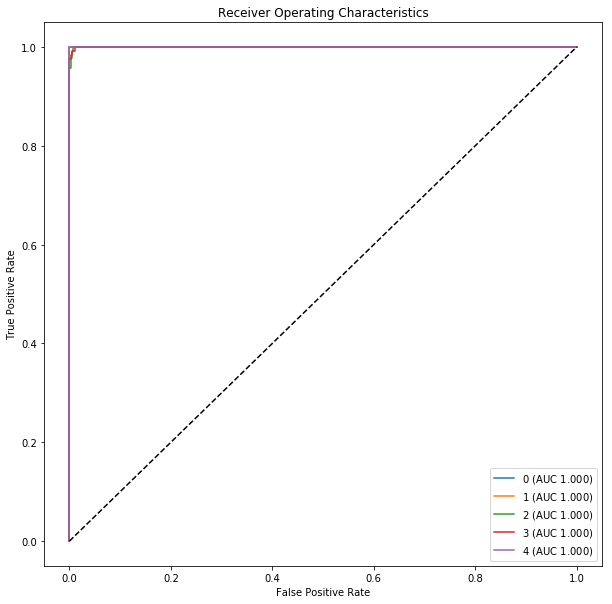

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

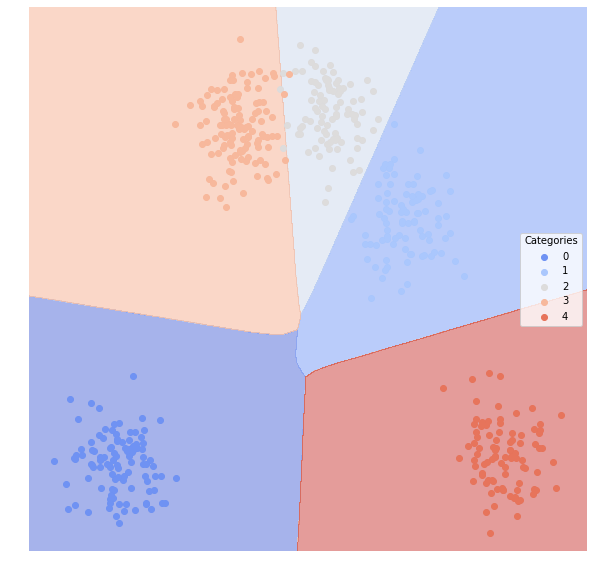

None
.........................................
.........................................
Dataset 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.002  0.995238   1.000000           0.992476  0.990476
1              0.004  0.988889   1.000000           0.981778  0.977778
2              0.008  0.995098   0.958333           0.958333  1.000000
3              0.006  0.990351   0.991597           0.979070  0.983333
4              0.000  1.000000   1.000000           1.000000  1.000000


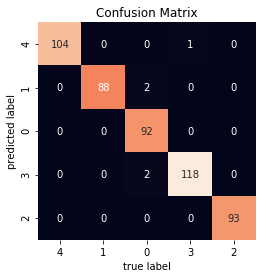

None


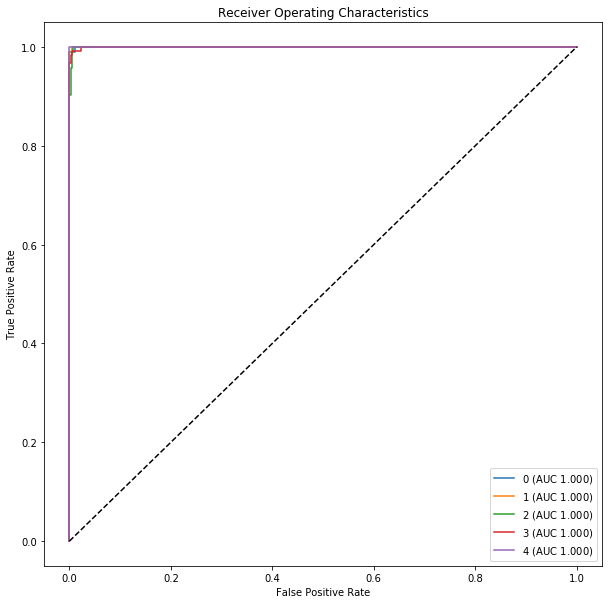

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

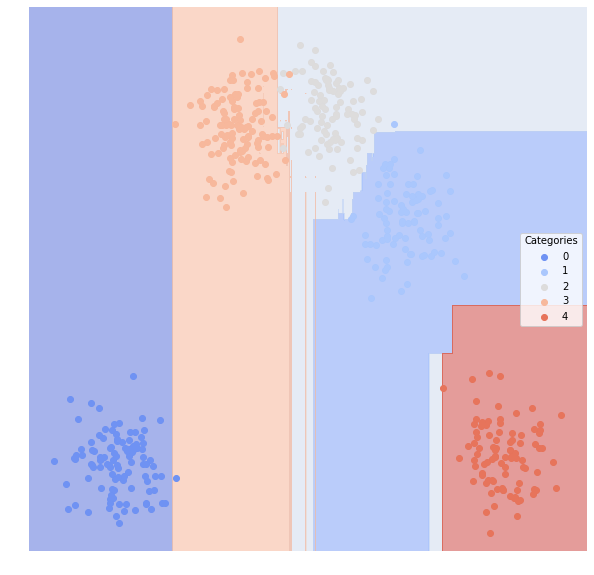

None
.........................................
.........................................
Dataset 10
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.118  0.838383   0.690265           0.575850  0.764706
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.180  0.728028   0.542857           0.396554  0.575758
3              0.018  0.969264   0.958333           0.918935  0.948454
4              0.196  0.681482   0.549451           0.370753  0.467290


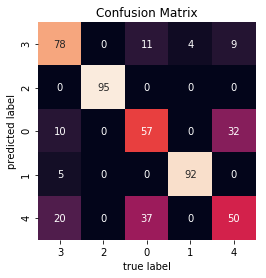

None


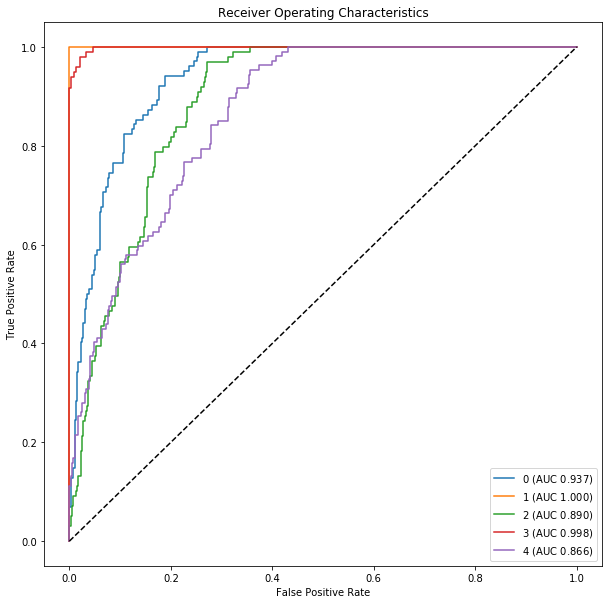

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

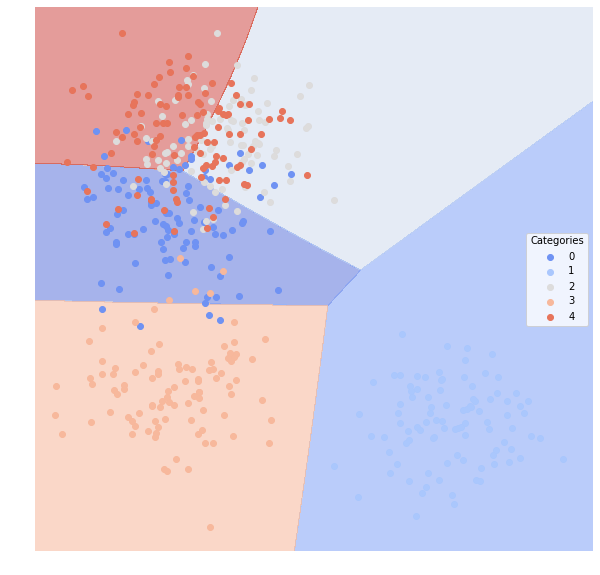

None
.........................................
.........................................
Dataset 10
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.120  0.837127   0.684211           0.571220  0.764706
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.180  0.728028   0.542857           0.396554  0.575758
3              0.018  0.969264   0.958333           0.918935  0.948454
4              0.198  0.676809   0.544444           0.365325  0.457944


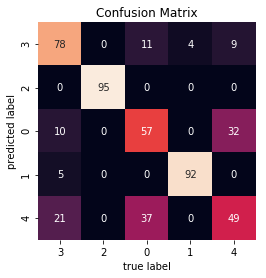

None


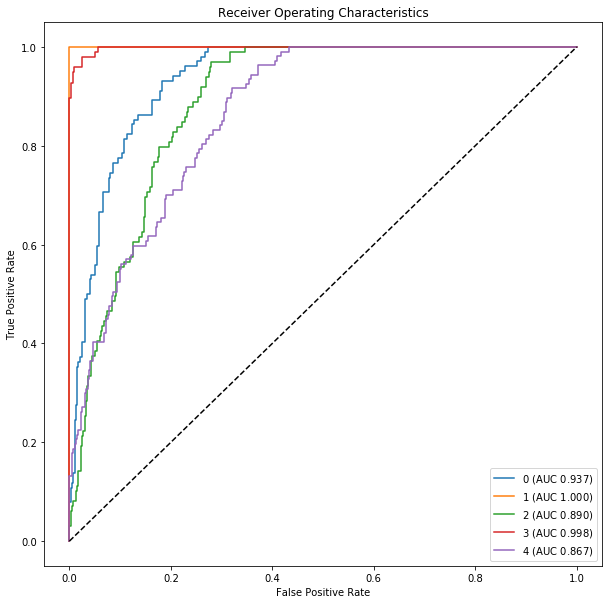

None


KeyboardInterrupt: 

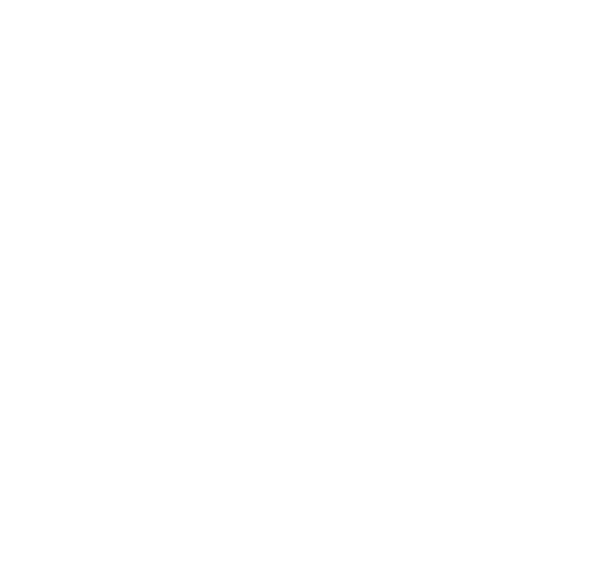

In [139]:
noise_low = 0.1
noise_high = 0.9

dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random(100))
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random(1000))

dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise_low))
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise_high))

dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise_low)) 
dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise_high))


dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise_low))
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise_high))


dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise_low))
dfTrain10, dfTest10 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise_high))

trainl = [dfTrain1, dfTrain2, dfTrain3, dfTrain4, dfTrain5, dfTrain6, dfTrain7, dfTrain8, dfTrain9, dfTrain10]
testl = [dfTest1, dfTest2, dfTest3, dfTest4, dfTest5, dfTest6, dfTest7, dfTest8, dfTest9, dfTest10]
methods = [clf_nb, clf_linsvc, clf_polysvc, clf_neigh, clf_logreg, clf_dtree, clf_rf, clf_mlp, clf_gbc]
for i in range(10):
    for clf in methods:
        print (".........................................")
        print ("Dataset", i+1)
        dfTrain = trainl[i]
        dfTest = testl[i]
        clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
        print (lucem_illud_2020.evaluateClassifier(clf, dfTest))
        print (lucem_illud_2020.plotConfusionMatrix(clf, dfTest))
        print (lucem_illud_2020.plotMultiROC(clf, dfTest))
        print (lucem_illud_2020.plotregions(clf, dfTest))
        print (".........................................")




          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.246  0.477215   0.000000           0.210000  0.000000
1              0.362  0.397696   0.021053           0.176468  0.022222
2              0.320  0.803922   0.365079           0.365079  1.000000
3              0.450  0.361842   0.000000           0.240000  0.000000
4              0.246  0.463145   0.000000           0.186000  0.000000


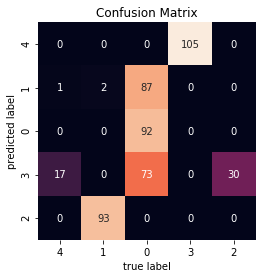

None


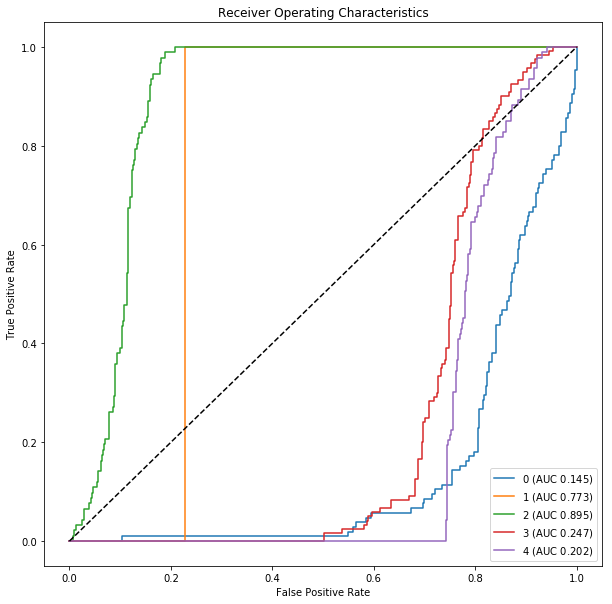

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

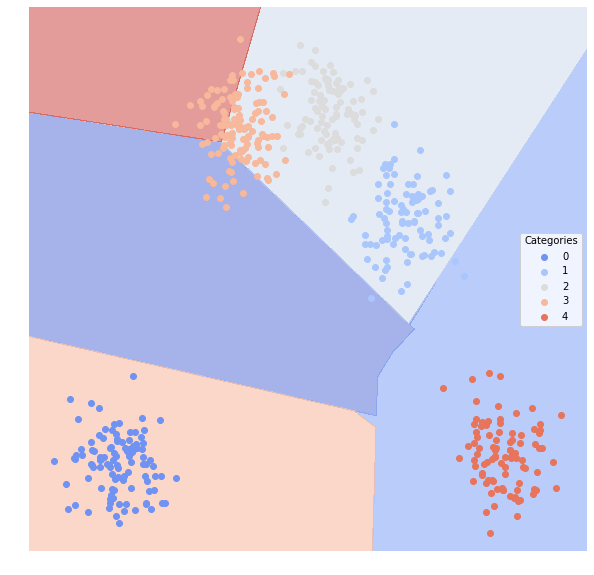

None


In [259]:
dfTrain = dfTrain9
dfTest = dfTest9
clf_sgd.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print (lucem_illud_2020.evaluateClassifier(clf, dfTest))
print (lucem_illud_2020.plotConfusionMatrix(clf, dfTest))
print (lucem_illud_2020.plotMultiROC(clf, dfTest))
print (lucem_illud_2020.plotregions(clf, dfTest))

Amongst the aritfical datasets, intresingly the blob data seems to be most amenable to classification with all the classifiers doing well except for Stochastic gradient descent. Perhaps SGD needs more iterations to converge. 

The dataset made with andsplit also seems to be amenable to classification, being a simple dataset. The classifier that worked best on that was the logistic regression classifier which gave upon plotting the region seems to have captured the noisy interfacial points very well.

I couldn't run the emperical datasets as an RCC account is not provided to me yet and running those datasets (including just loading with the provided code, took too much time). However I analyed the results run elsewhere:


# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [ ]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [ ]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [ ]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [ ]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

In [ ]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [ ]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [ ]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

Recall:

In [ ]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

F1-measure:

In [ ]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

Let's take a look at how well our posterior distribution looks relative to the truth.

In [ ]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [ ]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [9]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [ ]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Now we need to tokenize, and make a training and testing set:

In [ ]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [ ]:
print(len(train_ng_df))
print(len(test_ng_df))

We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [ ]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

...and save predictions to the dataframe:

In [ ]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

In [ ]:
train_ng_df[['category', 'nb_predict']][:10]

Looks pretty good, lets examine the testing dataset:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

In [ ]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [ ]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_scoretest_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [ ]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

In [ ]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

In [ ]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


I am classifying below if tweets are fake or not, based on a publicly available dataset of about 1500 tweets, manually annoted by two experts(tweet is considered fake news, if they both agree it meets the standards of "intentionally misleading information").

In [242]:
Faketweets = pandas.read_csv('./electionday_m.csv', index_col=False)

In [243]:
uncodedFaketweets = pandas.read_csv('./twitter_fakenews_m.csv', index_col=False, nrows=2000)[-200:]

In [181]:
uncodedFaketweets

is_fake_news_1 is_fake_news_2  fake_news_category_1  \
1800          FALSE          FALSE                     0   
1801          FALSE          FALSE                     0   
1802          FALSE          FALSE                     0   
1803          FALSE           TRUE                     0   
1804           TRUE           TRUE                     5   
...             ...            ...                   ...   
1995          FALSE           TRUE                    -1   
1996          FALSE          FALSE                     0   
1997          FALSE          FALSE                     0   
1998          FALSE          FALSE                     0   
1999          FALSE          FALSE                     0   

      fake_news_category_2            tweet_id  \
1800                     0  784891515977932800   
1801                     0  784891532620902400   
1802                     0  784910077803180032   
1803                     1  784914786068881412   
1804                     1  784916104569380870   
...                    ...                 ...   
1995                     1  786707390683119616   
1996                     0  786715364470194177   
1997                     0  786728638934716416   
1998                     0  786740634291998721   
1999                     0  786754900034191360   

                          created_at  retweet_count  \
1800  Sat Oct 08 23:01:34 +0000 2016           1315   
1801  Sat Oct 08 23:01:38 +0000 2016           2076   
1802  Sun Oct 09 00:15:20 +0000 2016           3088   
1803  Sun Oct 09 00:34:02 +0000 2016           3358   
1804  Sun Oct 09 00:39:17 +0000 2016           5898   
...                              ...            ...   
1995  Thu Oct 13 23:17:12 +0000 2016           4307   
1996  Thu Oct 13 23:48:54 +0000 2016           1853   
1997  Fri Oct 14 00:41:38 +0000 2016           6478   
1998  Fri Oct 14 01:29:18 +0000 2016           1443   
1999  Fri Oct 14 02:26:00 +0000 2016           1002   

                                                   text user_screen_name  \
1800  I couldn't be prouder to be casting my vote fo...    EricSpracklen   
1801  It's funny to hear people declare @realDonaldT...     DineshDSouza   
1802  2 days of Trumptalk and all I can say is, Real...        billmaher   
1803  What's worse Americans abandoned in Benghazi o...      seanhannity   
1804  4 Americans are dead after being abandoned by ...      seanhannity   
...                                                 ...              ...   
1995  News has broken that @HillaryClinton has been ...      bbcthisweek   
1996  Great to join the Northampton County GOP in Be...       mike_pence   
1997  Donald, you'll be the greatest president. @rea...        jonvoight   
1998  Please RT if you agree @realDonaldTrump is big...     NatureGuy101   
1999  Thank you Iowa for the legendary hospitality—e...      billclinton   

      user_verified  user_friends_count  user_followers_count  \
1800          False                 369                 89725   
1801           True                4246                382309   
1802           True                  41               5857083   
1803           True                6815               1863011   
1804           True                7285               2171256   
...             ...                 ...                   ...   
1995           True                1566                 53123   
1996           True                1204                724107   
1997           True                   2                 39484   
1998          False               25300                 22994   
1999           True                  26               6430672   

      user_favourites_count         tweet_source  geo_coordinates_available  \
1800                  13157   Twitter for iPhone                          2   
1801                    530   Twitter for iPhone                          0   
1802                     13   Twitter for iPhone                          0   
1803        

In [245]:
Faketweets['category'] = [s == True for s in Faketweets['is_fake_news']]
Faketweets['tokenized_text'] = Faketweets['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
Faketweets['normalized_text'] = Faketweets['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [226]:
# uncodedFaketweets['category'] = [(s,r) == (True,True) for (s,r) in zip(uncodedFaketweets['is_fake_news_1'],uncodedFaketweets['is_fake_news_2'])]
# uncodedFaketweets['tokenized_text'] = uncodedFaketweets['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
# uncodedFaketweets['normalized_text'] = uncodedFaketweets['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
# uncoded_data_df=uncodedFaketweets

In [247]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(Faketweets, holdBackFraction=holdBackFraction)
print("Train data size:", len(train_data_df))
print("Test data size:", len(test_data_df))
print(len(test_data_df))
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]


pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]
count_f = 0
for c in Faketweets['category']:
    if c==True:
        count_f=count_f+1
print ('Total tweets in train:', len(Faketweets['category']))
print ("Fake news tweets in train:", count_f)

Train data size: 1062
Test data size: 265
265
Total tweets in train: 1327
Fake news tweets in train: 136


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


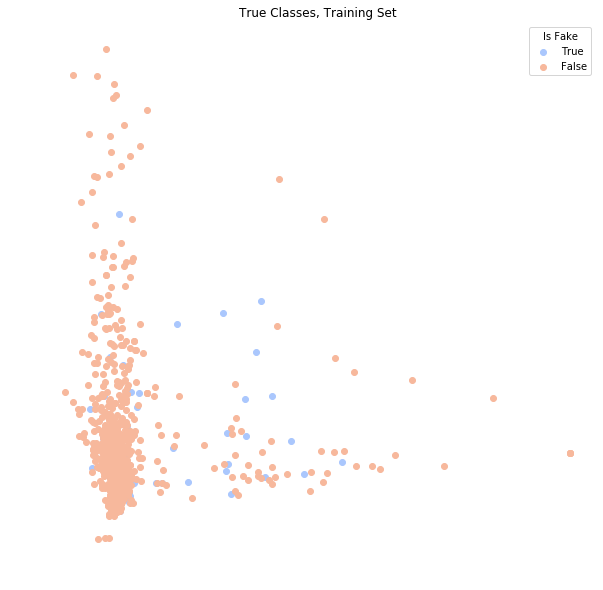

In [248]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Fake
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Fake
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Fake')
plt.title('True Classes, Training Set')
plt.show()



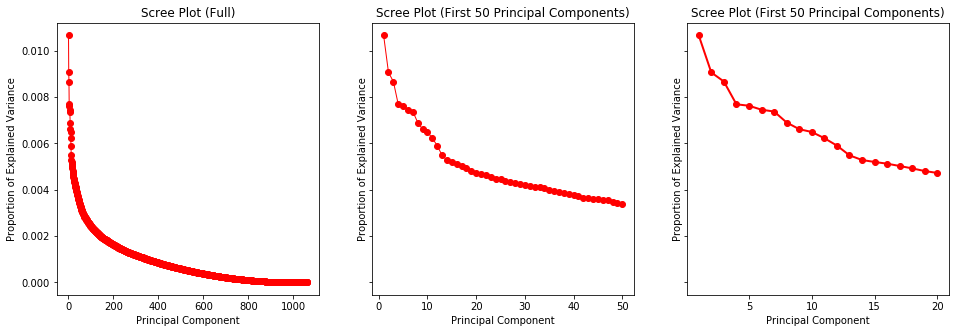

In [249]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [230]:
print ("There seems to be an elbow at n=8, so we will choose 8 components")

There seems to be an elbow at n=8, so we will choose 8 components


In [250]:
train_data_df['pca_reduced_8'] = train_data_df['pca'].apply(lambda x: x[:8])
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_8'], axis=0), train_data_df['category'])
logistic.score(np.stack(train_data_df['pca_reduced_8'], axis=0), train_data_df['category'])


0.8926553672316384

In [251]:
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

TFVects_test = TFVectorizer.transform(uncoded_data_df['text'])
uncoded_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [252]:
#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_8'] = test_data_df['pca'].apply(lambda x: x[:8])

reduced_data_uncoded = pca.transform(np.stack(uncoded_data_df['vect'], axis=0))
uncoded_data_df['pca'] = [r for r in reduced_data_uncoded]
uncoded_data_df['pca_reduced_8'] = uncoded_data_df['pca'].apply(lambda x: x[:8])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_8'], axis=0), test_data_df['category'])


0.9169811320754717

In [253]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))


Training:
0.8945386064030132
Testing:
0.9245283018867925


In [254]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.896421845574388
Testing:
0.9207547169811321


In [257]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])
uncoded_data_df['pca_reduced_400'] = uncoded_data_df['pca'].apply(lambda x: x[:400])
logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])


print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))


Training:
0.896421845574388
Testing:
0.9207547169811321


In [258]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))
lucem_illud_2020.evaluateClassifier(naiveBayes, test_data_df)

Training:
0.9265536723163842
Testing:
0.9245283018867925


Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.075472  0.545455   0.923954           0.923954  1.000000
True        0.075472  0.545455   1.000000           0.166381  0.090909

This is not giving great results. Given the complexity of the problem, a linear model might be insufficient to learn from the data. However, from the precision numbers, we can see that if this model identifies an tweet as fake, it probably is. 

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

In [ ]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification: 

In [ ]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


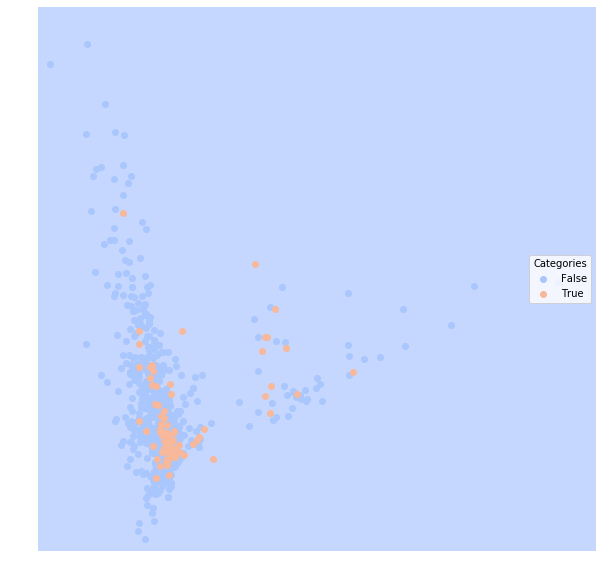

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


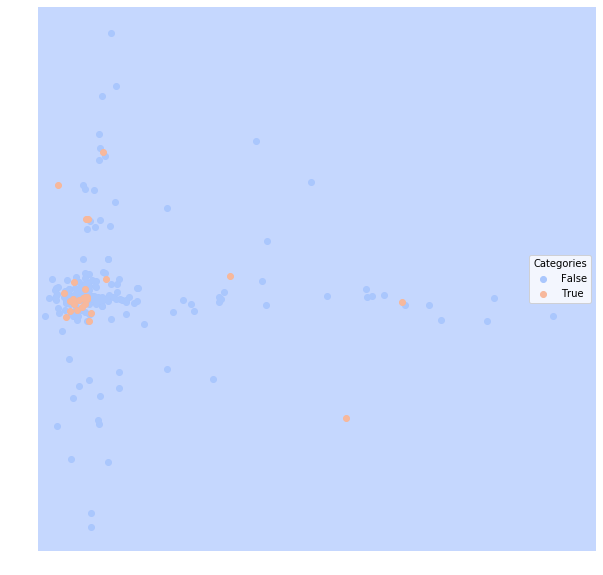

In [96]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
lucem_illud_2020.plotregions(clf_tree, train_data_df)
lucem_illud_2020.plotregions(clf_tree, test_data_df)

In [260]:
lucem_illud_2020.evaluateClassifier(naiveBayes, test_data_df)

Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.075472  0.545455   0.923954           0.923954  1.000000
True        0.075472  0.545455   1.000000           0.166381  0.090909

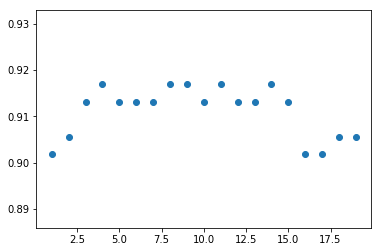

In [102]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [104]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tre
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


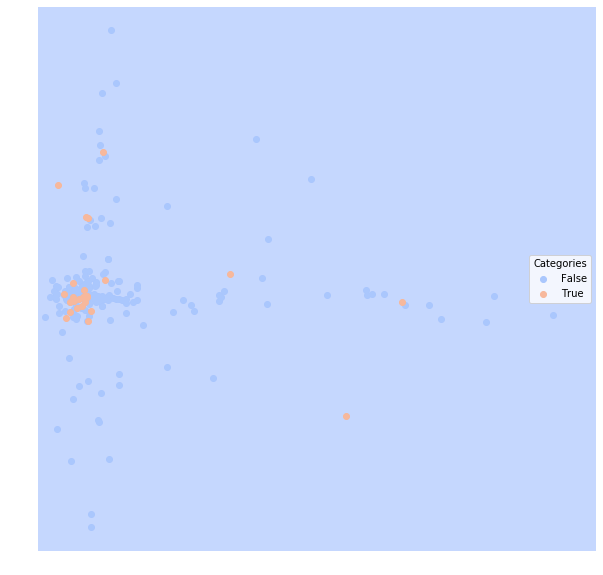

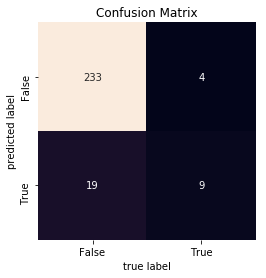

In [106]:
lucem_illud_2020.plotregions(bag, test_data_df)
lucem_illud_2020.plotConfusionMatrix(bag, test_data_df)

In [107]:
lucem_illud_2020.evaluateClassifier(bag, test_data_df)

Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.086792  0.652275   0.924603           0.924092  0.983122
True        0.086792  0.652275   0.692308           0.294226  0.321429

The bag model performs better than the models above, although precision for the fakenews tweets goes up, recall goes down.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [109]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


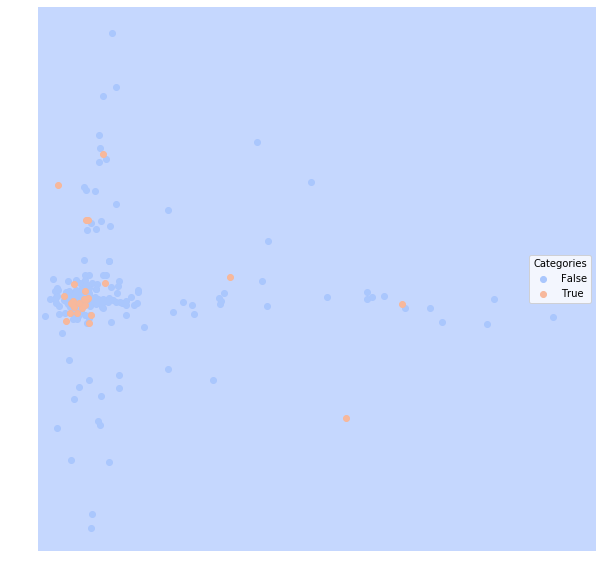

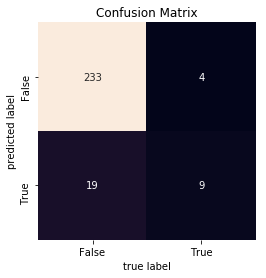

In [110]:
lucem_illud_2020.plotregions(bag, test_data_df)
lucem_illud_2020.plotConfusionMatrix(bag, test_data_df)

In [111]:
lucem_illud_2020.evaluateClassifier(bag, test_data_df)

Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.086792  0.652275   0.924603           0.924092  0.983122
True        0.086792  0.652275   0.692308           0.294226  0.321429

In nearest neighbour, the centroids are actual datapoints as opposed to k-means. This model improves on the previous model, especially in the precision of the fake news tweets.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [112]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [114]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
False       0.113208  0.62176   0.919028           0.917987  0.957806
True        0.113208  0.62176   0.444444           0.202456  0.285714

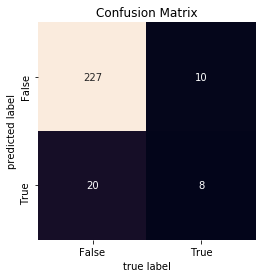

In [115]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


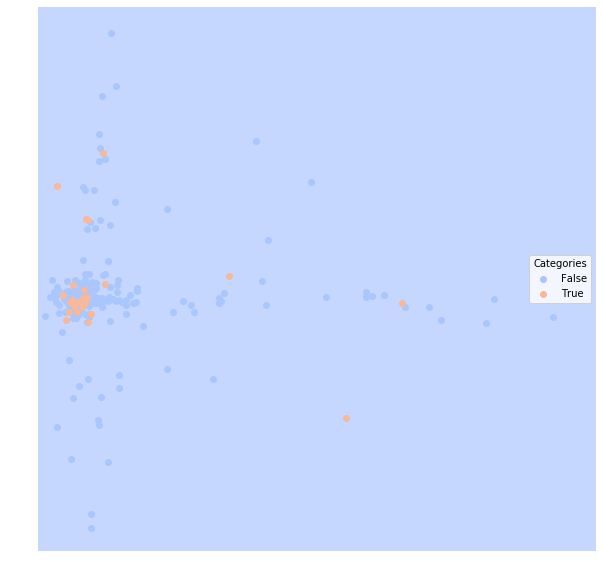

In [116]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


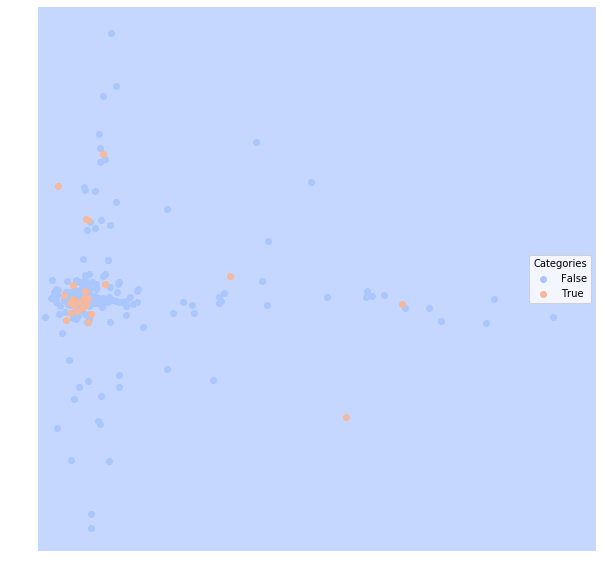

In [117]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
lucem_illud_2020.plotregions(clf_nn, test_data_df)

In [119]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_data_df)

Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
False       0.113208  0.62176   0.919028           0.917987  0.957806
True        0.113208  0.62176   0.444444           0.202456  0.285714

The NN model is close in performance to the best model so far(K-neighbours). The precision for fakenews articles goes up from k-neighbours, but recall is low. This is suprising as NN should capture the non-linearity inherent in functions of text.